In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib notebook

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [2]:
atlas_name = 'atlasV5'

In [3]:
fp = DataManager.get_instance_centroids_filepath(atlas_name=atlas_name)
download_from_s3(fp)
instance_centroids_rel2fixed = load_pickle(fp)

In [4]:
ann_vol_bbox_rel2uncropped = DataManager.load_original_volume_bbox(stack='MD589', volume_type='annotation', downscale=32)
print 'annotation volume bbox (rel2uncropped):', ann_vol_bbox_rel2uncropped

annotation volume bbox (rel2uncropped): [ 622 1042  155  502  128  503]


In [5]:
canonical_locations_rel2canon, canonical_centroid_rel2fixed, canonical_normal = \
average_location(instance_centroids_rel2fixed)

canonical_centroid_rel2uncropped = canonical_centroid_rel2fixed + ann_vol_bbox_rel2uncropped[[0,2,4]]
print 'canonical_centroid_rel2uncropped', canonical_centroid_rel2uncropped

[ 0.04111027 -0.09160432  0.99494653] @ [ 172.0630378   223.21016434  186.74030921]
canonical_centroid_rel2uncropped [ 794.0630378   378.21016434  314.74030921]


In [6]:
canonical_locations_rel2fixed = {k: canonical_centroid_rel2fixed + c_rel2canon 
                                 for k, c_rel2canon in canonical_locations_rel2canon.iteritems()}

In [7]:
print 'deviation angle:', np.rad2deg(np.arccos(canonical_normal[2]))

deviation angle: 5.76256199381


In [8]:
canonical_midplane_xx, canonical_midplane_yy = np.meshgrid(range(0, 500, 100), range(0, 500, 100), indexing='xy')
canonical_midplane_z = -(canonical_normal[0]*(canonical_midplane_xx-canonical_centroid_rel2fixed[0]) + \
canonical_normal[1]*(canonical_midplane_yy-canonical_centroid_rel2fixed[1]) + \
canonical_normal[2]*(-canonical_centroid_rel2fixed[2]))/canonical_normal[2]

In [9]:
# radii_allStructures = {}
# ellipsoid_matrix_allStructures = {}
# for name_s, centroids in sorted(instance_centroids_rel2fixed.items()):
#     centroids2 = np.array(centroids)
#     cov_mat = np.cov(centroids2.T)
#     u, s, vt = np.linalg.svd(cov_mat)
# #     print name_s, u[:,0], u[:,1], u[:,2],
#     radii_allStructures[name_s] = np.sqrt(s)
#     ellipsoid_matrix_allStructures[name_s] = vt

In [10]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# for name_s, centroids in instance_centroids_rel2fixed.iteritems():
# #     if name_s == '7N_L' or name_s == '7N_R':
#     centroids2 = np.array(centroids)
#     ax.scatter(centroids2[:,0], centroids2[:,1], centroids2[:,2], 
#                color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
#                marker='o', s=100, alpha=.1)
    
#     c = canonical_locations_rel2fixed[name_s]
#     ax.scatter(c[0], c[1], c[2], 
#                color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., marker='*', s=100)
    
#     # Plot uncerntainty ellipsoids
#     u = np.linspace(0.0, 2.0 * np.pi, 100)
#     v = np.linspace(0.0, np.pi, 100)
#     x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
#     y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
#     z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
#     for i in range(len(u)):
#         for j in range(len(v)):
#             [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

# #     ax.plot_surface(x, y, z, color='b')
#     ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
    
# ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
#            color=(0,0,0), marker='^', s=200)

# # Plot mid-sagittal plane
# ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

# # ax.set_xlabel('X Label')
# # ax.set_ylabel('Y Label')
# # ax.set_zlabel('Z Label')
# # ax.set_axis_off()
# ax.set_xlim3d([0, 400]);
# ax.set_ylim3d([0, 400]);
# ax.set_zlim3d([0, 400]);
# # ax.view_init(azim = 90 + 20,elev = 0 - 20)
# ax.view_init(azim = 90,elev = 0)
# ax.set_aspect(1.0)
# plt.legend()
# plt.show()

In [9]:
def consolidate(params, centroid_m, centroid_f):
    G = params.reshape((3,4))
    R = G[:3,:3]
    t = - np.dot(R, centroid_m) + G[:3,3] + centroid_f
    return np.vstack([np.c_[R,t], [0,0,0,1]])

In [10]:
adjusted_structure_centroids_rel2atlas = defaultdict(dict)

for s in all_known_structures_sided:
    try:
        c = canonical_locations_rel2fixed[s]
        for stack in all_nissl_stacks:
            global_params, centroid_m, centroid_f, _,_,_,_,_,_ = \
            DataManager.load_alignment_parameters(stack_m=atlas_name, stack_f=stack,
                                                  prep_id_f=2,
                                                  detector_id_f=15,
                                                  warp_setting=20)

            Gas = consolidate(global_params, centroid_m, centroid_f)

            local_params, centroid_m, centroid_f, _,_,_,_,_,_ = \
            DataManager.load_alignment_parameters(stack_m=atlas_name, stack_f=stack,
                                                  prep_id_f=2,
                                                  detector_id_f=15,
                                                  warp_setting=17,
                                                  structure_f=s,
                                                  structure_m=s)
            Lss = consolidate(local_params, centroid_m, centroid_f)
            
            Gas_inv = np.linalg.inv(Gas)
            Laa = np.dot(Gas_inv, np.dot(Lss, Gas))
            
            adjusted_structure_centroids_rel2atlas[s][stack] = np.dot(Laa[:3, :3], c) + Laa[:3, 3]
    except Exception as e:
        sys.stderr.write("Cannot compute centroid in atlas space for %s: %s\n" % (s, e))
        
adjusted_structure_centroids_rel2atlas.default_factory = None

5N_L
5N_R
6N_L
6N_R
7N_L
7N_R
7n_L
7n_R
Amb_L
Amb_R
LC_L
LC_R
LRt_L
LRt_R
Pn_L
Pn_R
Tz_L
Tz_R
VLL_L
VLL_R
RMC_L
RMC_R
SNC_L
SNC_R
SNR_L
SNR_R
3N_L
3N_R
4N_L
4N_R
Sp5I_L
Sp5I_R
Sp5O_L
Sp5O_R
Sp5C_L
Sp5C_R
PBG_L
PBG_R
10N_L
10N_R
VCA_L
VCA_R
VCP_L
VCP_R
DC_L
DC_R
AP
12N
RtTg
SC
rm -rf "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC_parameters.txt" && mkdir -p "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC_parameters.txt" "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_

File does not exist: /shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC_parameters.txt
Cannot compute centroid in atlas space for SC: [Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC_parameters.txt'


IC


In [18]:
new_mean_centroids_rel2atlas_allstructures = {}
instance_centroids_deviations_allstructures = defaultdict(dict)
for s, centroids_rel2atlas_allstacks in adjusted_structure_centroids_rel2atlas.iteritems():
    new_mean_centroids_rel2atlas_allstructures[s] = np.mean(centroids_rel2atlas_allstacks.values(), axis=0)
    for st, c in centroids_rel2atlas_allstacks.iteritems():
        instance_centroids_deviations_allstructures[s][st] = c - new_mean_centroids_rel2atlas_allstructures[s]

In [102]:
outliers_allstructures = {}
# dxs_allstructures_outlierRemoved = {}
new_mean_centroids_rel2atlas_allstructures_outlierRemoved = {}

for s, ps_allstacks in sorted(instance_centroids_deviations_allstructures.items()):
    vals = np.linalg.norm(np.array(ps_allstacks.values()), axis=1)
    first_quartile = np.percentile(vals, 20)
    third_quartile = np.percentile(vals, 80)
    IQR = third_quartile - first_quartile
    is_outlier = (vals < first_quartile - 1 * IQR) | (vals > third_quartile + 1 * IQR)
#     dxs_allstructures_outlierRemoved[s] = vals[~is_outlier]
    
#     if np.count_nonzero(is_outlier) > 0:
    outlier_indices = np.where(is_outlier)[0]
    outliers_allstructures[s] = [ps_allstacks.keys()[i] for i in outlier_indices]
    print s, outliers_allstructures[s]
    
    new_mean_centroids_rel2atlas_allstructures_outlierRemoved[s] = \
    np.mean([adjusted_structure_centroids_rel2atlas[s][st]
             for st in set(ps_allstacks.keys())-set(outliers_allstructures[s])], 
            axis=0)
    
#     mu = np.mean(ps)
#     std = np.std(ps)
#     txs_allLandmarks_outlierRemoved[n] = np.array(ps)[np.abs(ps - mu) < 2. * std]
    
# write_dict_to_txt(outliers, '/home/yuncong/Brain/outliers.txt', fmt='%s')

10N_L []
10N_R []
12N []
3N_L []
3N_R []
4N_L ['MD590', 'MD598']
4N_R ['MD592']
5N_L []
5N_R ['MD603']
6N_L ['MD585']
6N_R ['MD594']
7N_L ['MD598']
7N_R []
7n_L []
7n_R []
AP []
Amb_L ['MD590']
Amb_R []
DC_L ['MD603', 'MD595']
DC_R ['MD598', 'MD599']
IC ['MD603']
LC_L ['MD593']
LC_R []
LRt_L []
LRt_R []
PBG_L []
PBG_R ['MD589']
Pn_L ['MD598']
Pn_R []
RMC_L []
RMC_R ['MD585']
RtTg []
SC ['MD589']
SNC_L []
SNC_R ['MD585']
SNR_L ['MD595', 'MD598']
SNR_R []
Sp5C_L []
Sp5C_R ['MD603']
Sp5I_L []
Sp5I_R ['MD585']
Sp5O_L ['MD594']
Sp5O_R []
Tz_L []
Tz_R []
VCA_L ['MD595']
VCA_R []
VCP_L ['MD603', 'MD595']
VCP_R ['MD595']
VLL_L []
VLL_R ['MD603', 'MD589']


In [103]:
radii_allStructures = {}
ellipsoid_matrix_allStructures = {}
for name_s in all_known_structures_sided:
    devs = np.array([v for st, v in instance_centroids_deviations_allstructures[name_s].iteritems()
                    if st not in outliers_allstructures[name_s]])
    cov_mat = np.cov(devs.T)
    u, s, vt = np.linalg.svd(cov_mat)
#     print name_s, u[:,0], u[:,1], u[:,2],
    radii_allStructures[name_s] = np.sqrt(s)
    ellipsoid_matrix_allStructures[name_s] = vt

In [112]:
updated_canonical_locations_rel2canon, updated_canonical_centroid_rel2atlas, updated_canonical_normal = \
average_location(mean_centroid_allLandmarks=new_mean_centroids_rel2atlas_allstructures_outlierRemoved)

[-0.00942703  0.00815817  0.99992228] @ [ 172.59354066  223.85545302  186.63909458]


In [114]:
updated_canonical_locations_rel2atlas = {k: updated_canonical_centroid_rel2atlas + c 
                                         for k, c in updated_canonical_locations_rel2canon.iteritems()}

In [116]:
print 'deviation angle:', np.rad2deg(np.arccos(updated_canonical_normal[2]))

deviation angle: 0.714321566566


In [117]:
updated_canonical_midplane_xx, updated_canonical_midplane_yy = np.meshgrid(range(0, 500, 100), range(0, 500, 100), indexing='xy')
updated_canonical_midplane_z = -(updated_canonical_normal[0] * (updated_canonical_midplane_xx - updated_canonical_centroid_rel2fixed[0]) + \
updated_canonical_normal[1]*(updated_canonical_midplane_yy - updated_canonical_centroid_rel2fixed[1]) + \
updated_canonical_normal[2]*(-updated_canonical_centroid_rel2fixed[2]))/updated_canonical_normal[2]

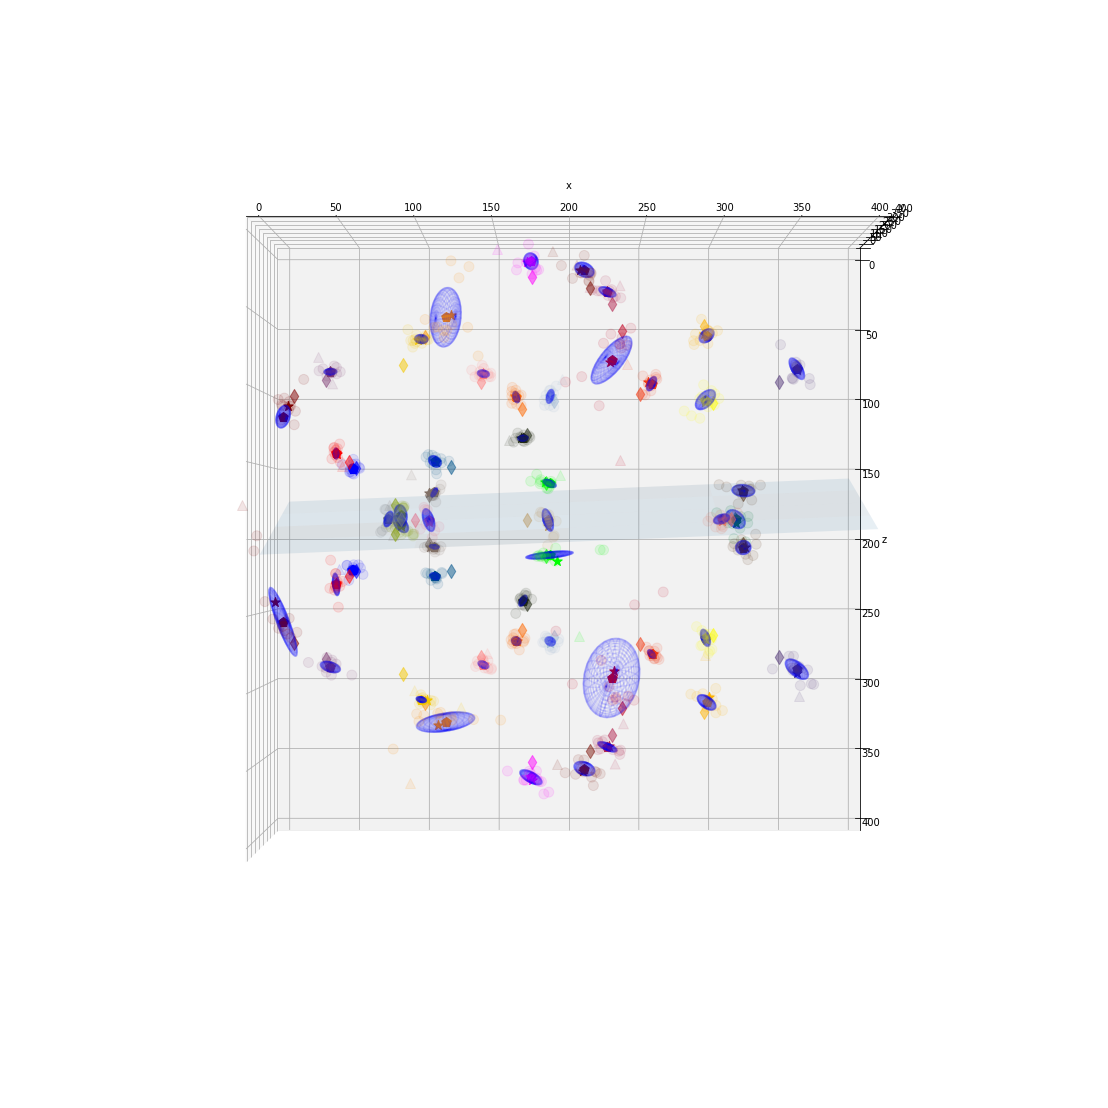

In [119]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot mid-sagittal plane
ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

# ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
#            color=(0,0,0), marker='^', s=200)

for name_s in all_known_structures_sided:

#     centroids = np.array(instance_centroids_rel2fixed[name_s])
#     ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
#                color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
#                marker='o', s=100, alpha=.1)

    c = canonical_locations_rel2fixed[name_s]
    ax.scatter(c[0], c[1], c[2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
               marker='d', s=100, alpha=.5)
    
    c = new_mean_centroids_rel2atlas_allstructures[name_s]
    ax.scatter(c[0], c[1], c[2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
               marker='*', s=100, alpha=1)
    
    c = updated_canonical_locations_rel2atlas[name_s]
    ax.scatter(c[0], c[1], c[2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
               marker='p', s=100, alpha=1)

    # Plot uncerntainty ellipsoids
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
    y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
    z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(u)):
        for j in range(len(v)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

#     ax.plot_surface(x, y, z, color='b')
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.1)

    
    centroids = np.array([c for st, c in adjusted_structure_centroids_rel2atlas[name_s].iteritems()
                         if st not in outliers_allstructures[name_s]])
    ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
               marker='o', s=100, alpha=.1)
    
    if len(outliers_allstructures[name_s]) > 0:
        centroids = np.array([c for st, c in adjusted_structure_centroids_rel2atlas[name_s].iteritems()
                             if st in outliers_allstructures[name_s]])
        ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
                   color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
                   marker='^', s=100, alpha=.1)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.set_axis_off()
ax.set_xlim3d([0, 400]);
ax.set_ylim3d([0, 400]);
ax.set_zlim3d([0, 400]);
ax.view_init(azim = -90, elev = 180)
# ax.view_init(azim = -90, elev = -45)
ax.set_aspect(1.0)
plt.legend()
plt.title('');
plt.show()

In [119]:
%matplotlib notebook

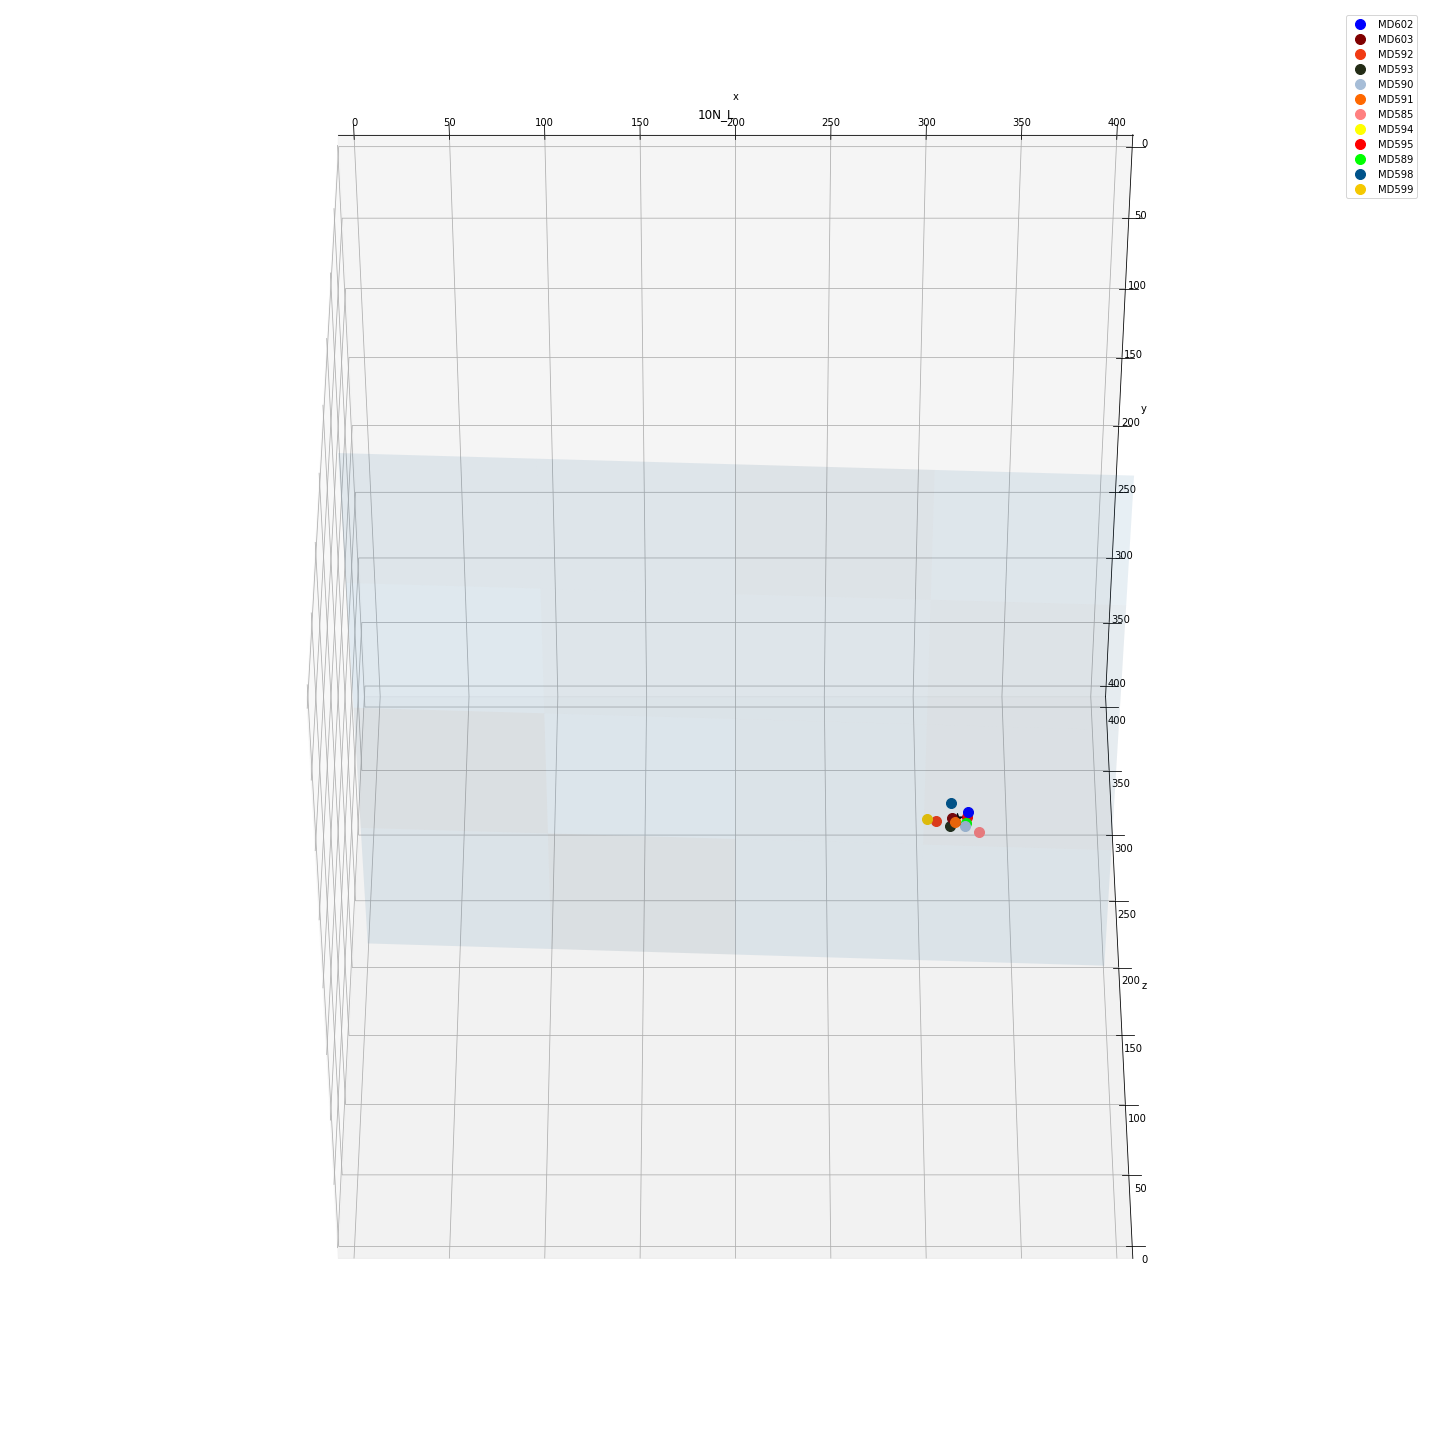

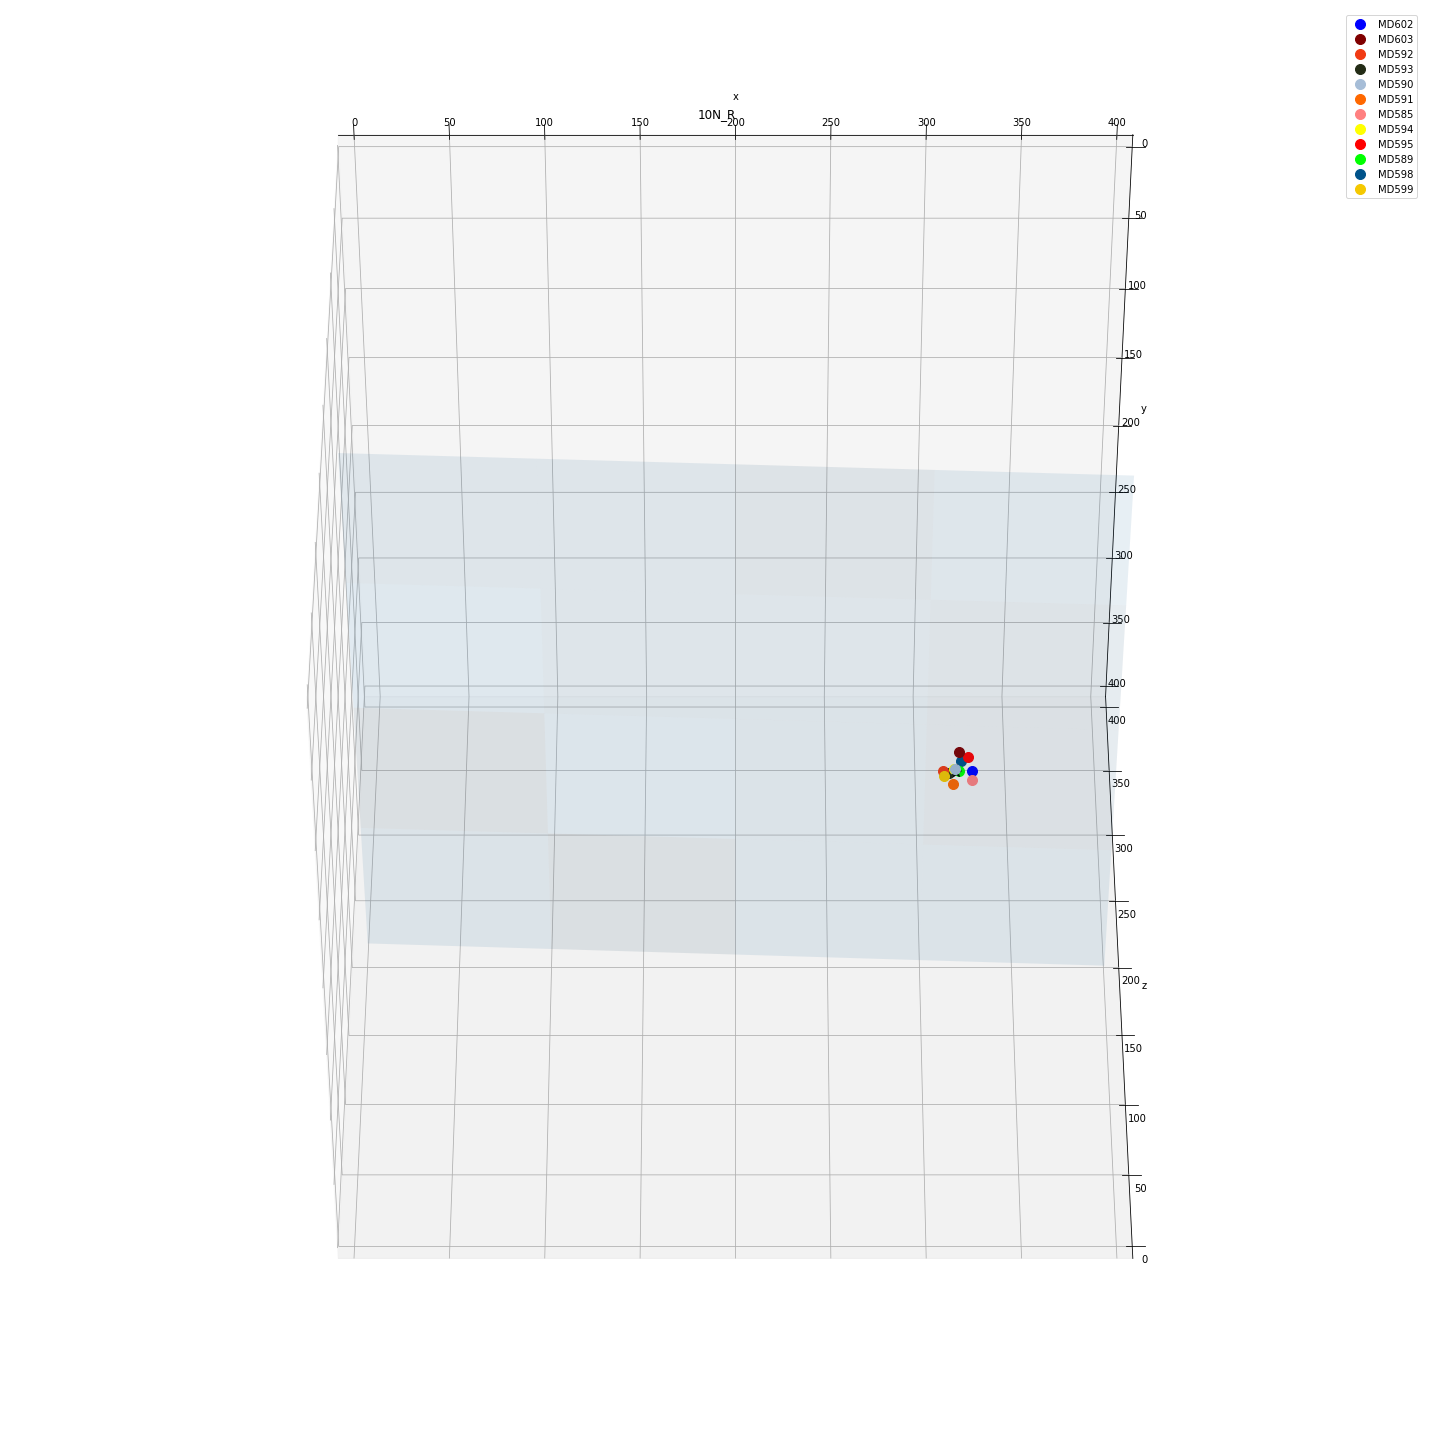

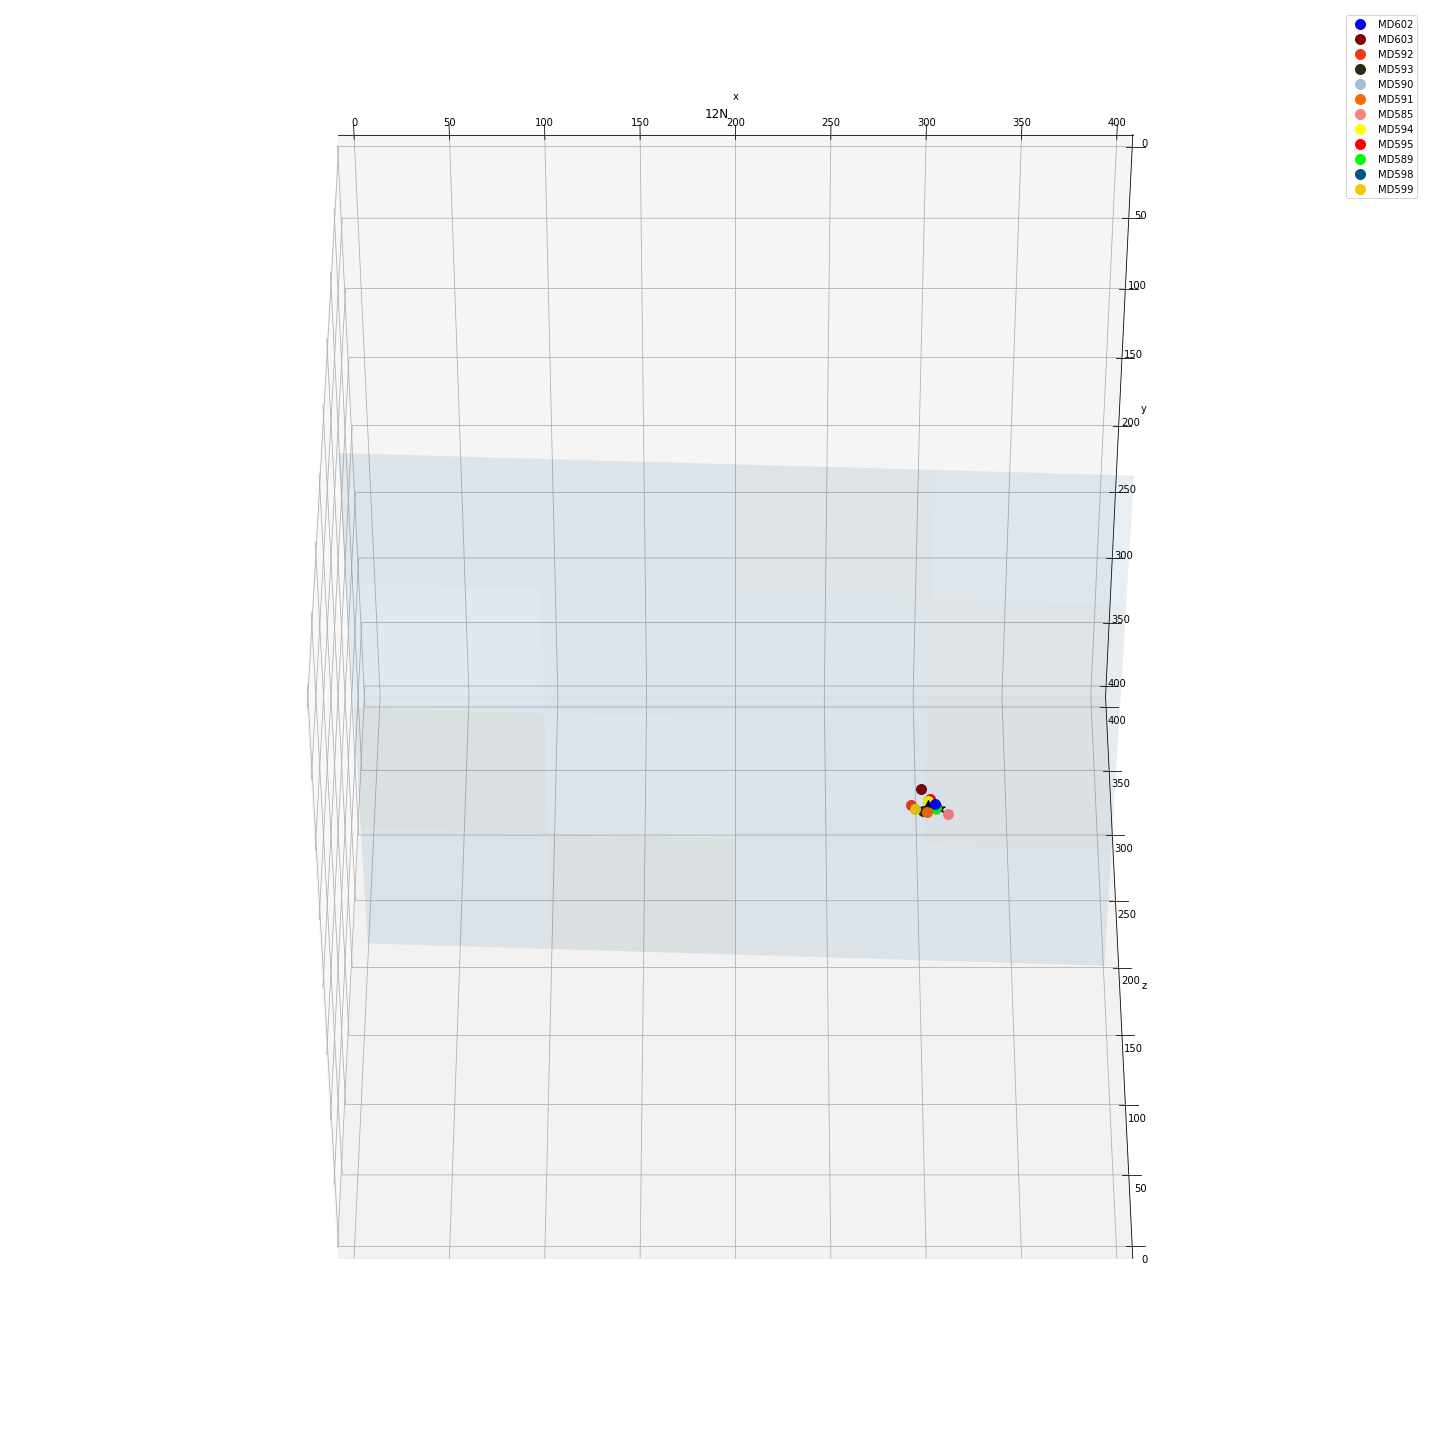

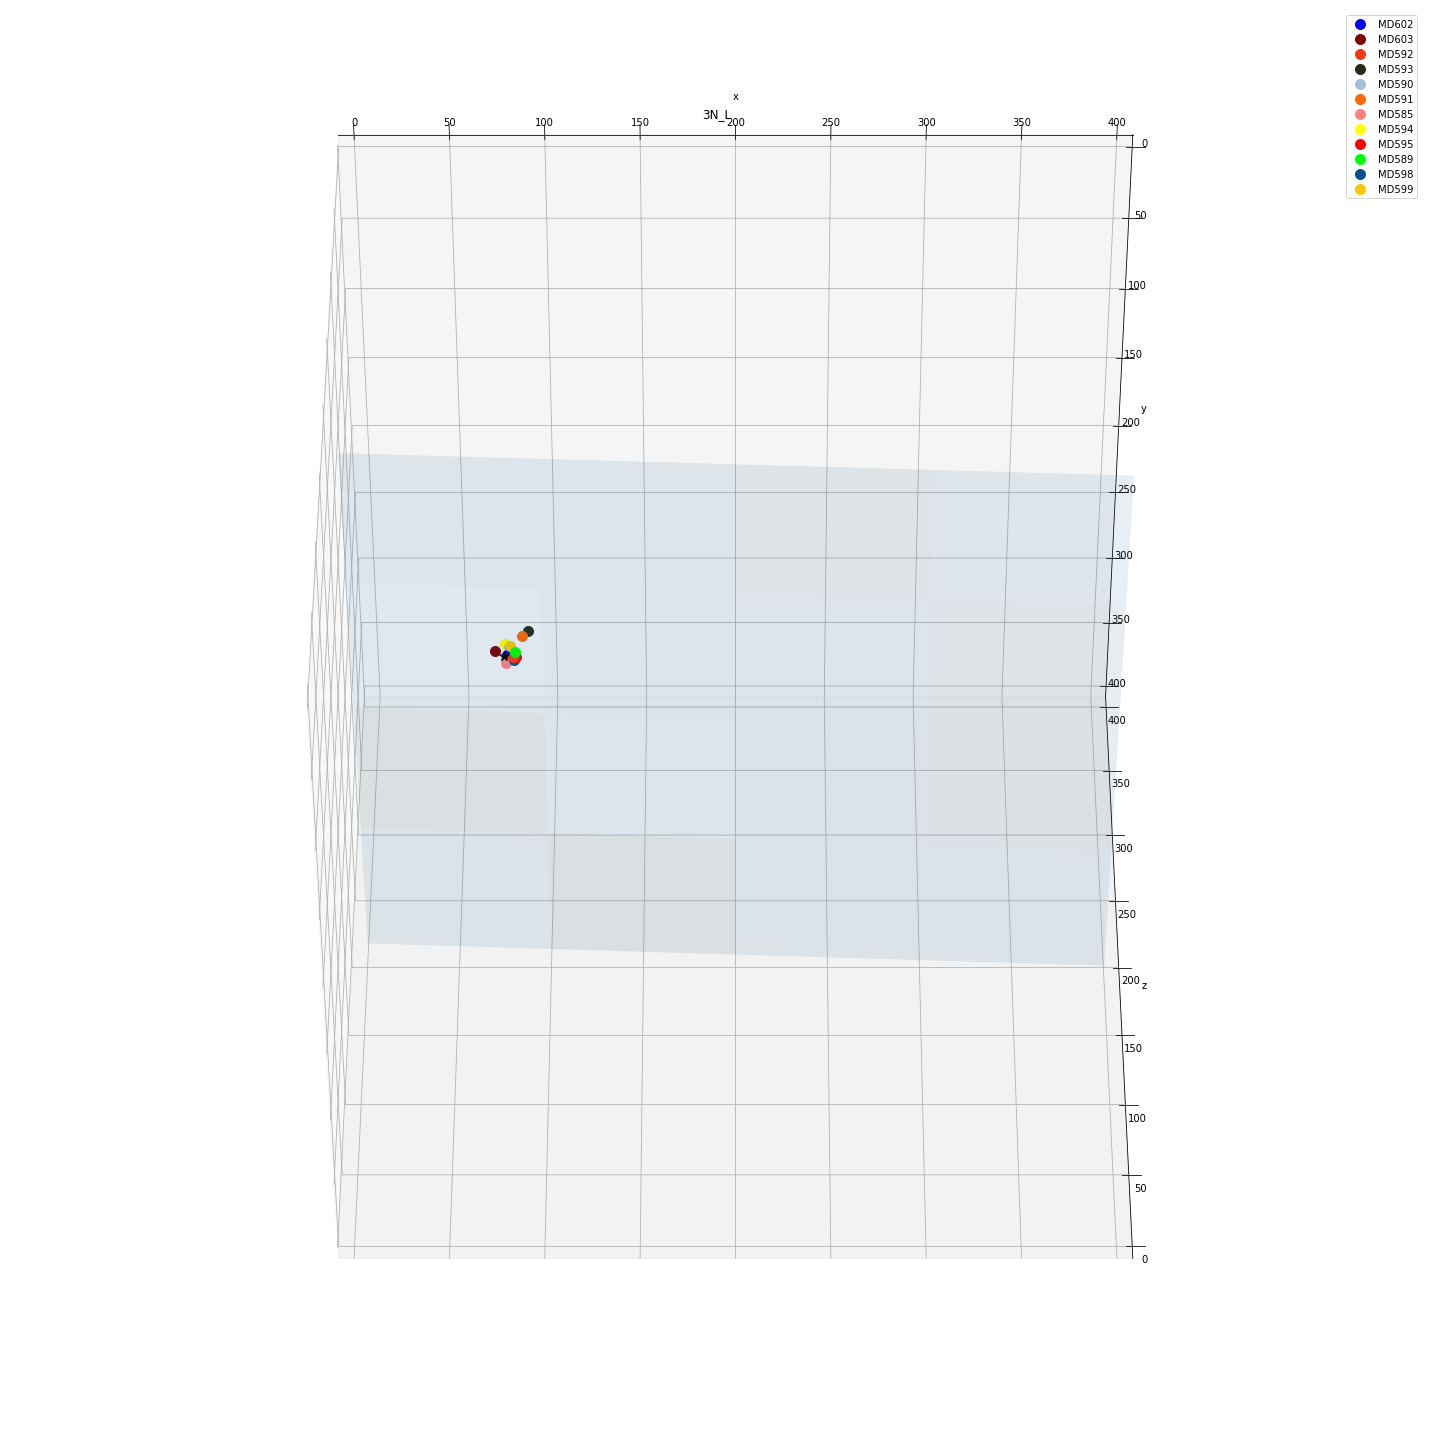

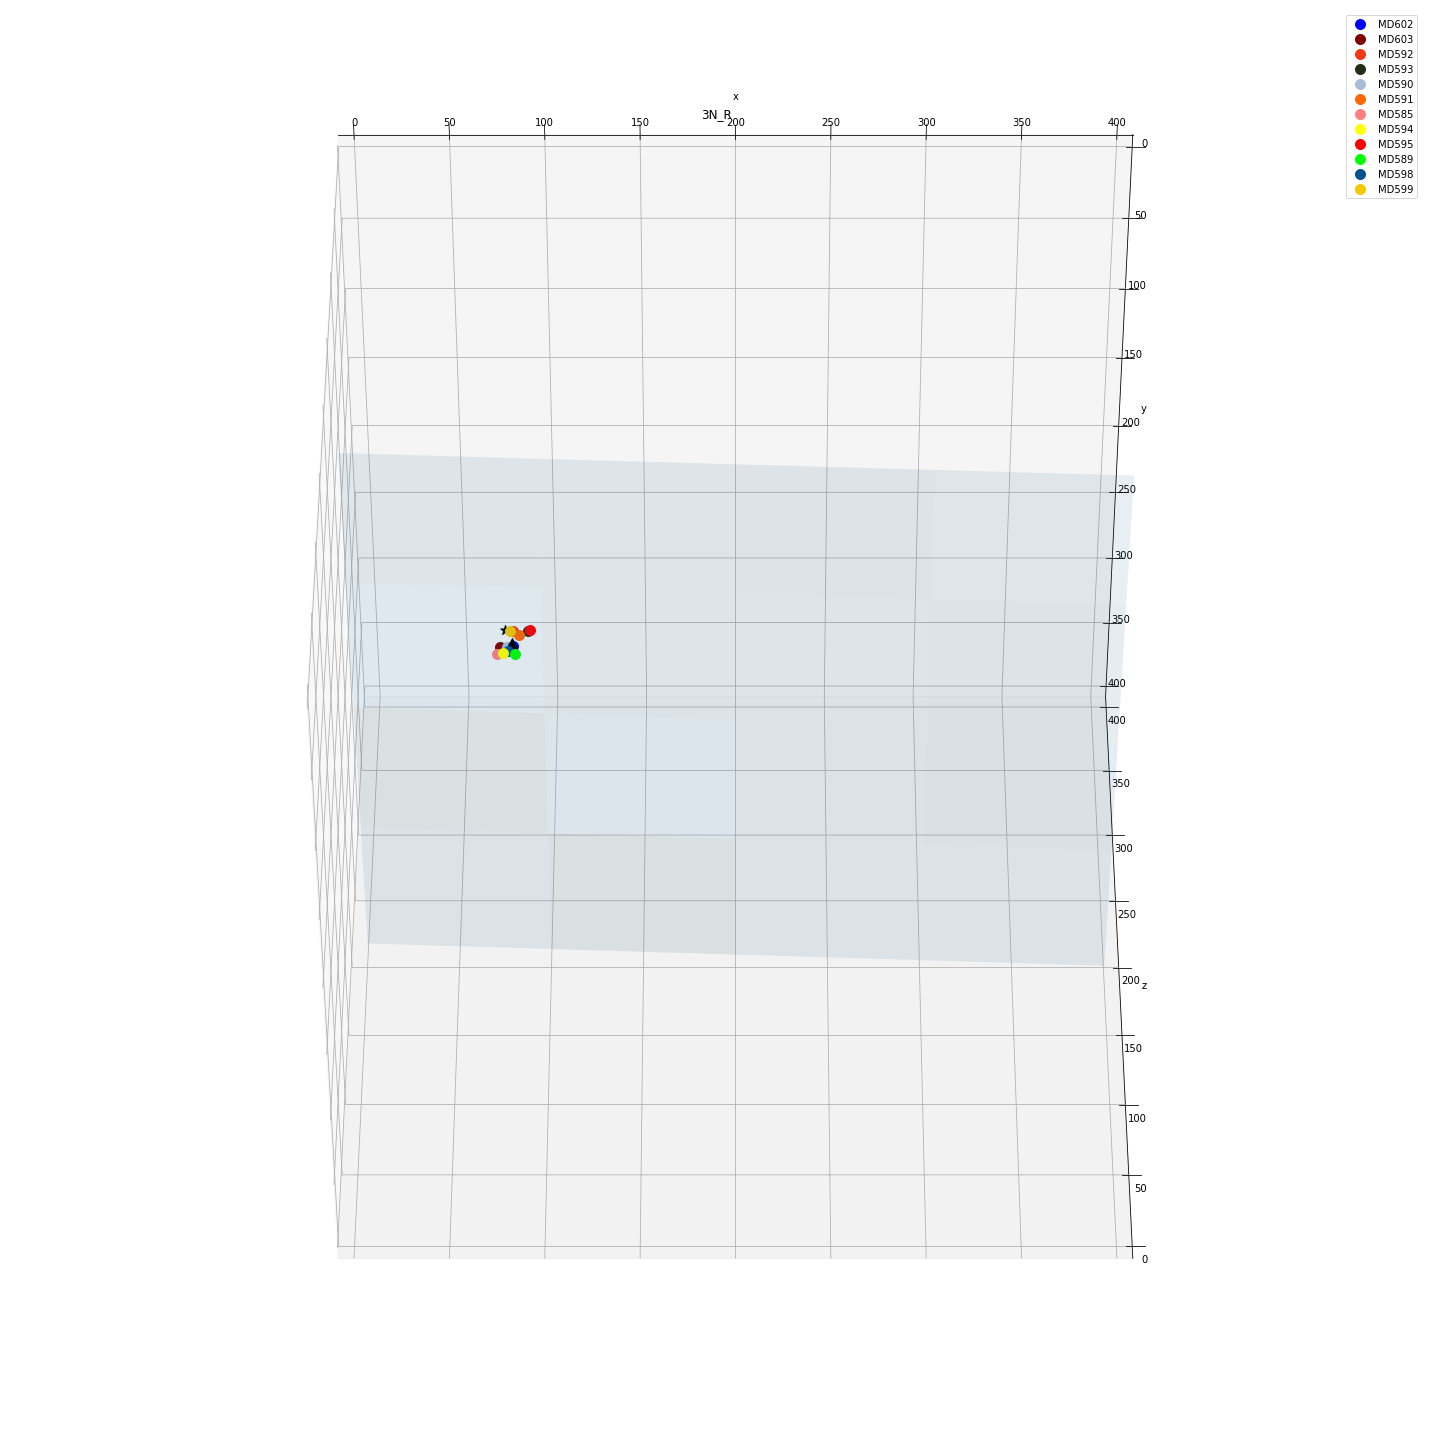

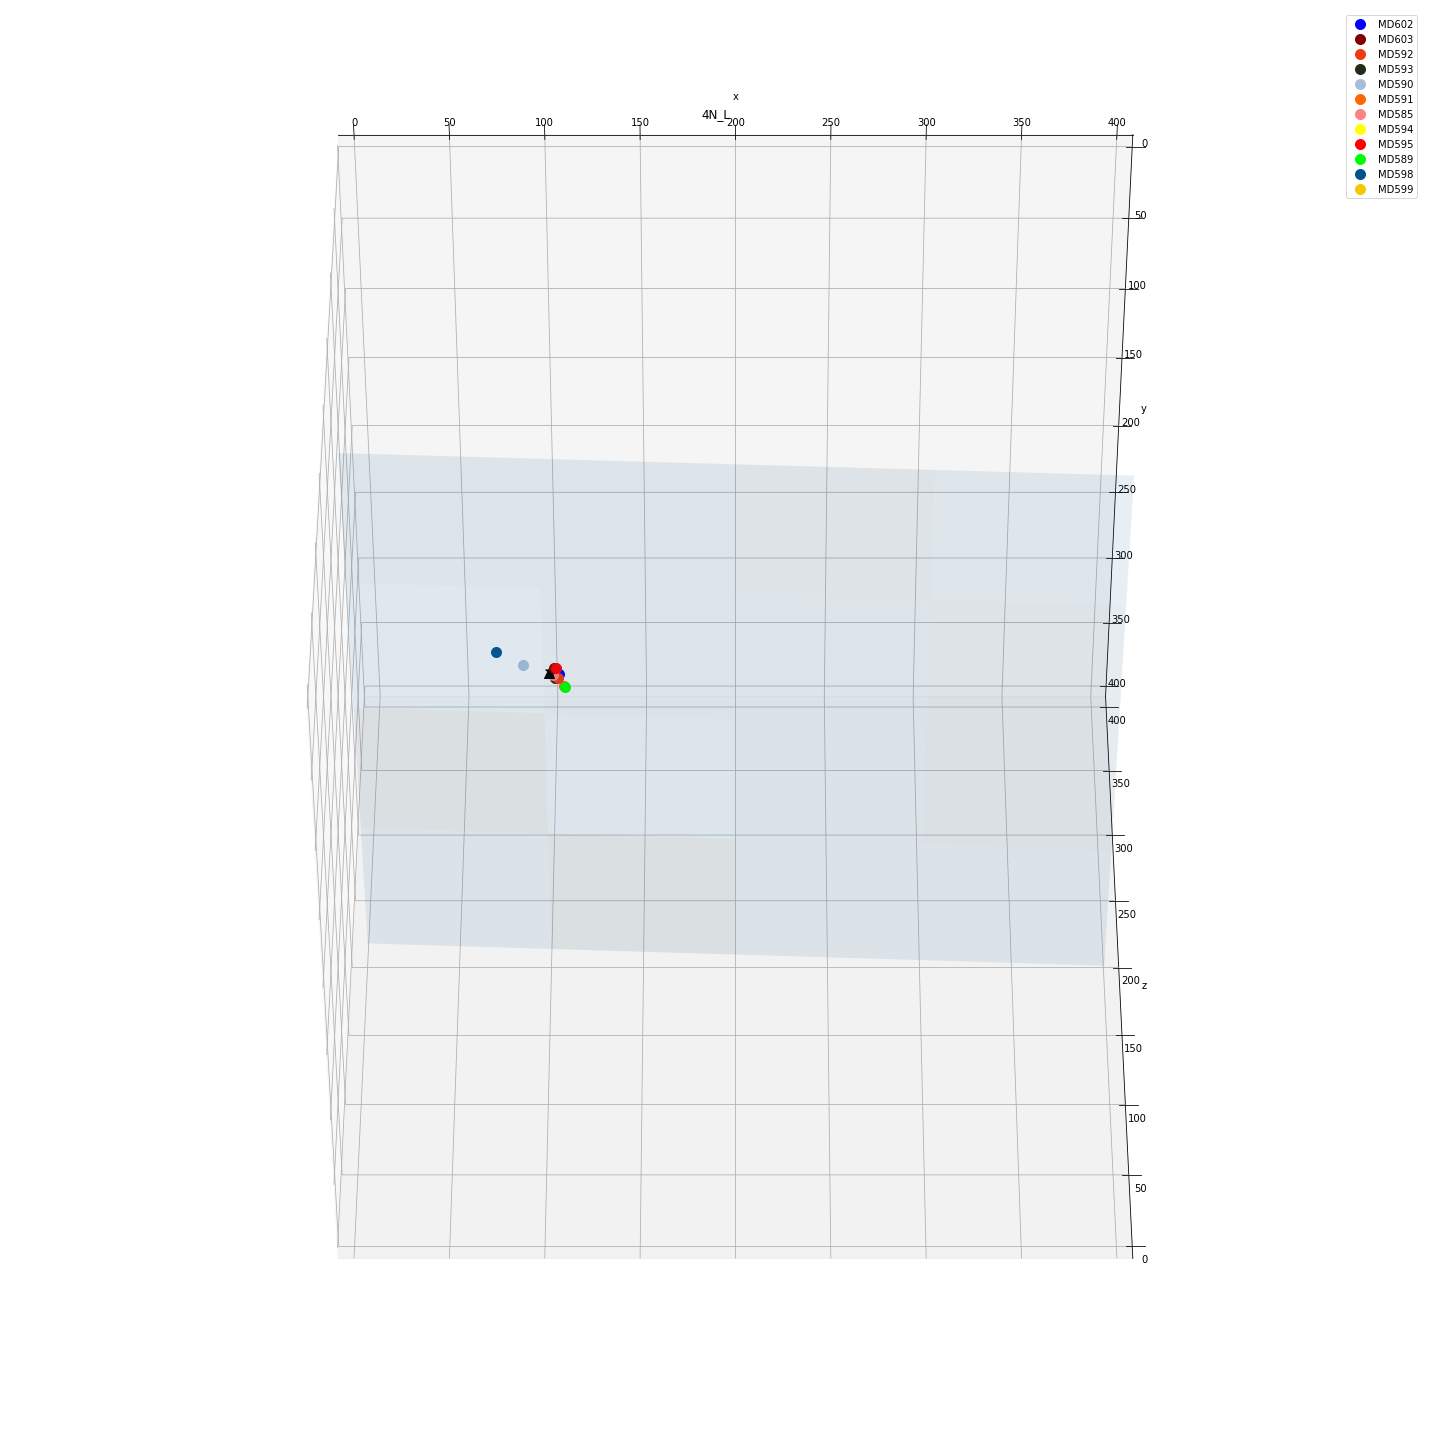

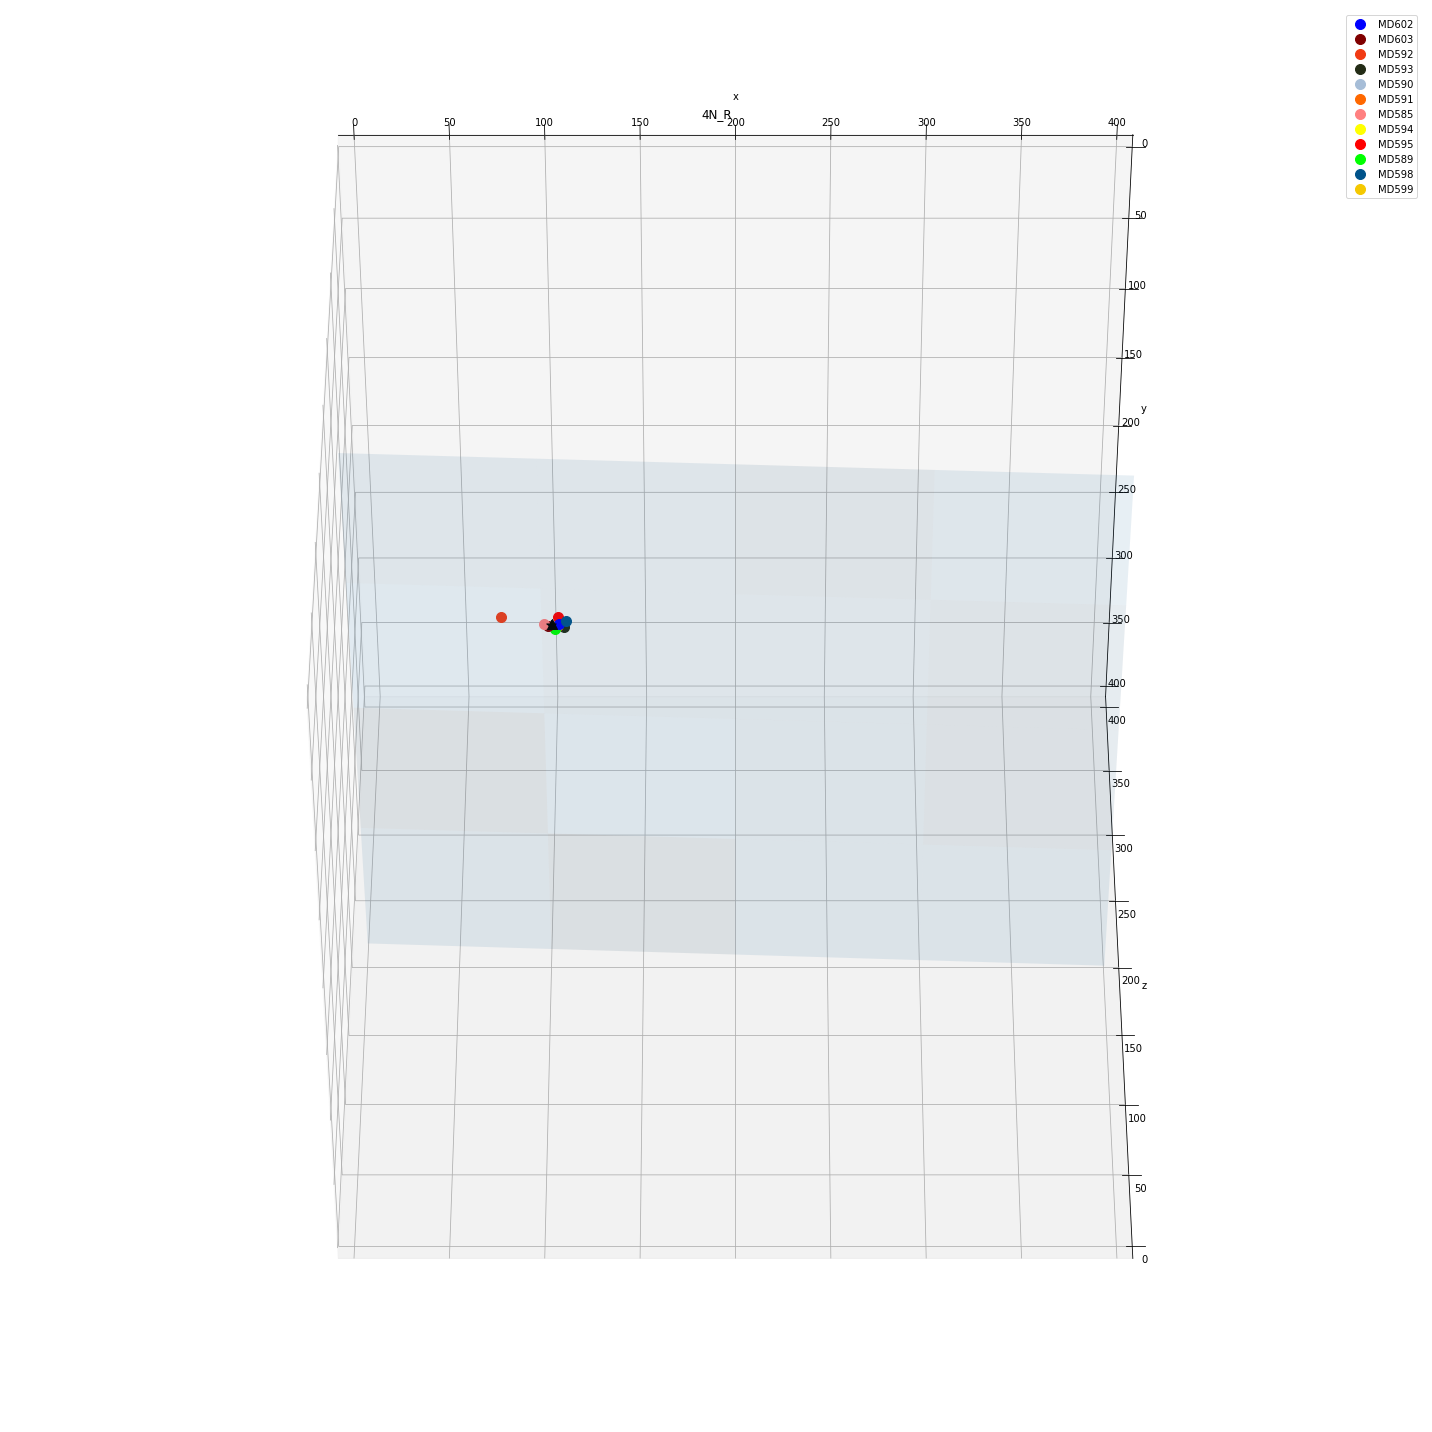

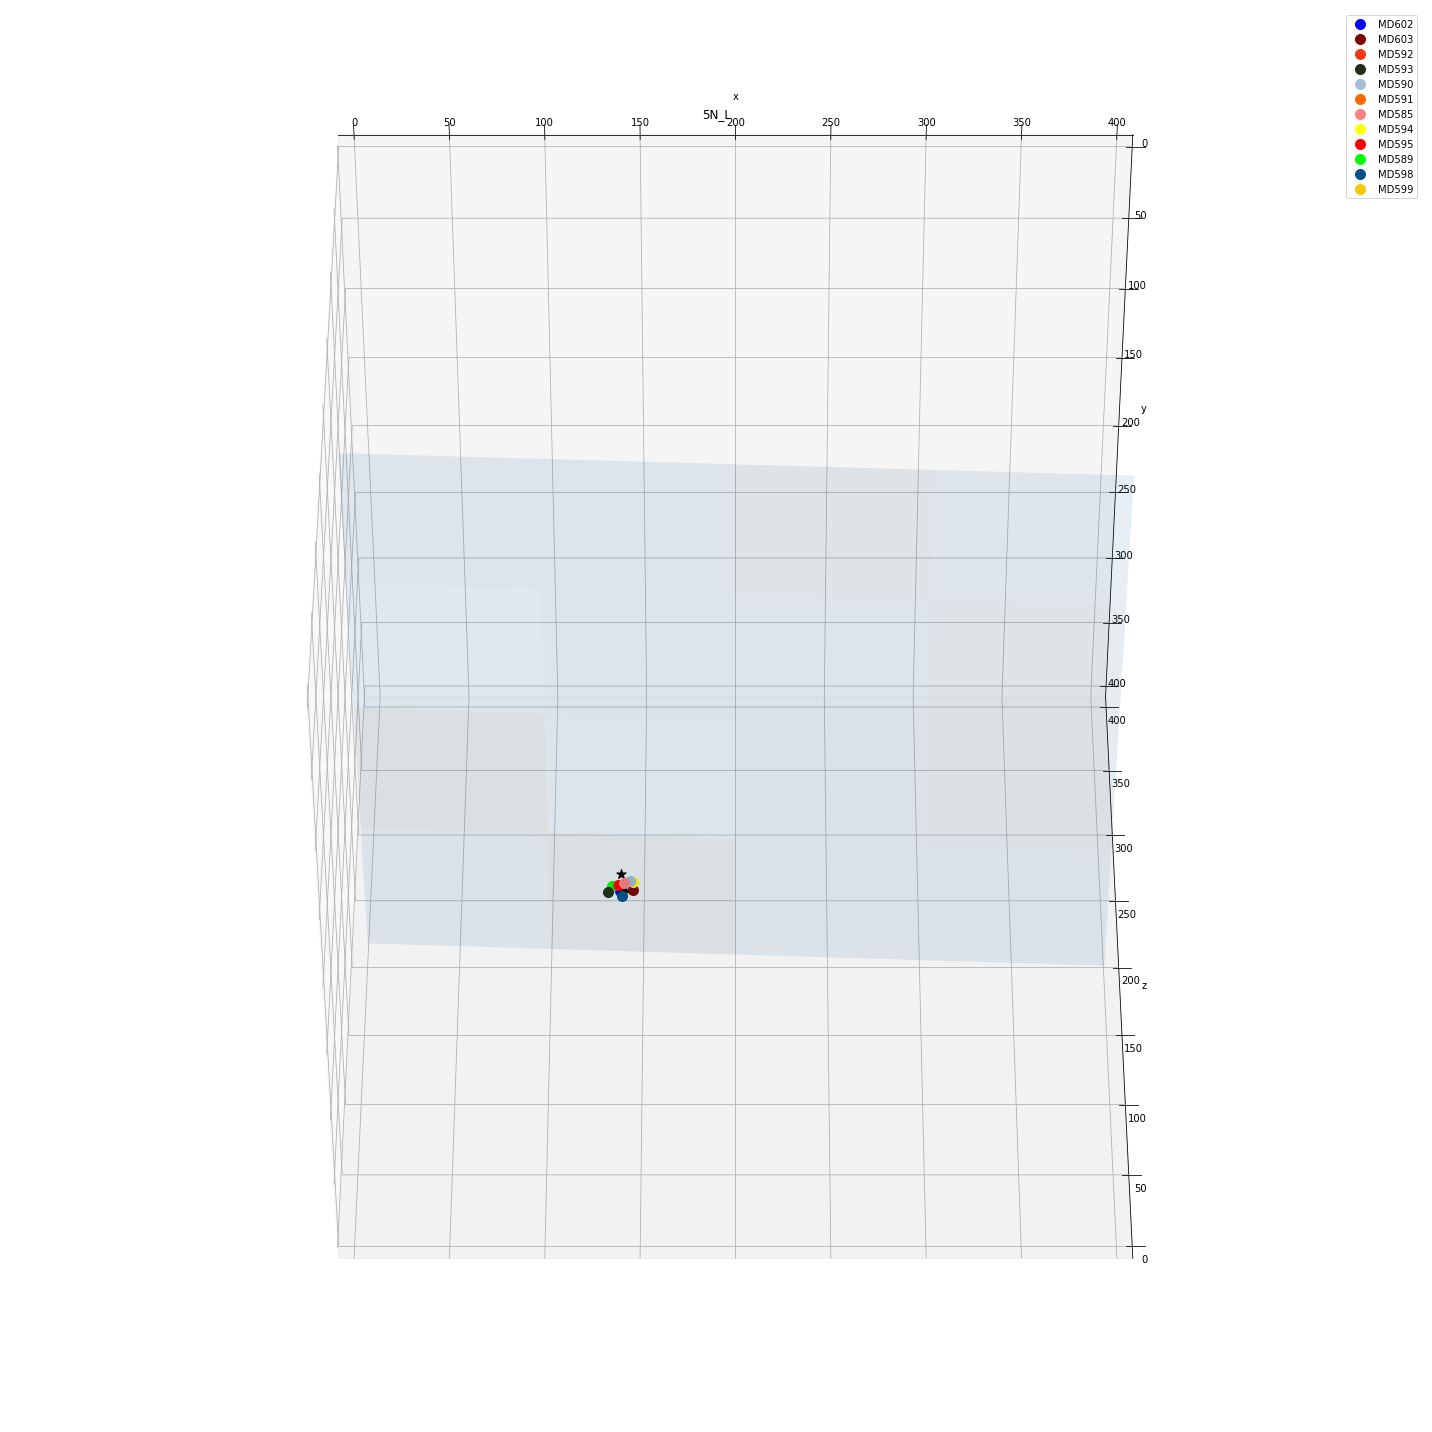

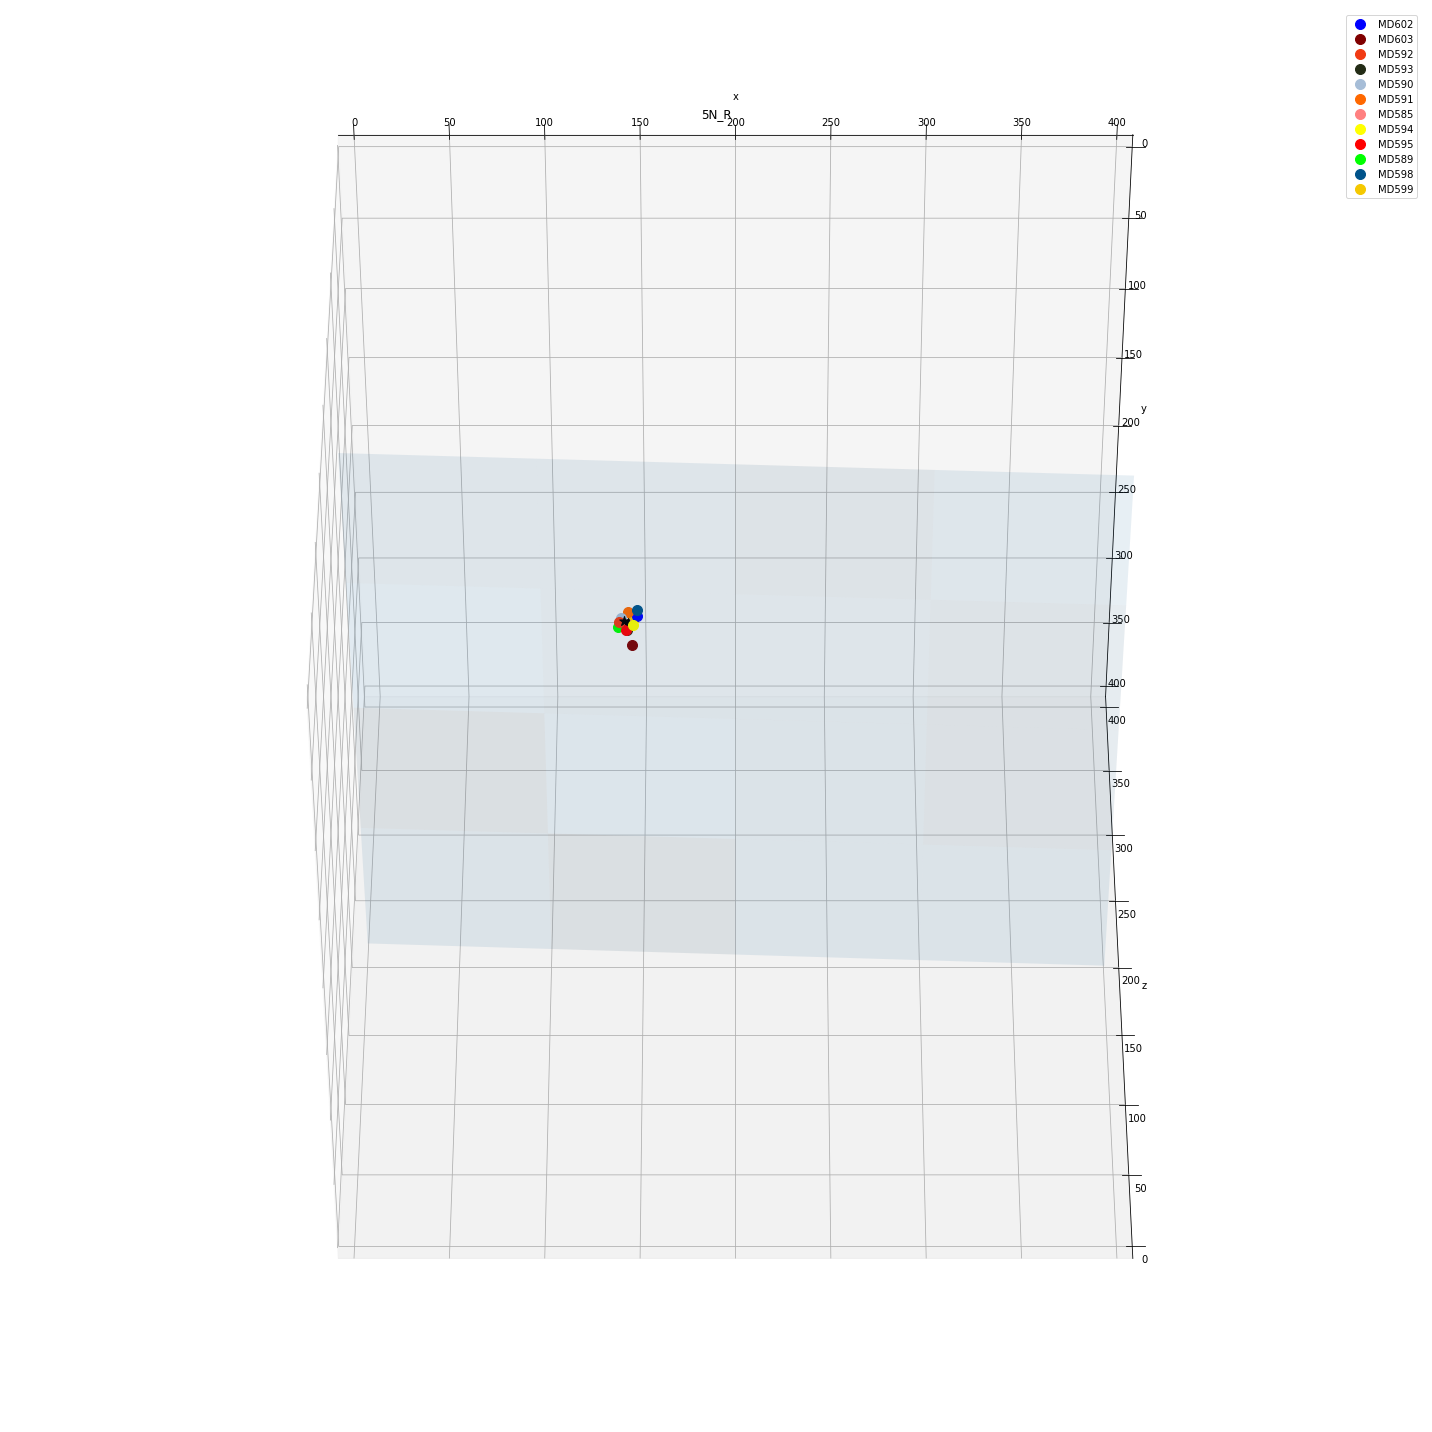

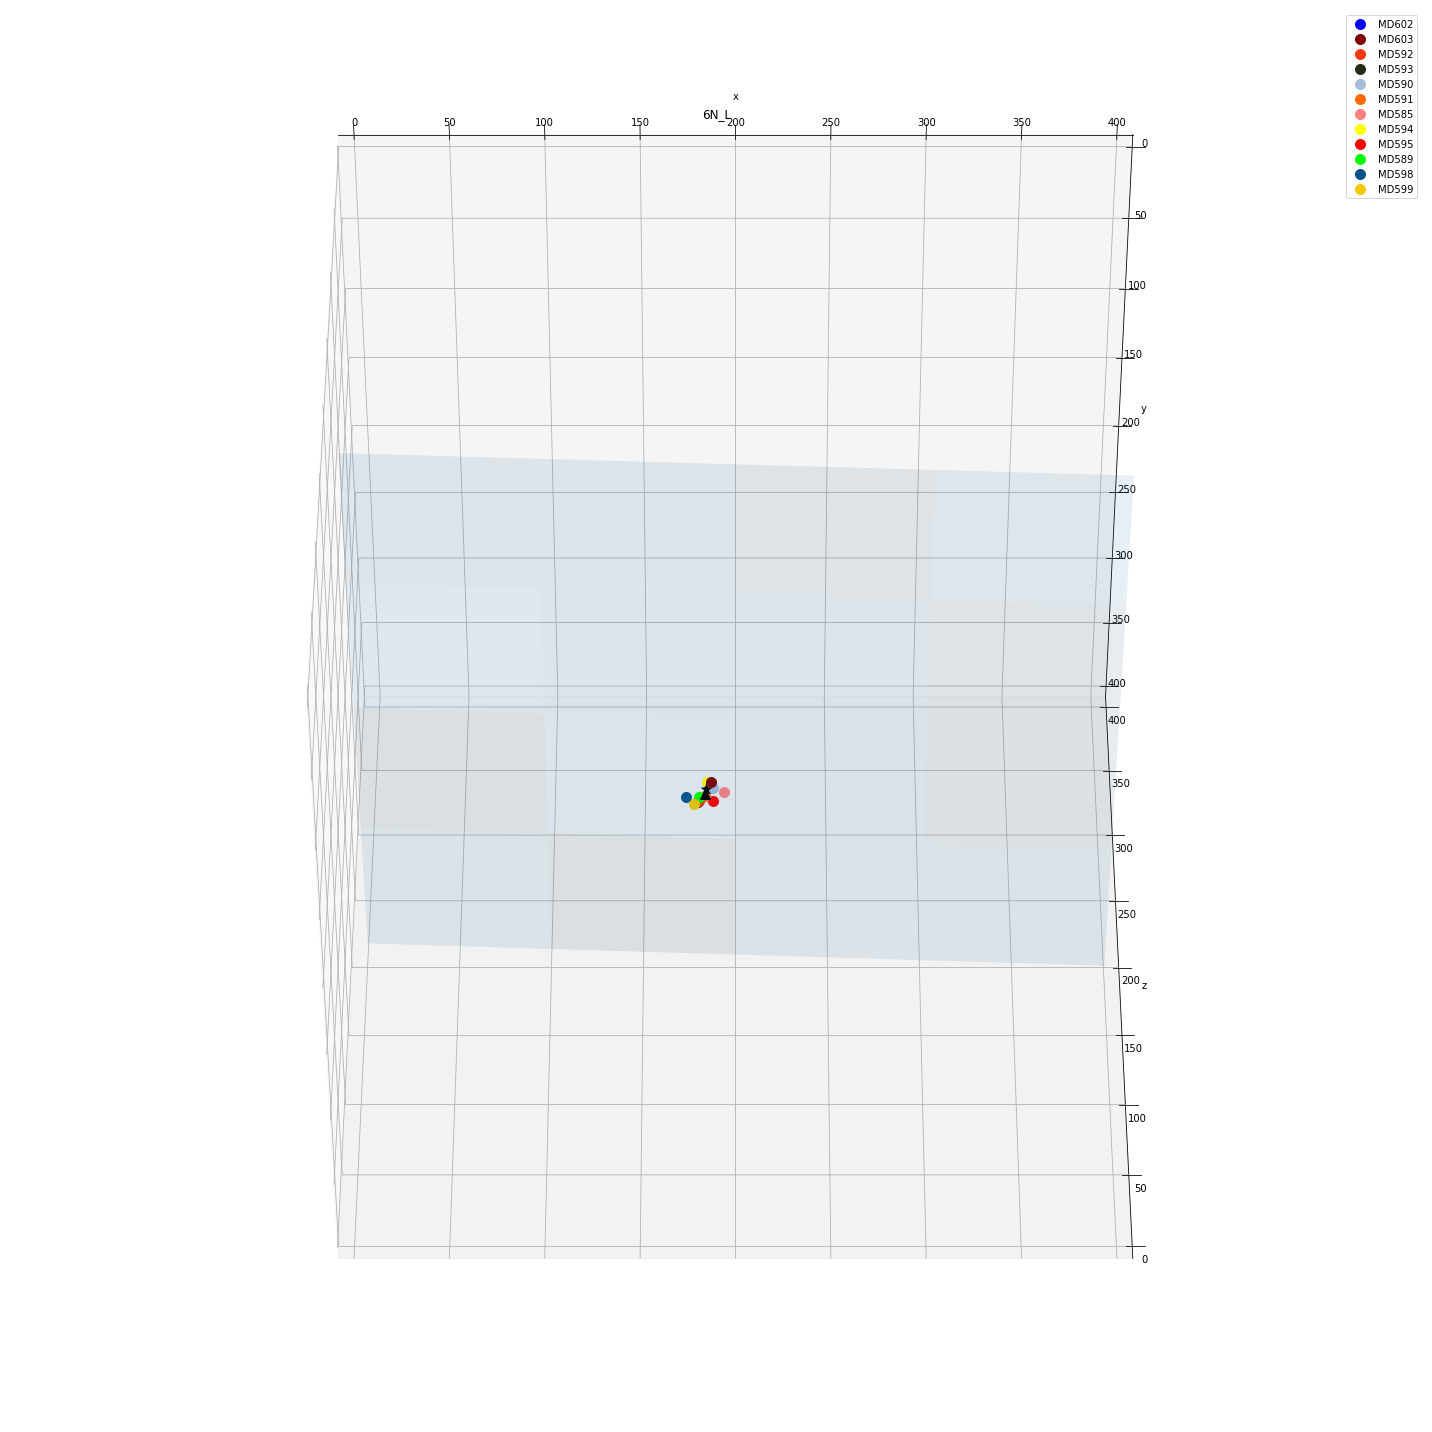

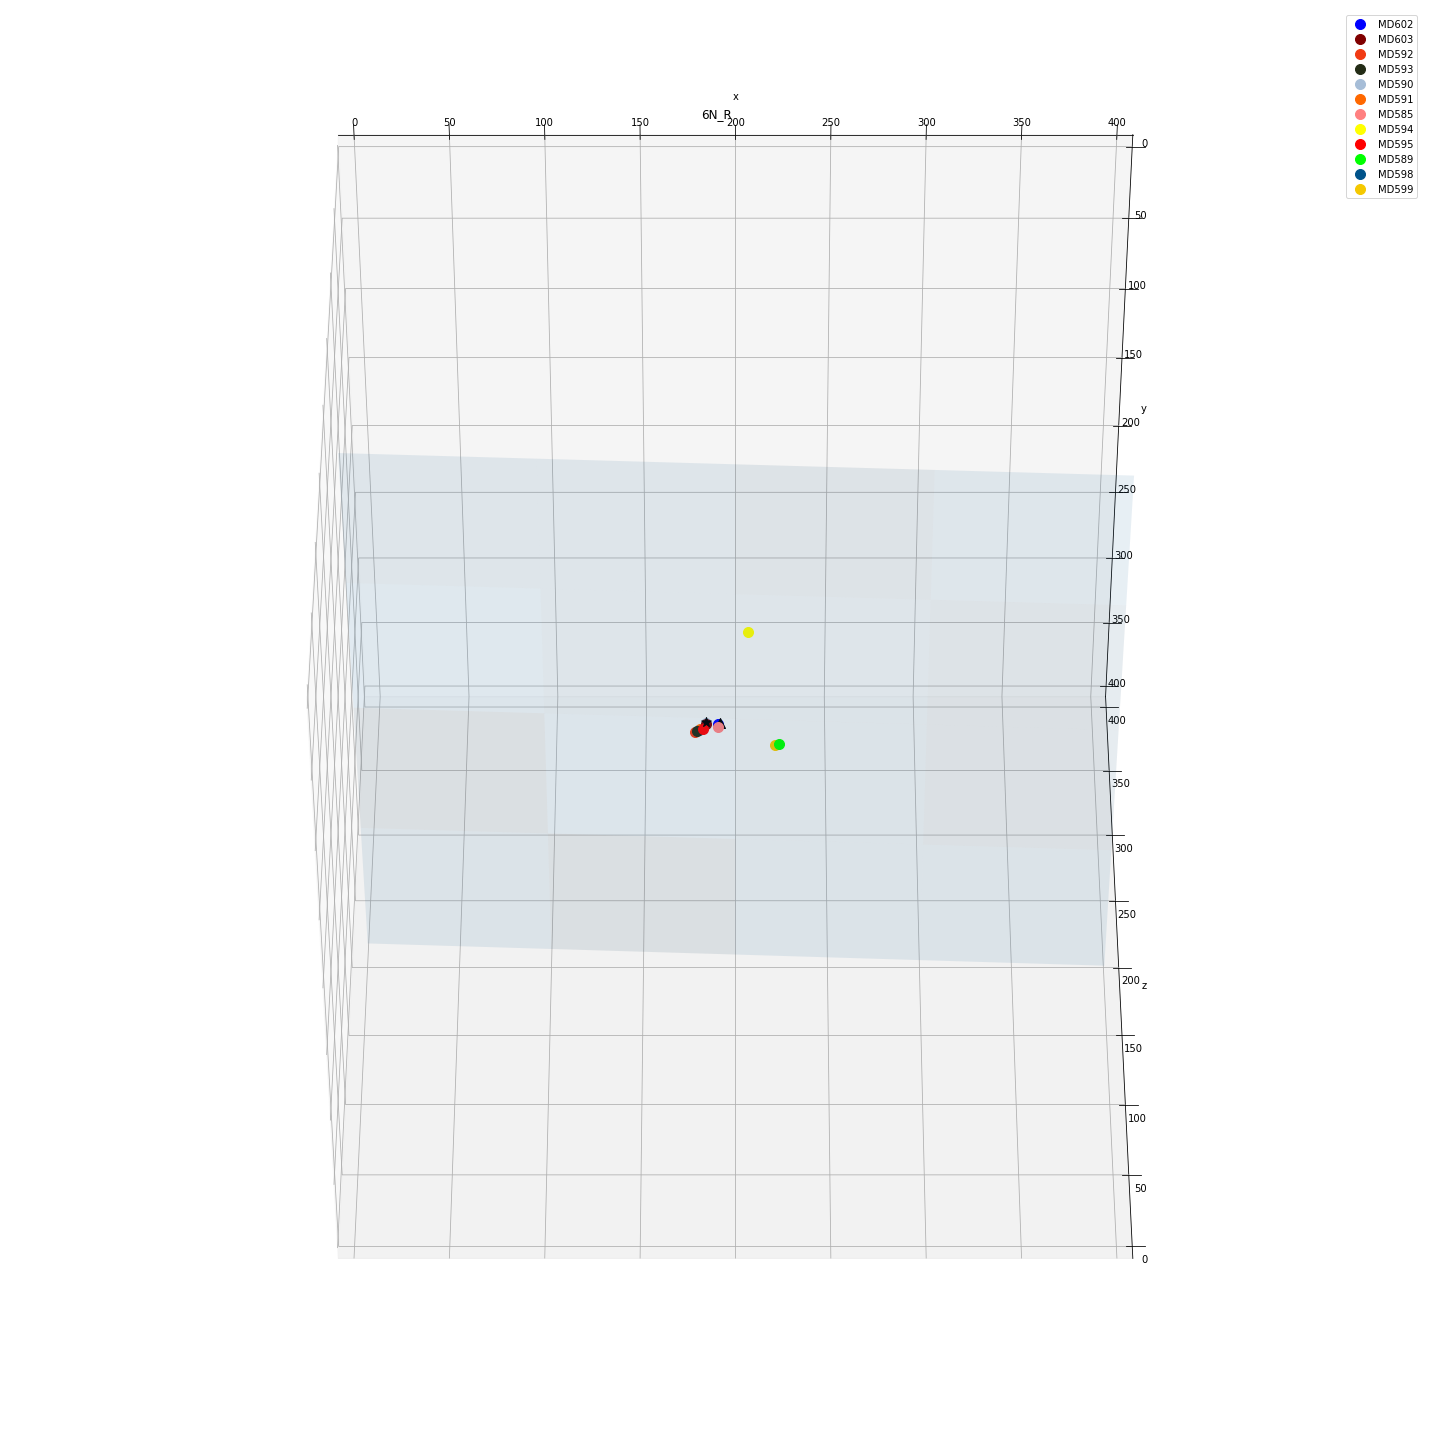

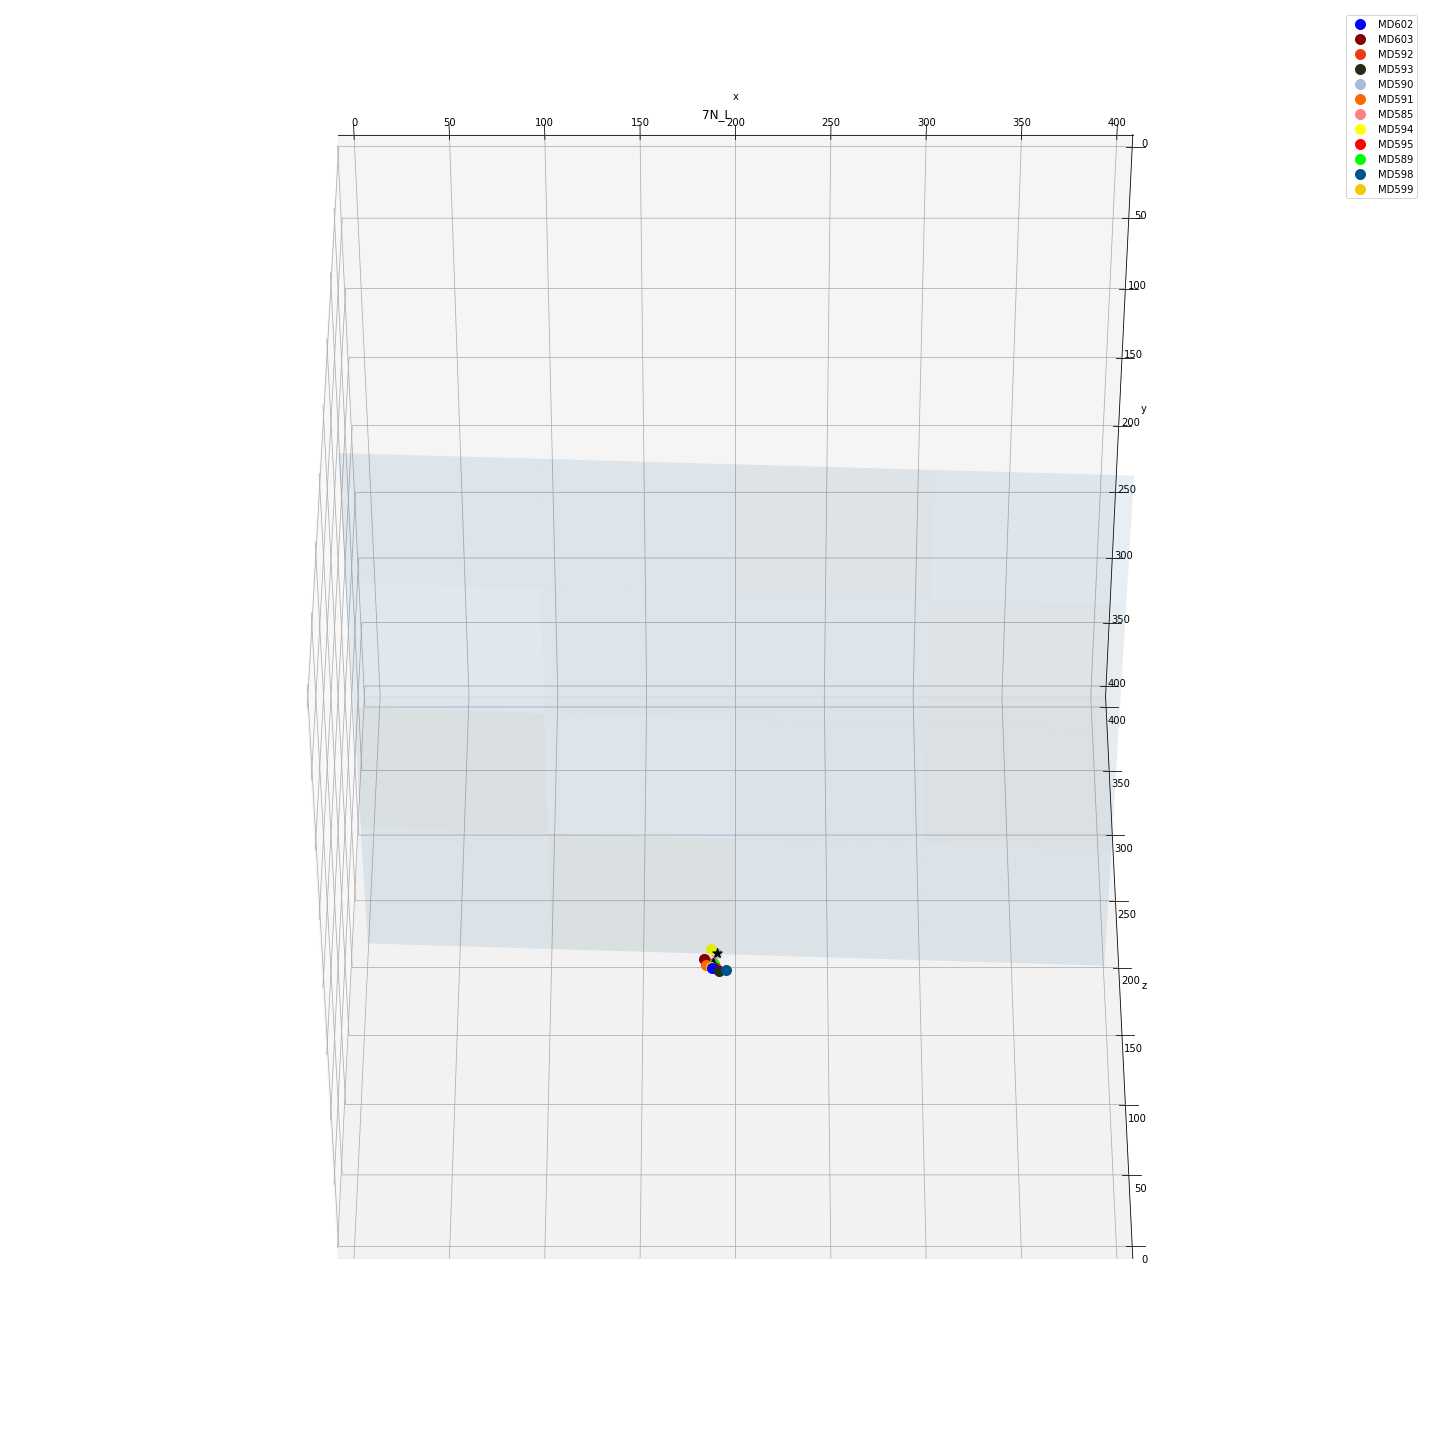

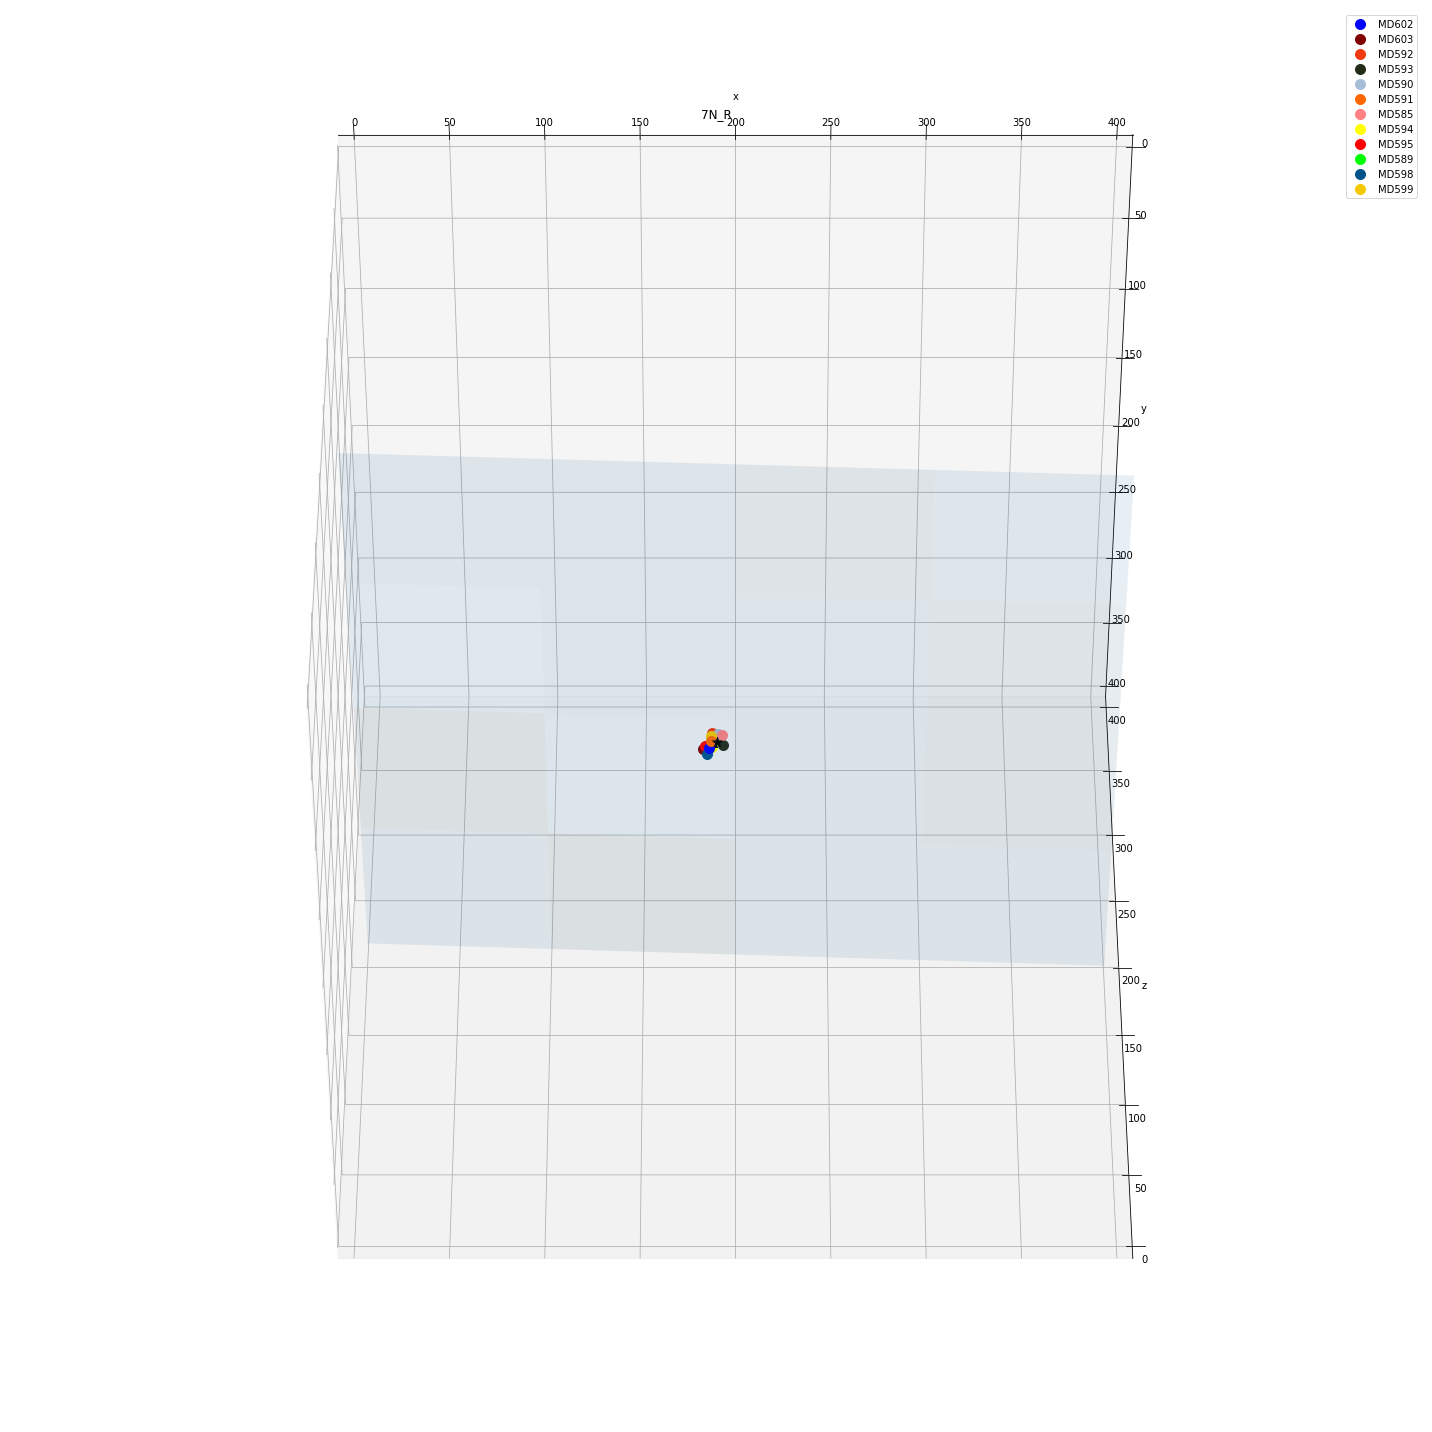

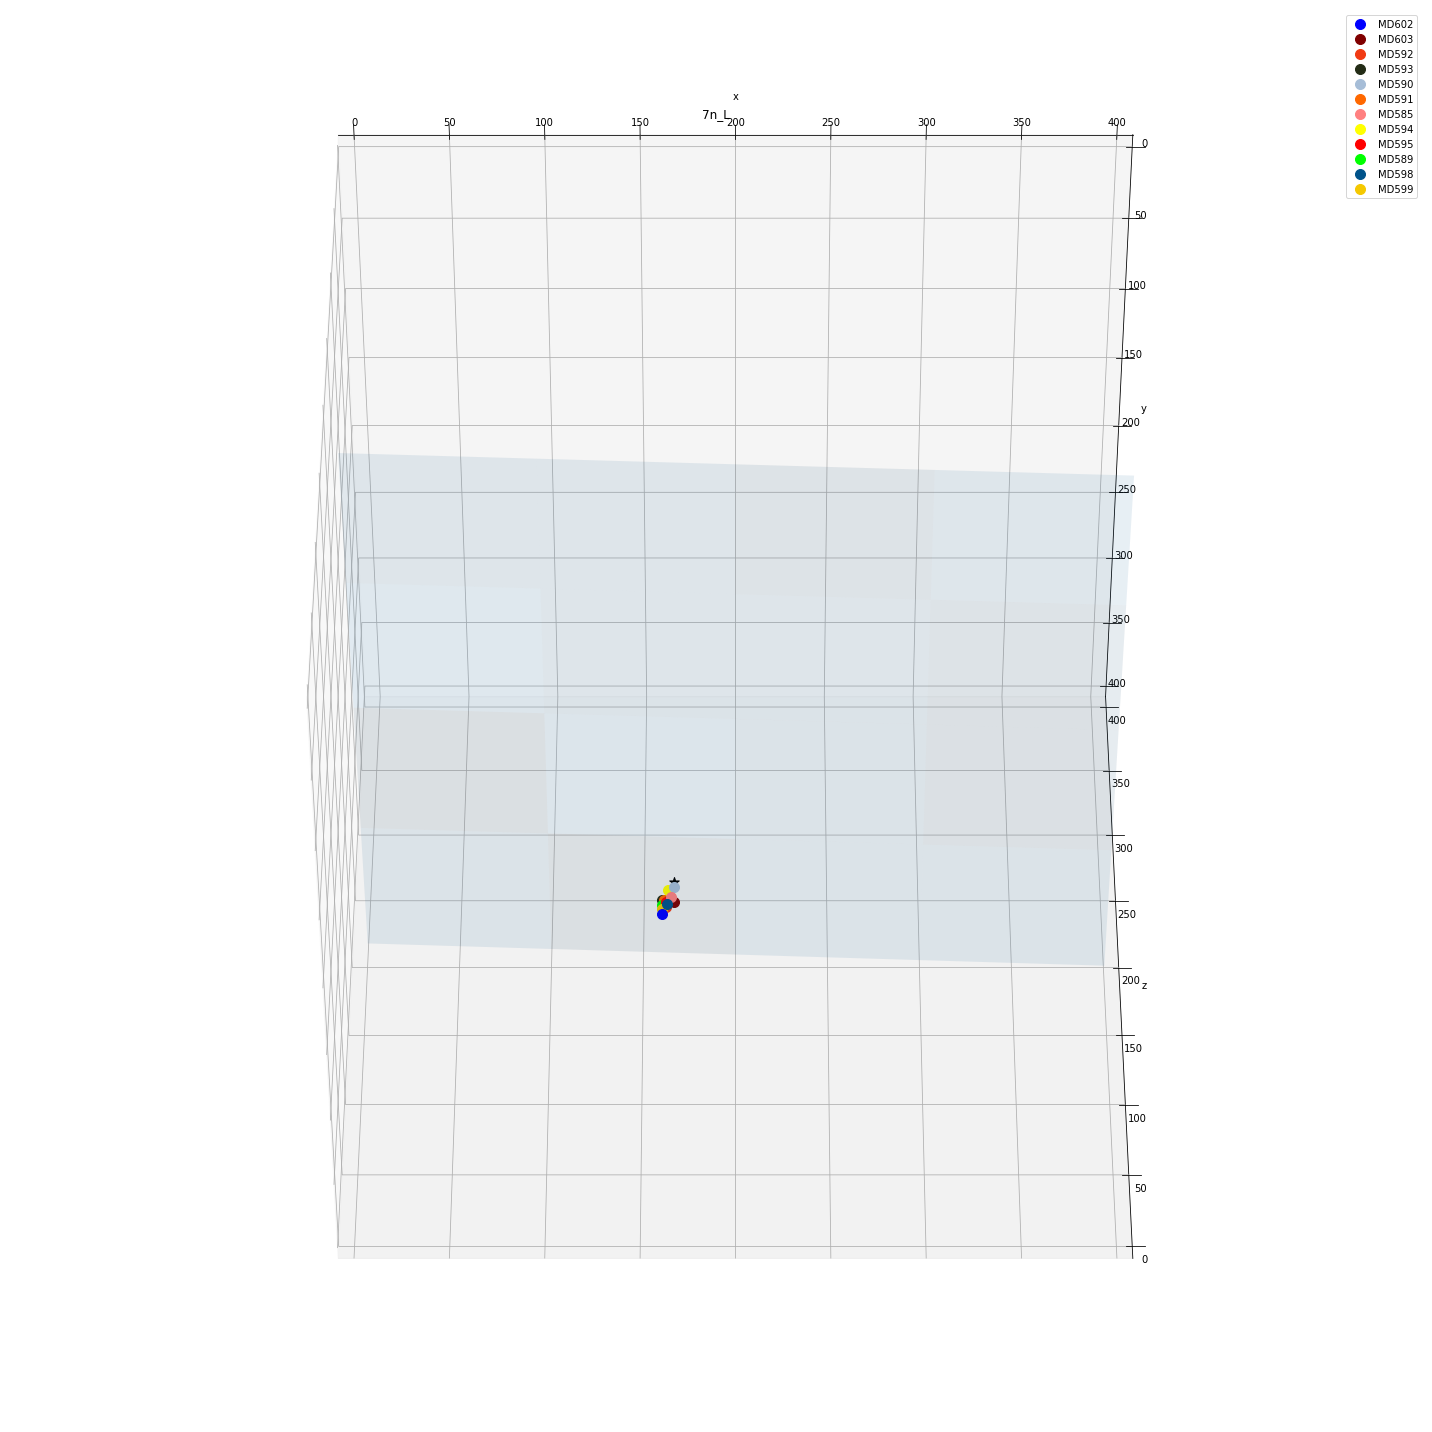

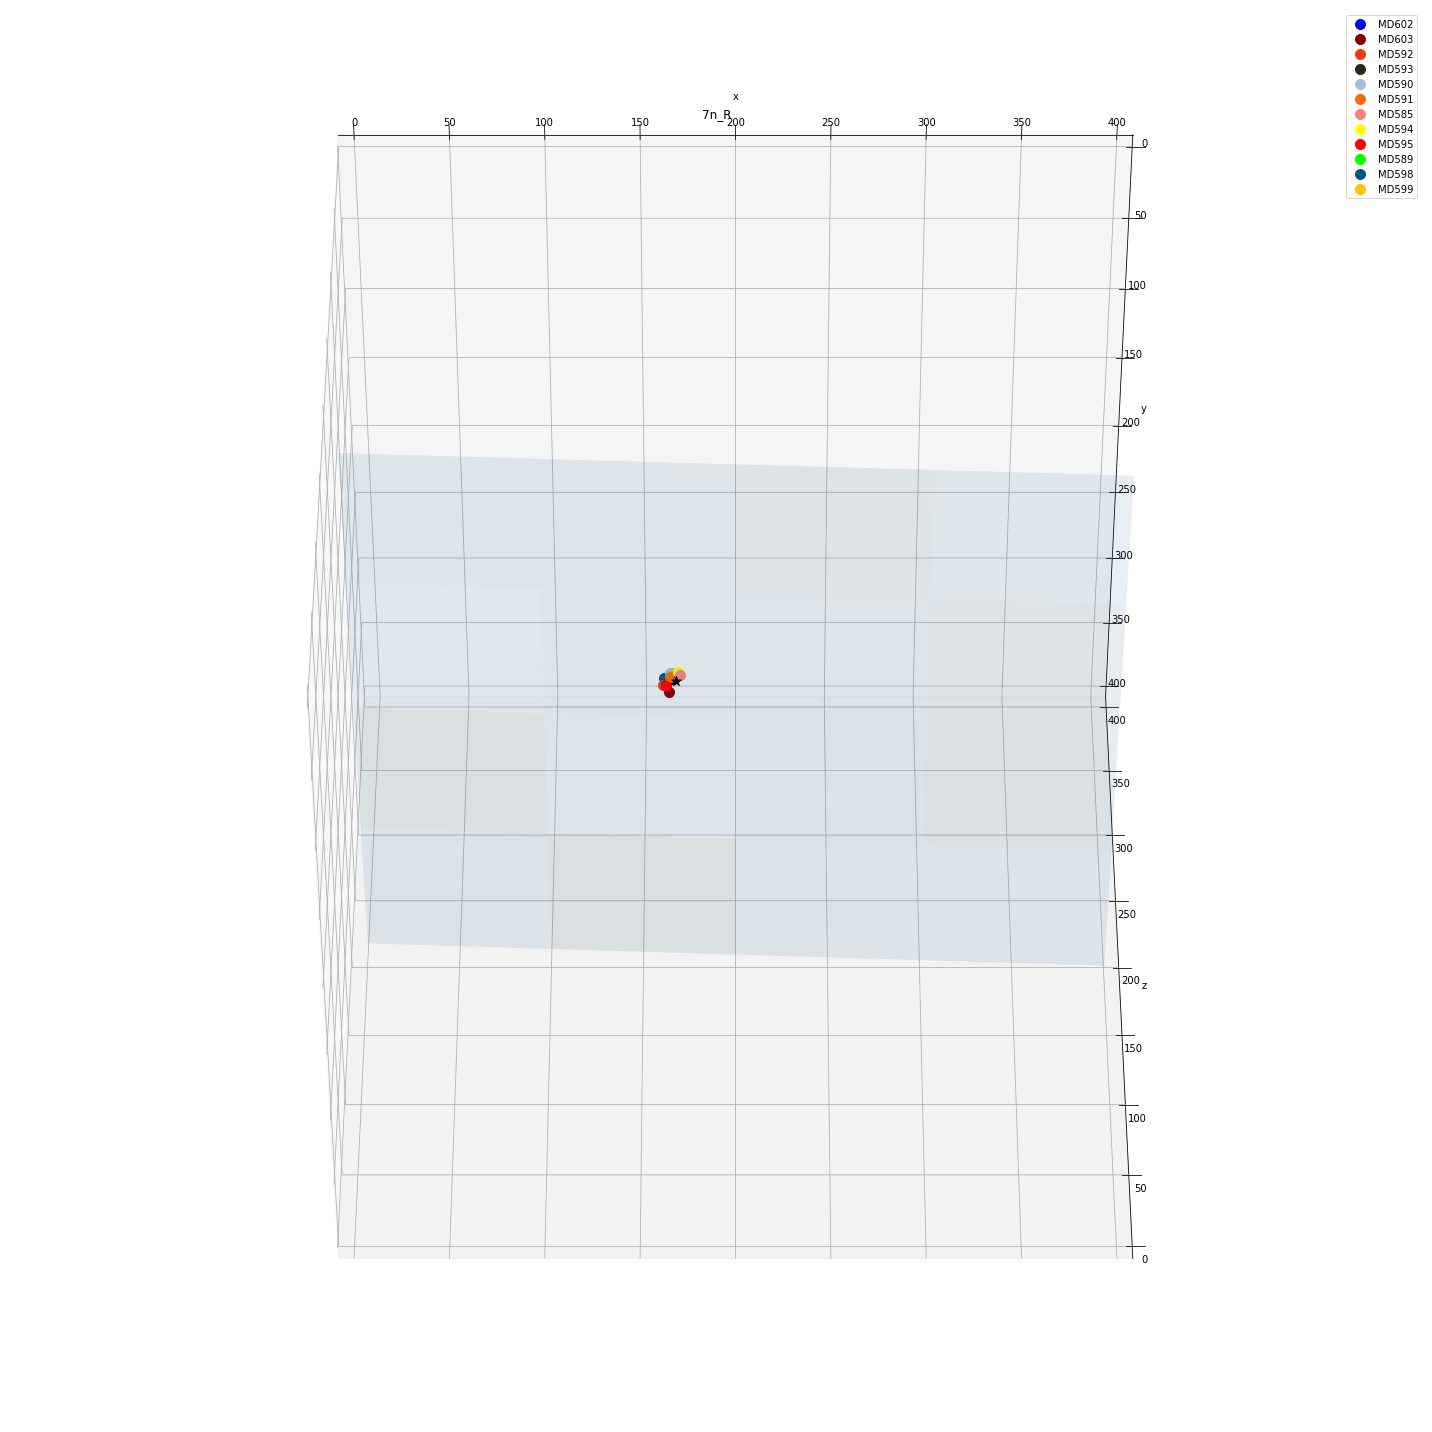

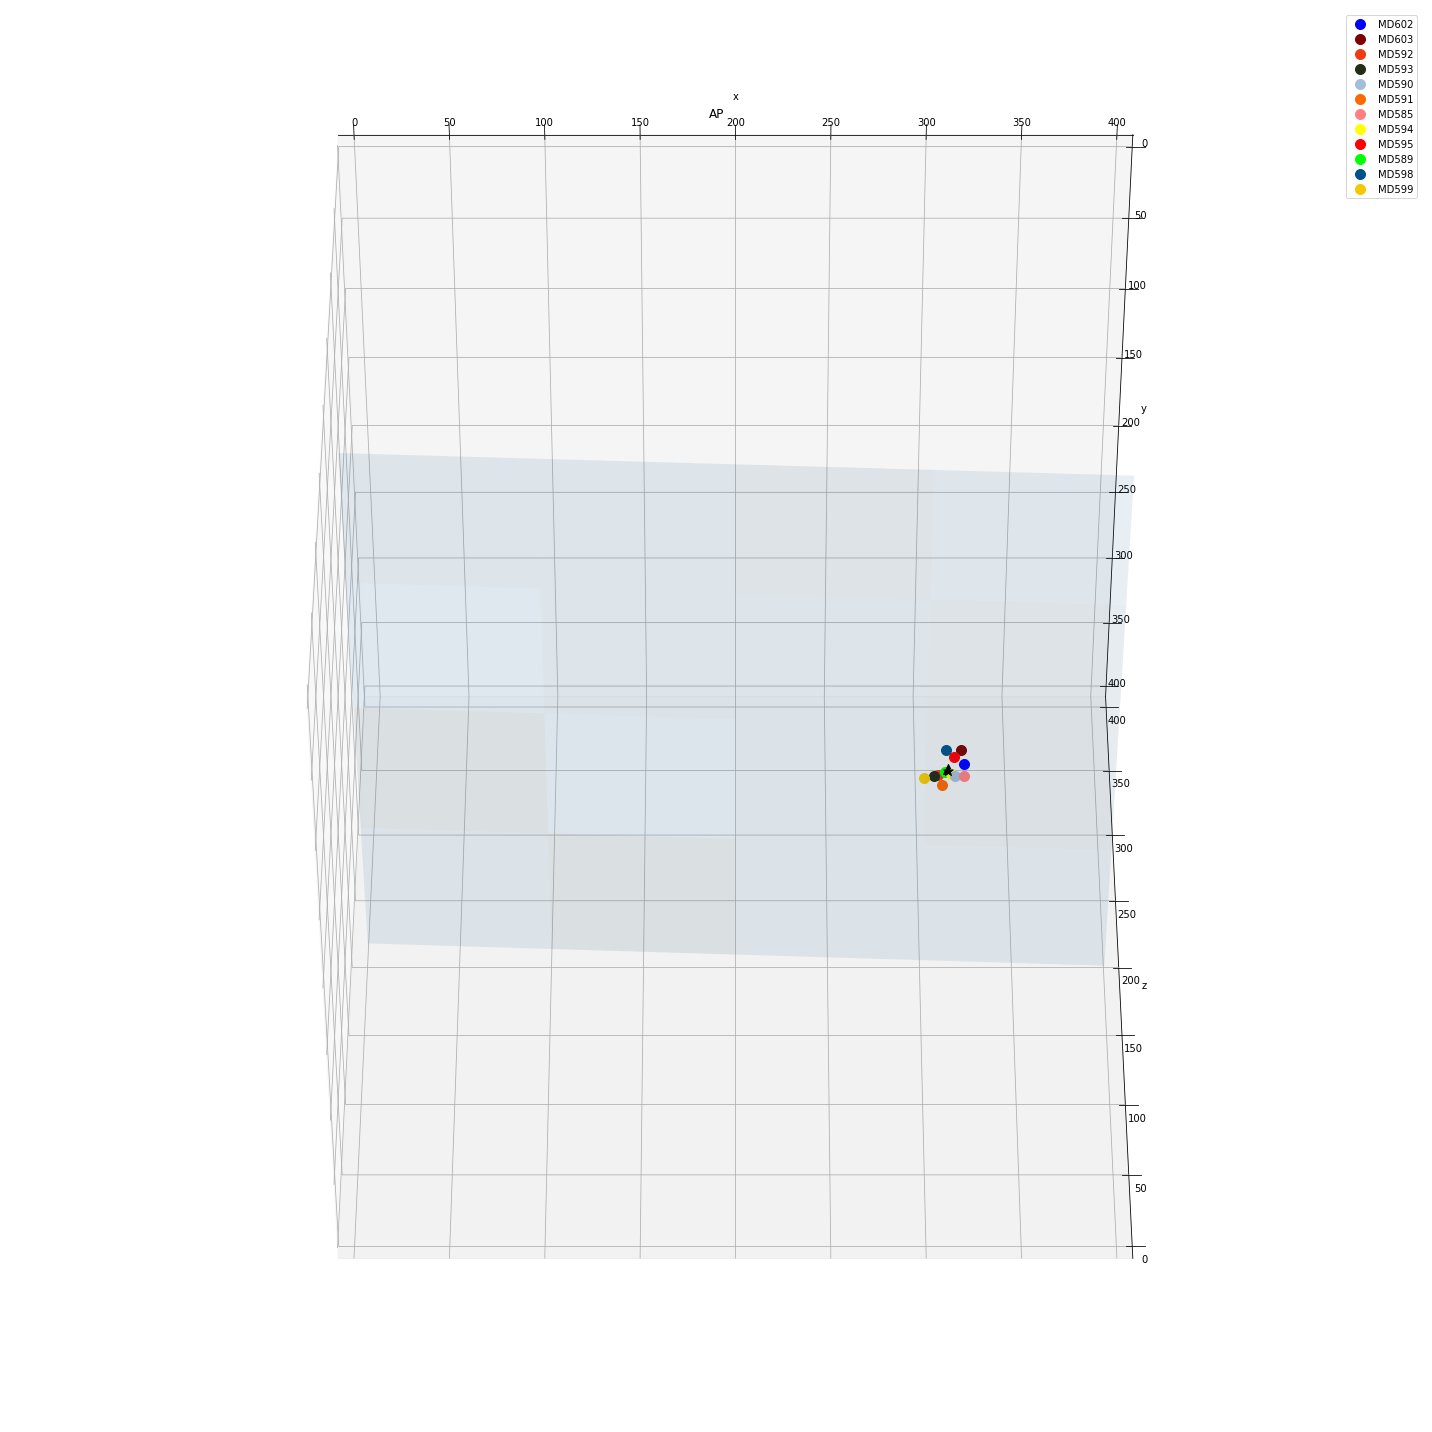

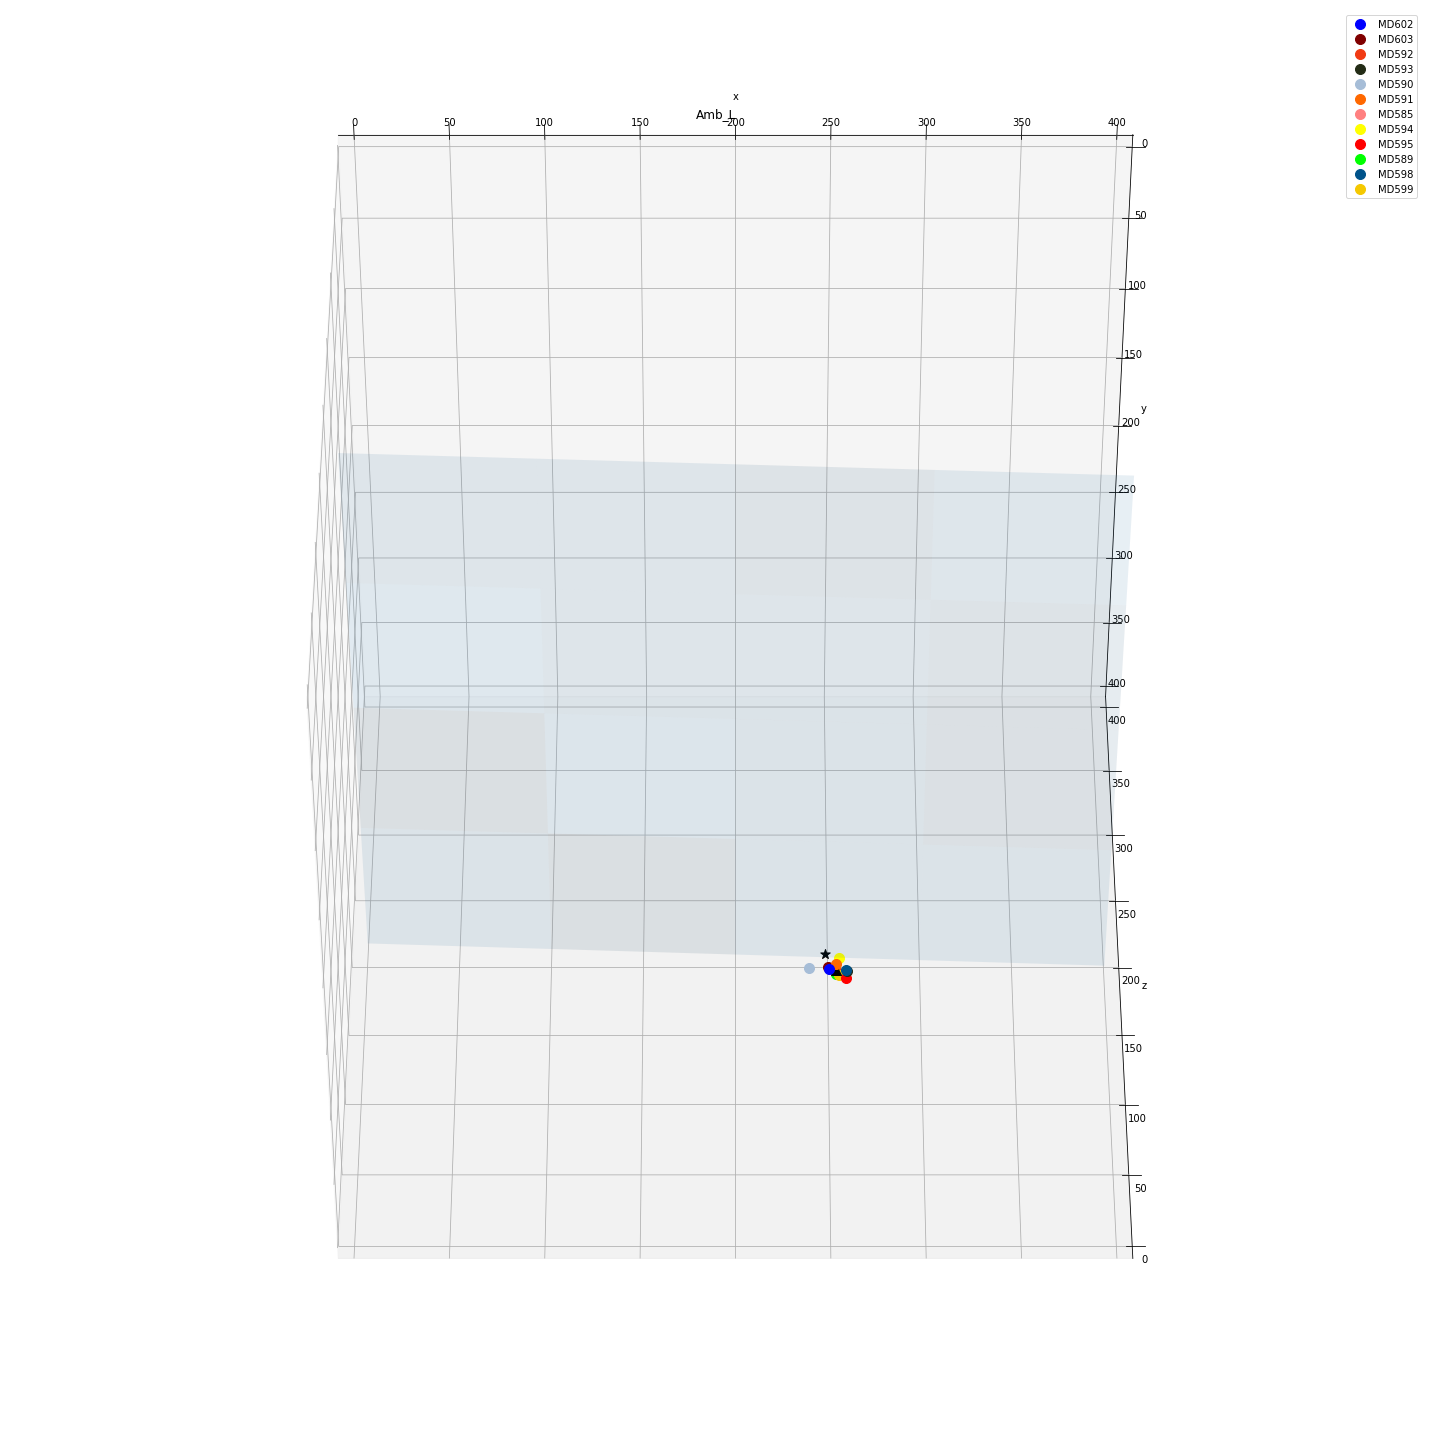

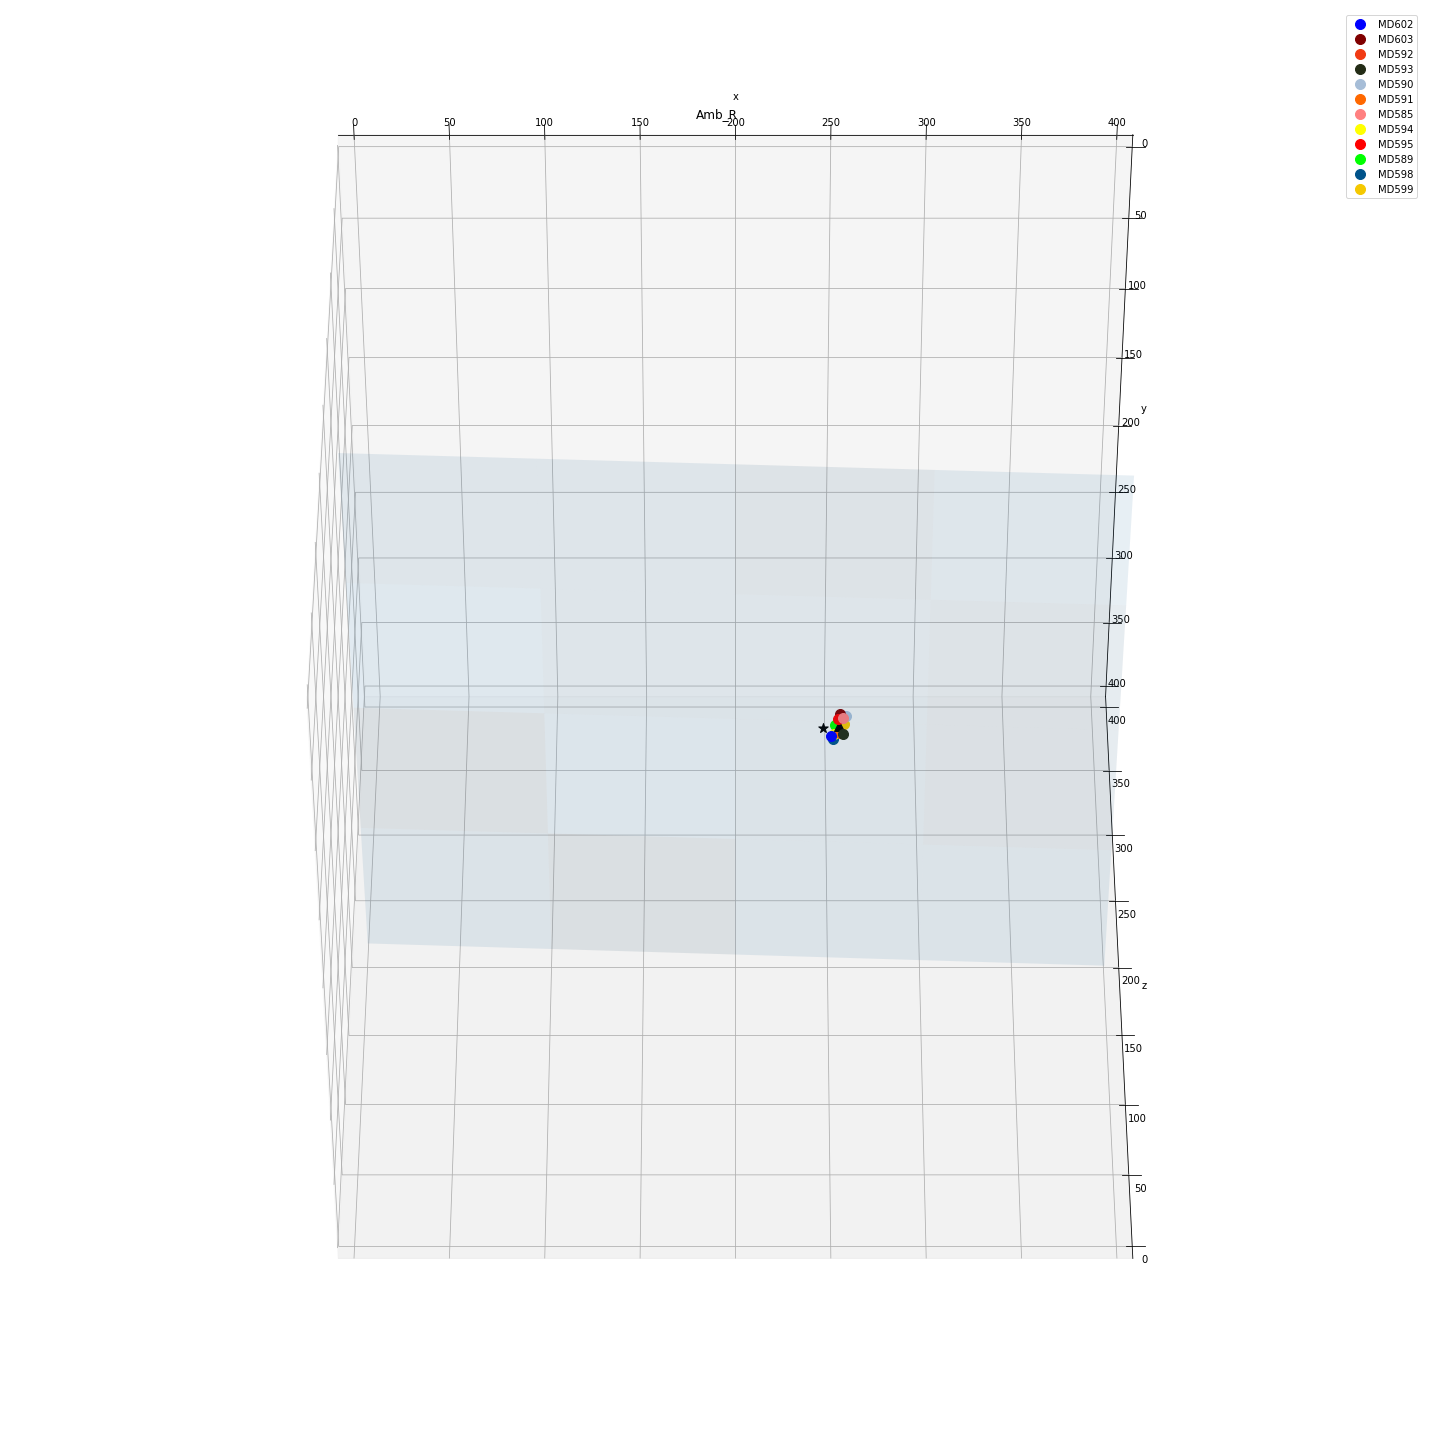

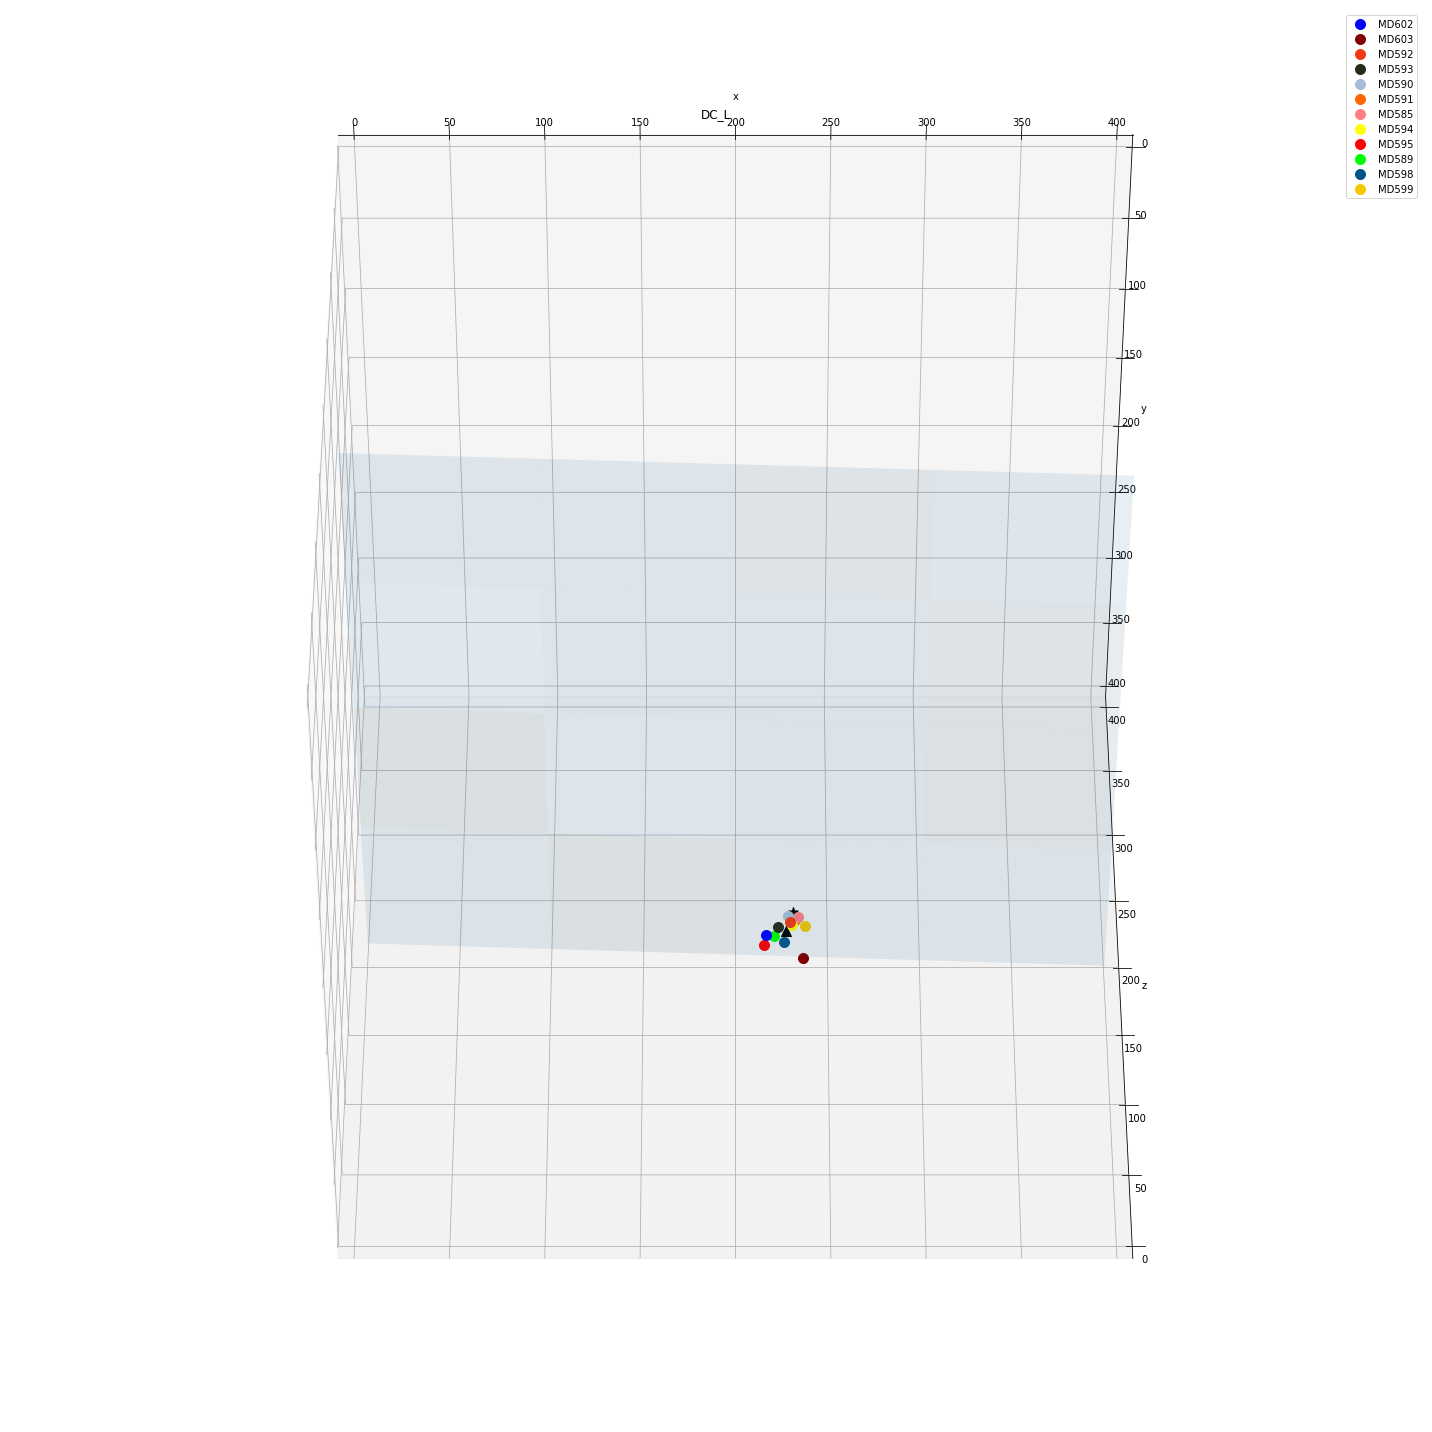

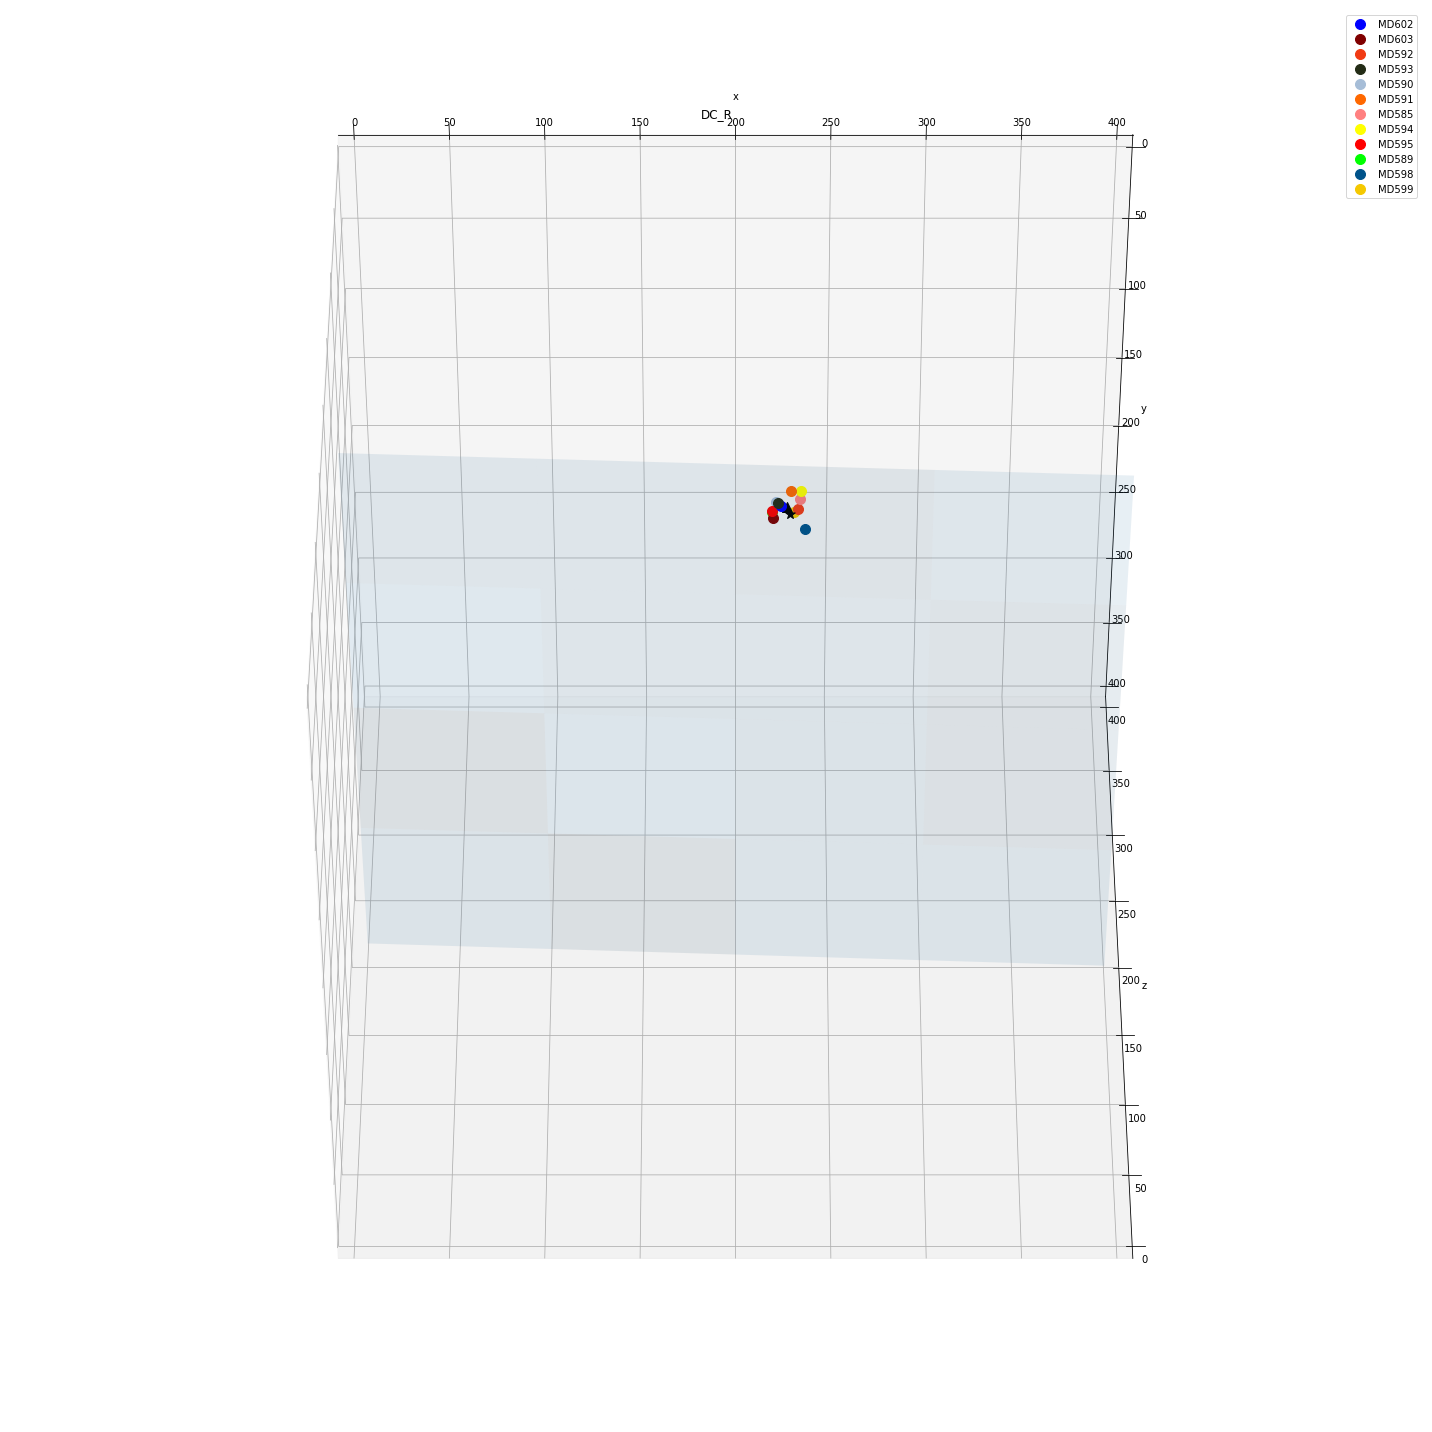

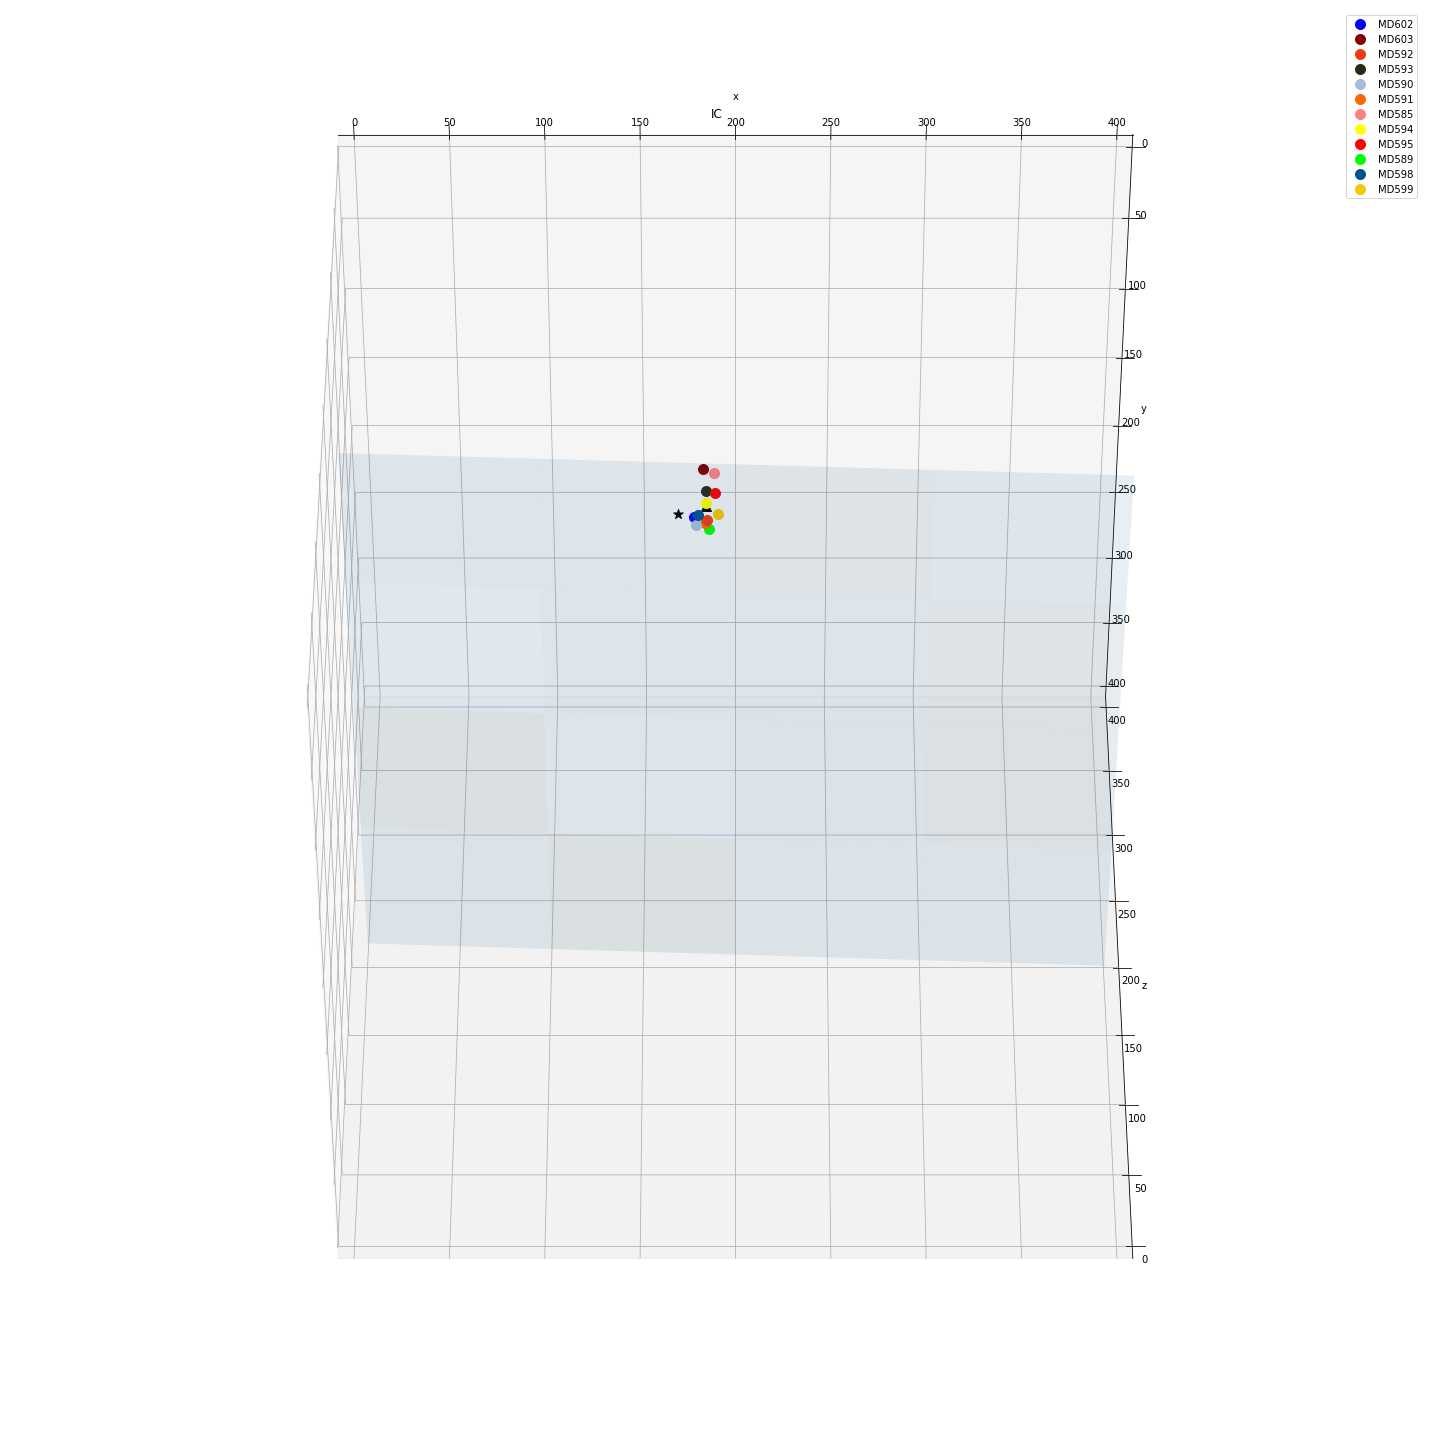

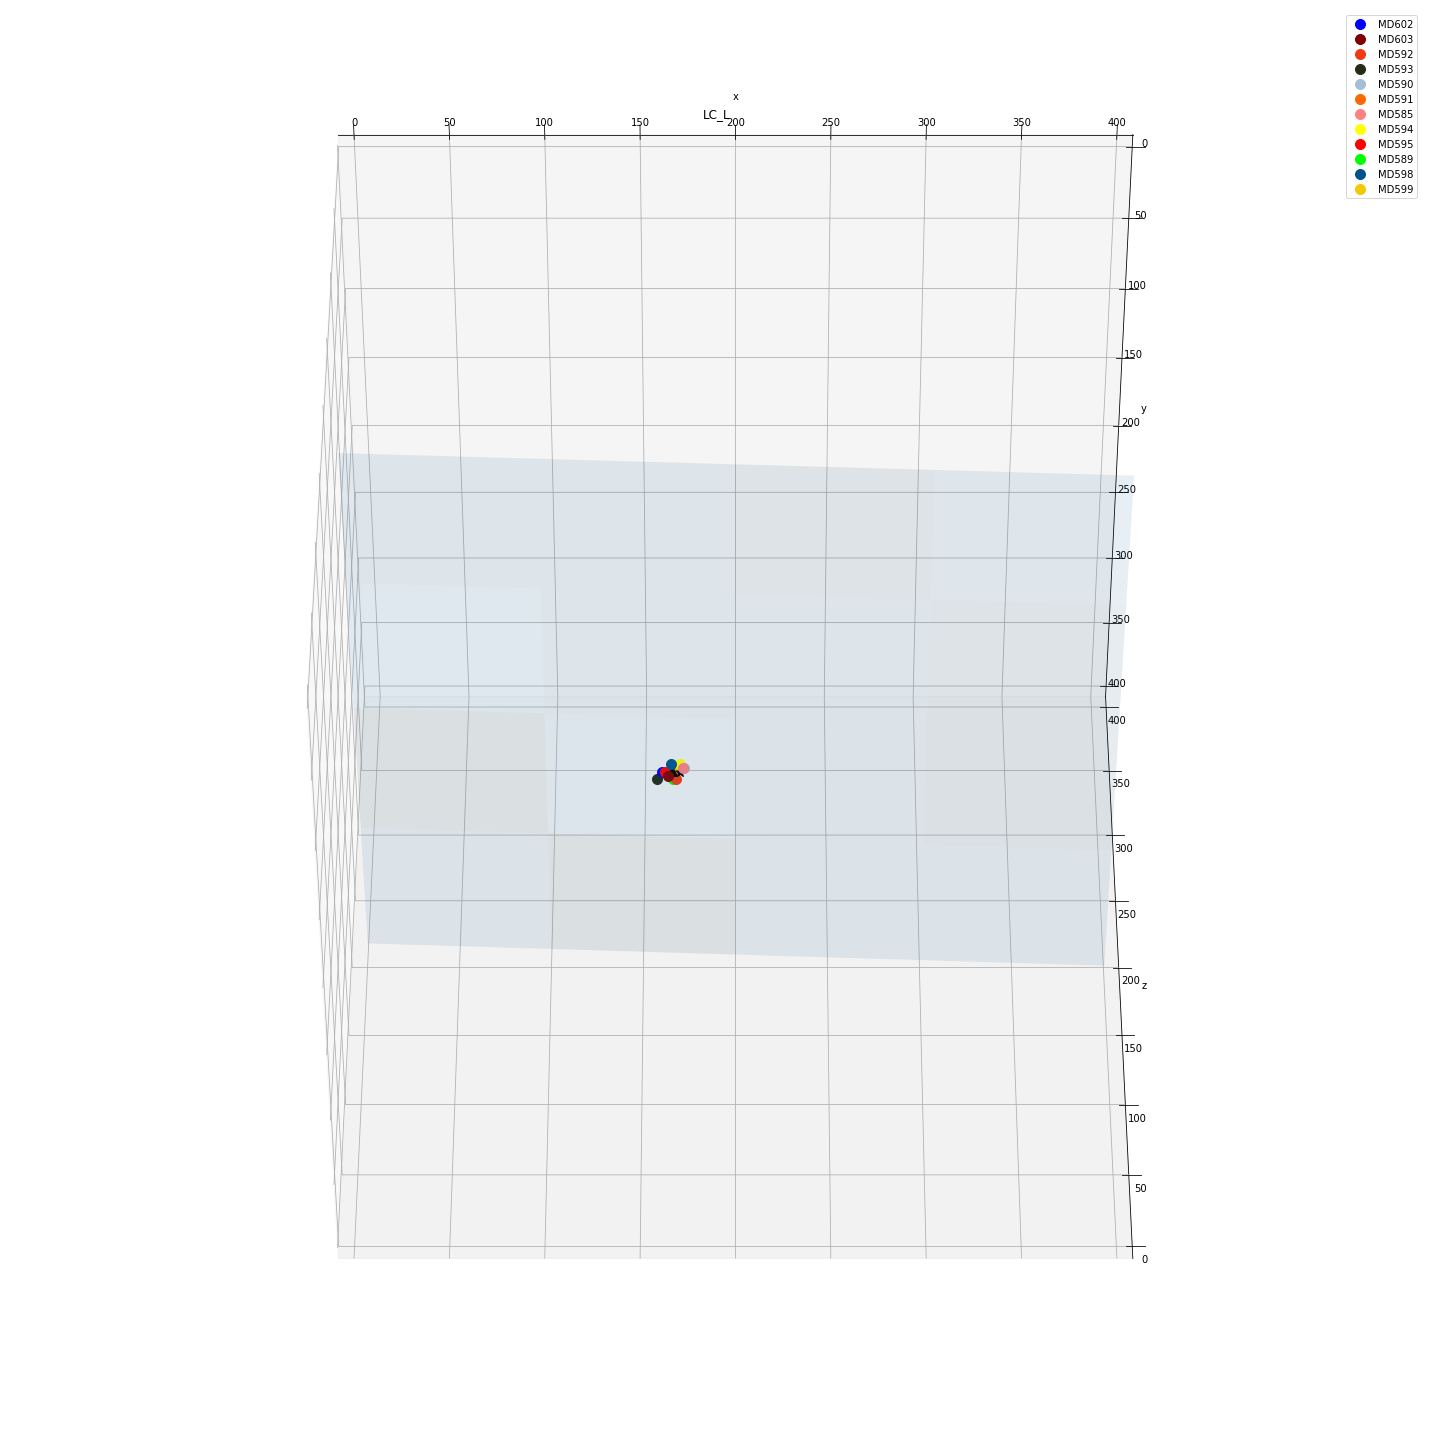

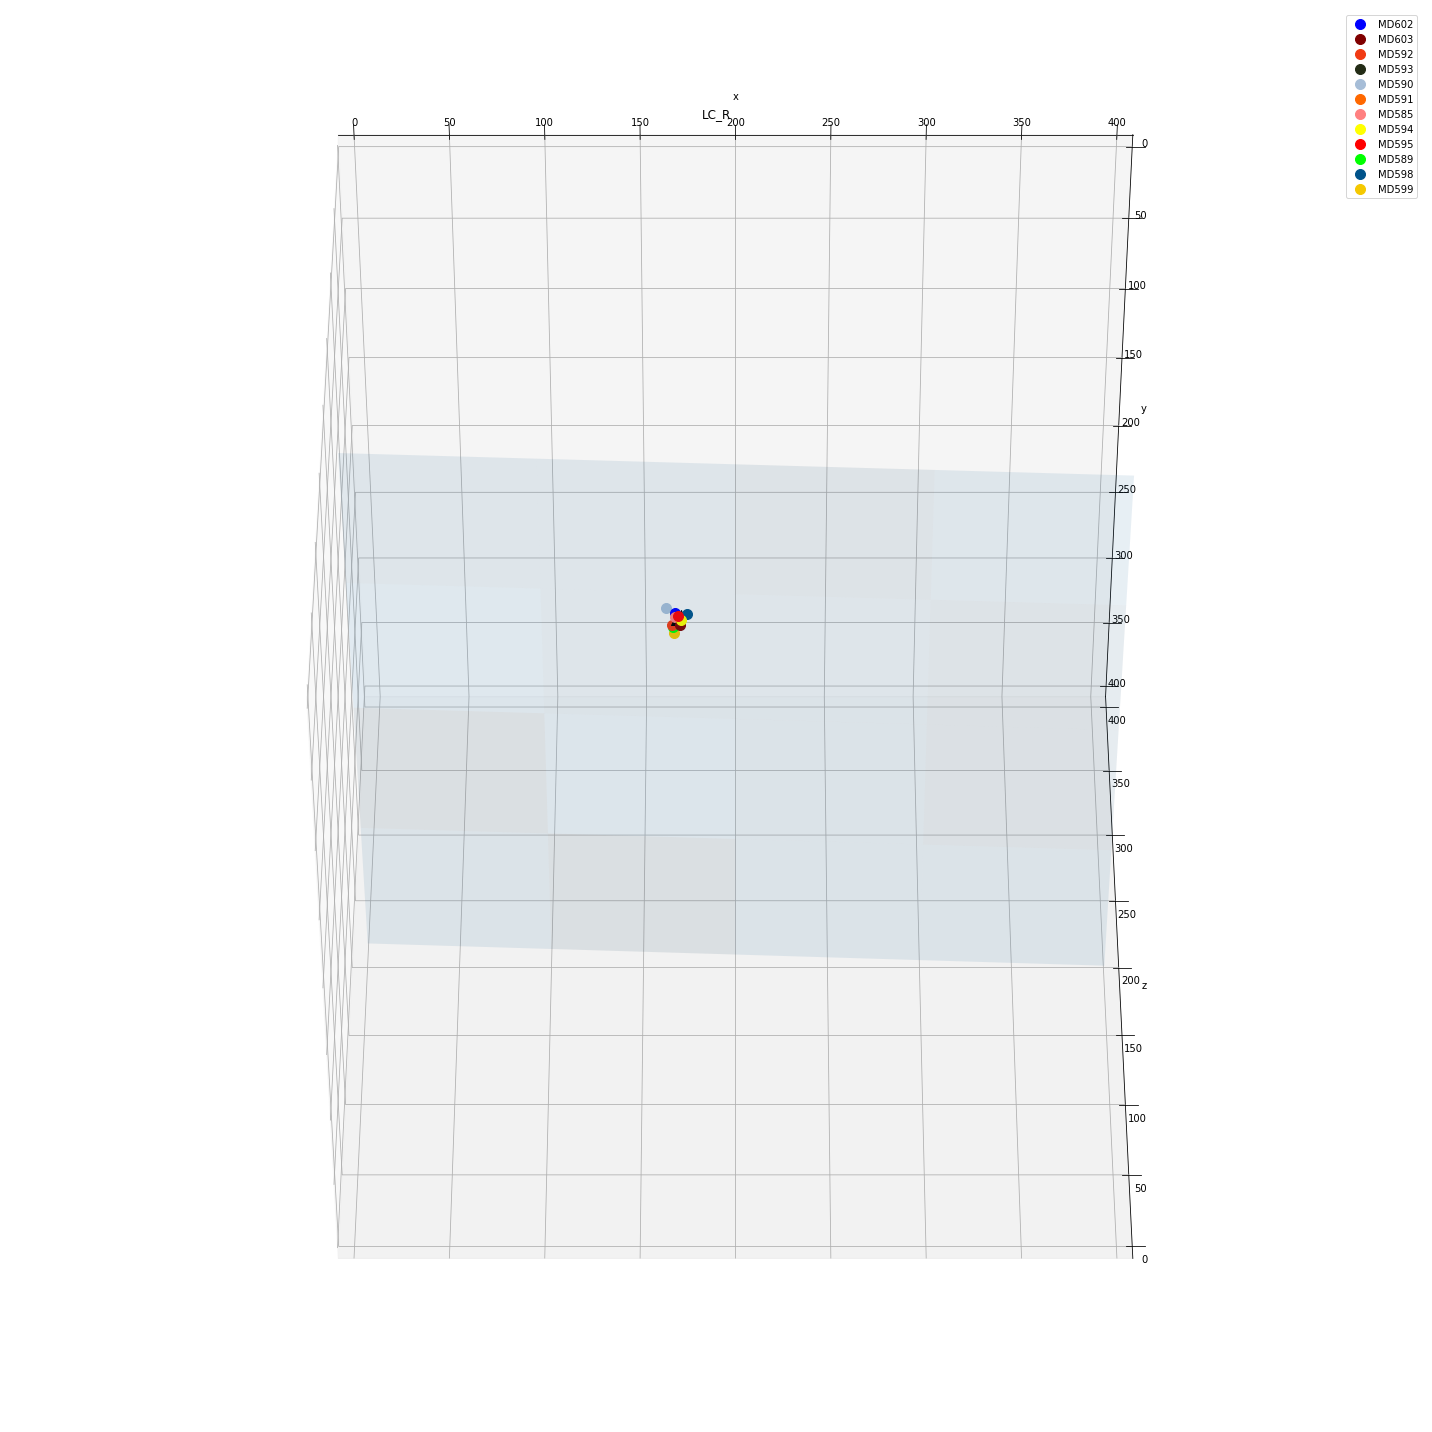

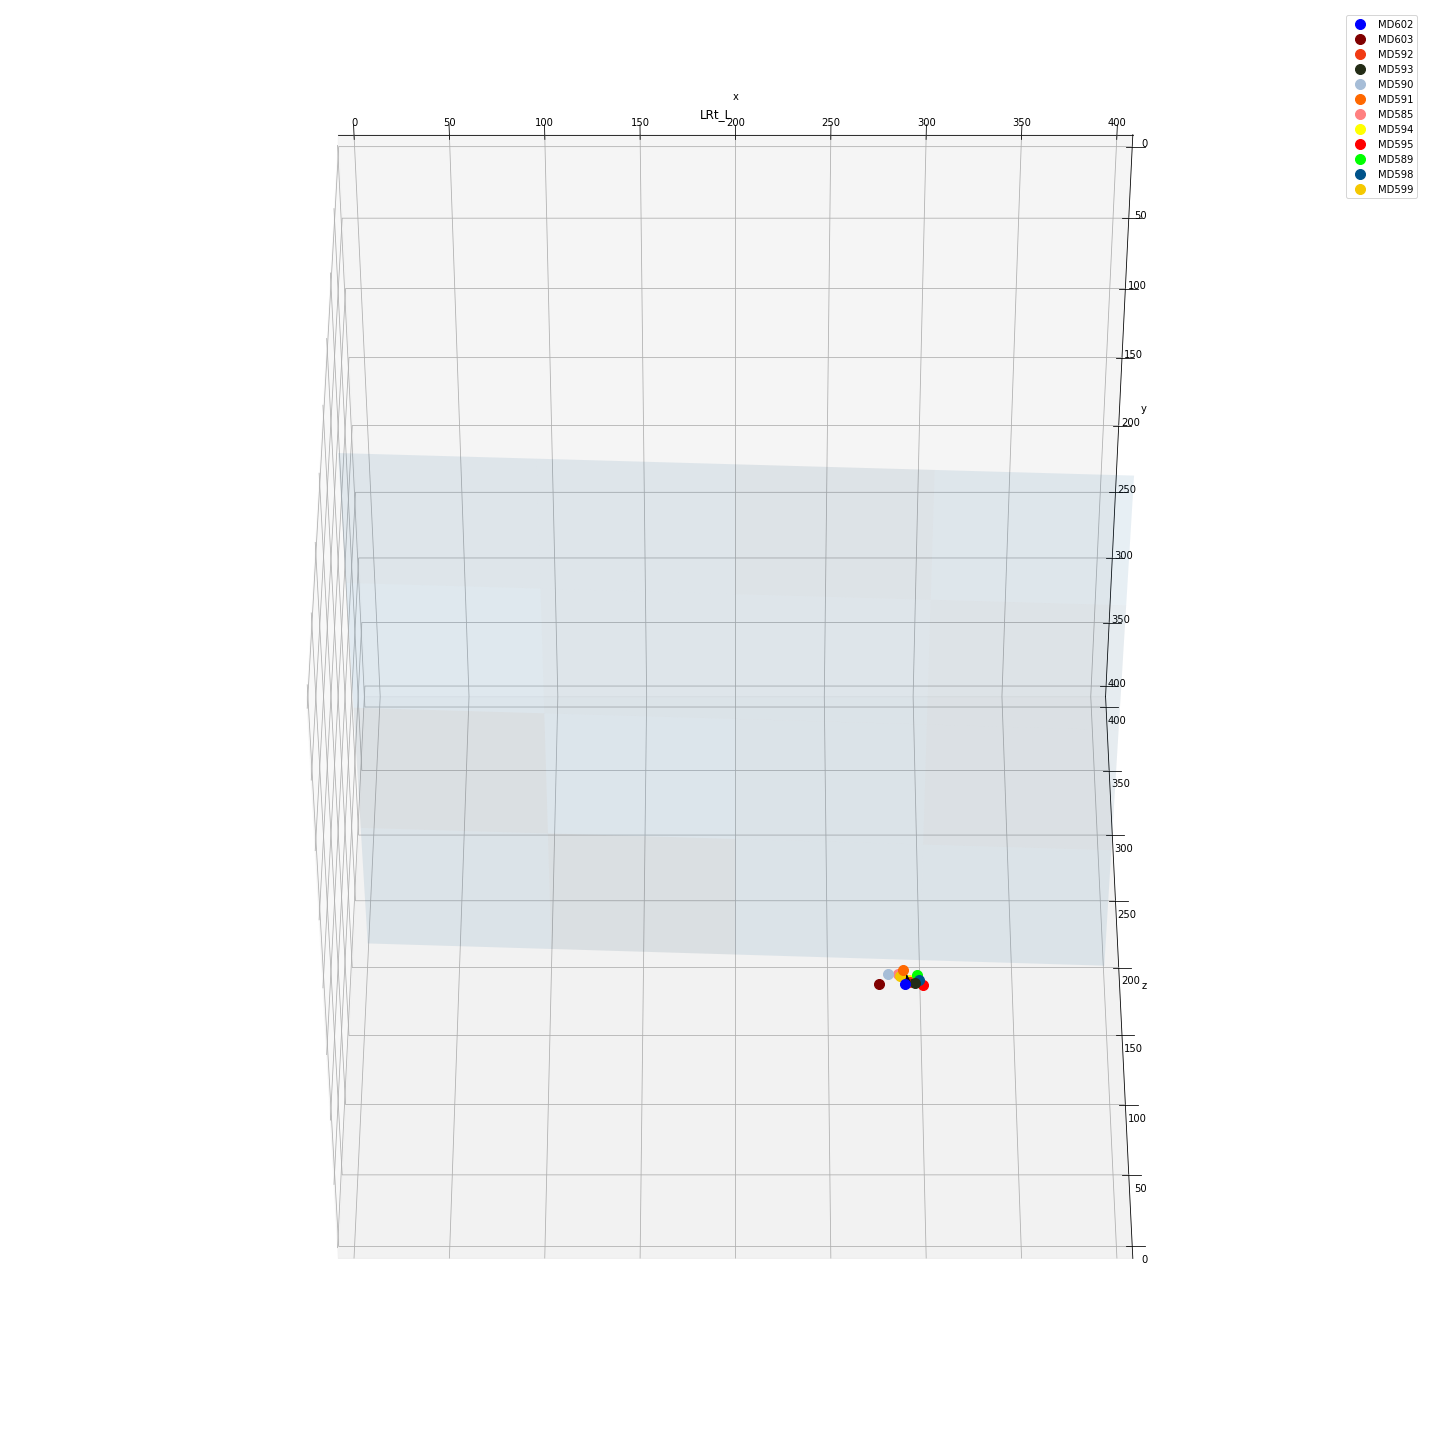

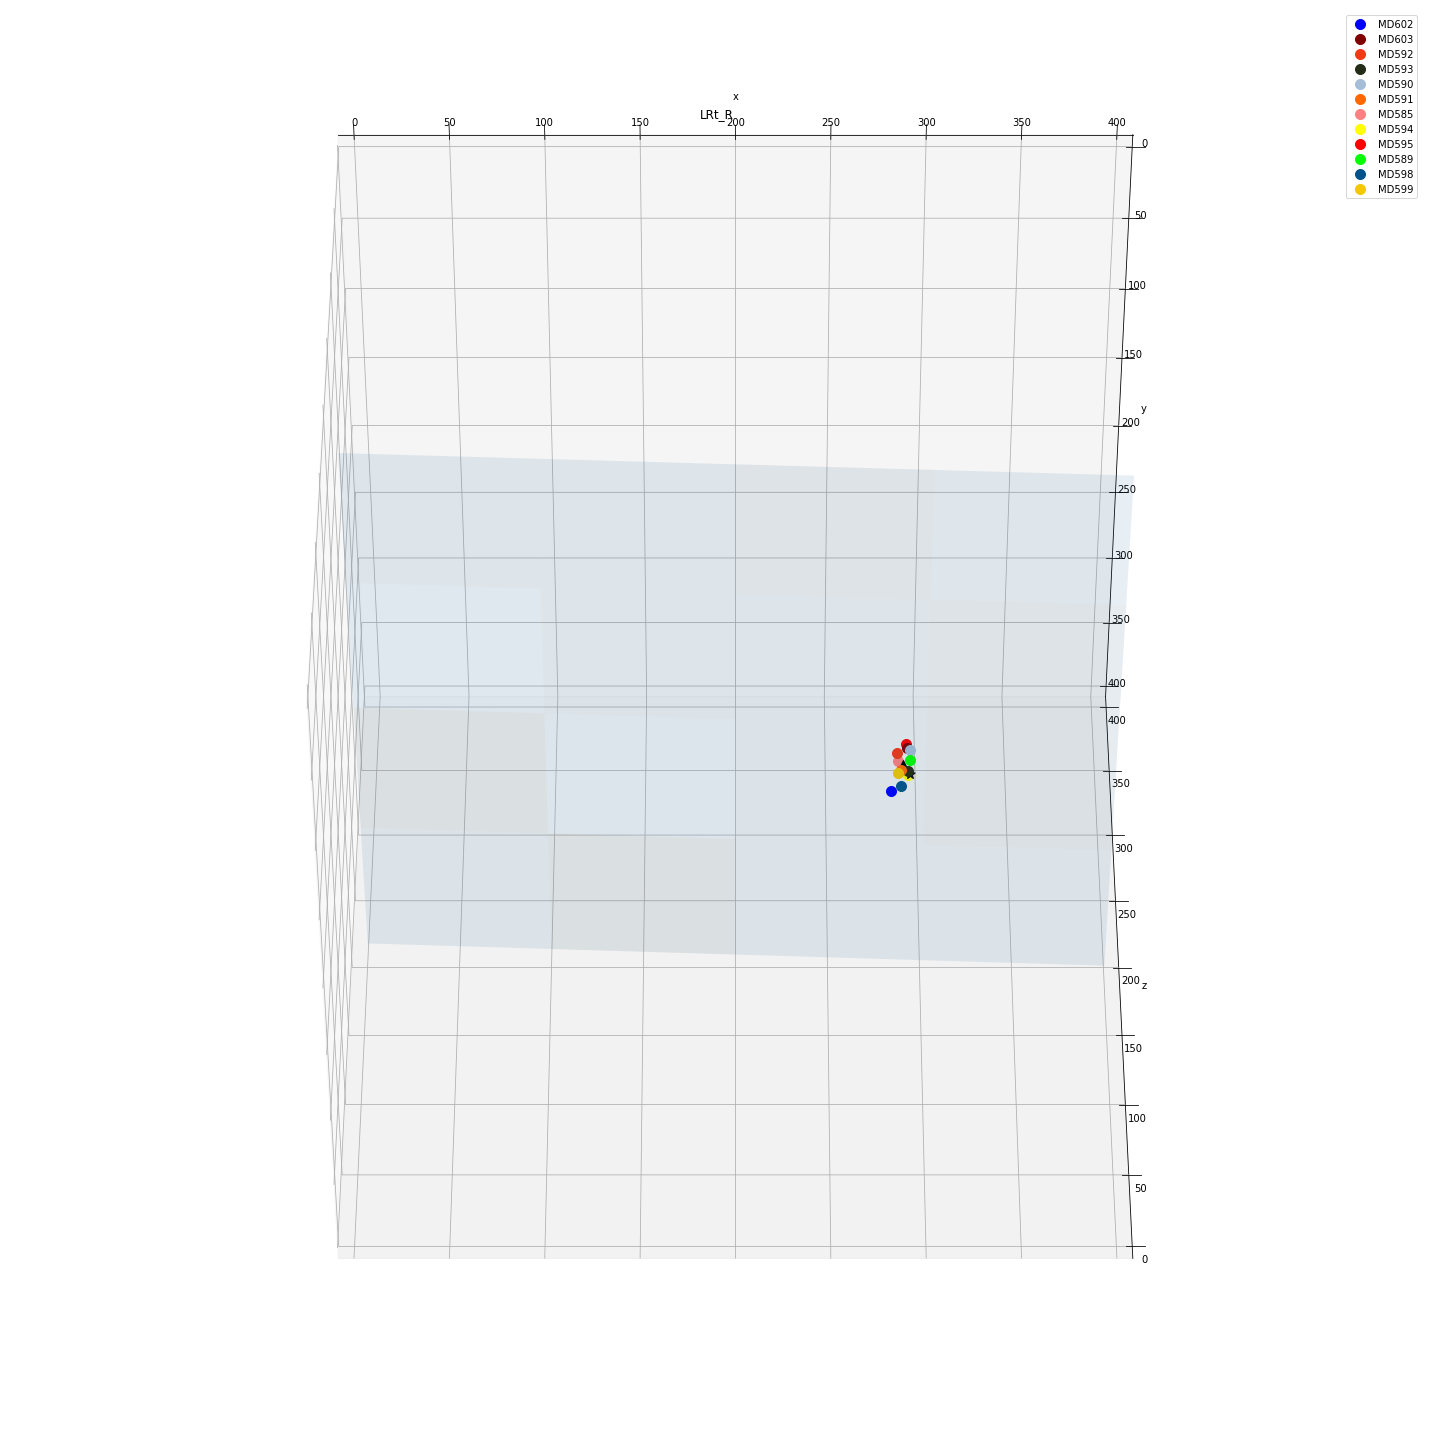

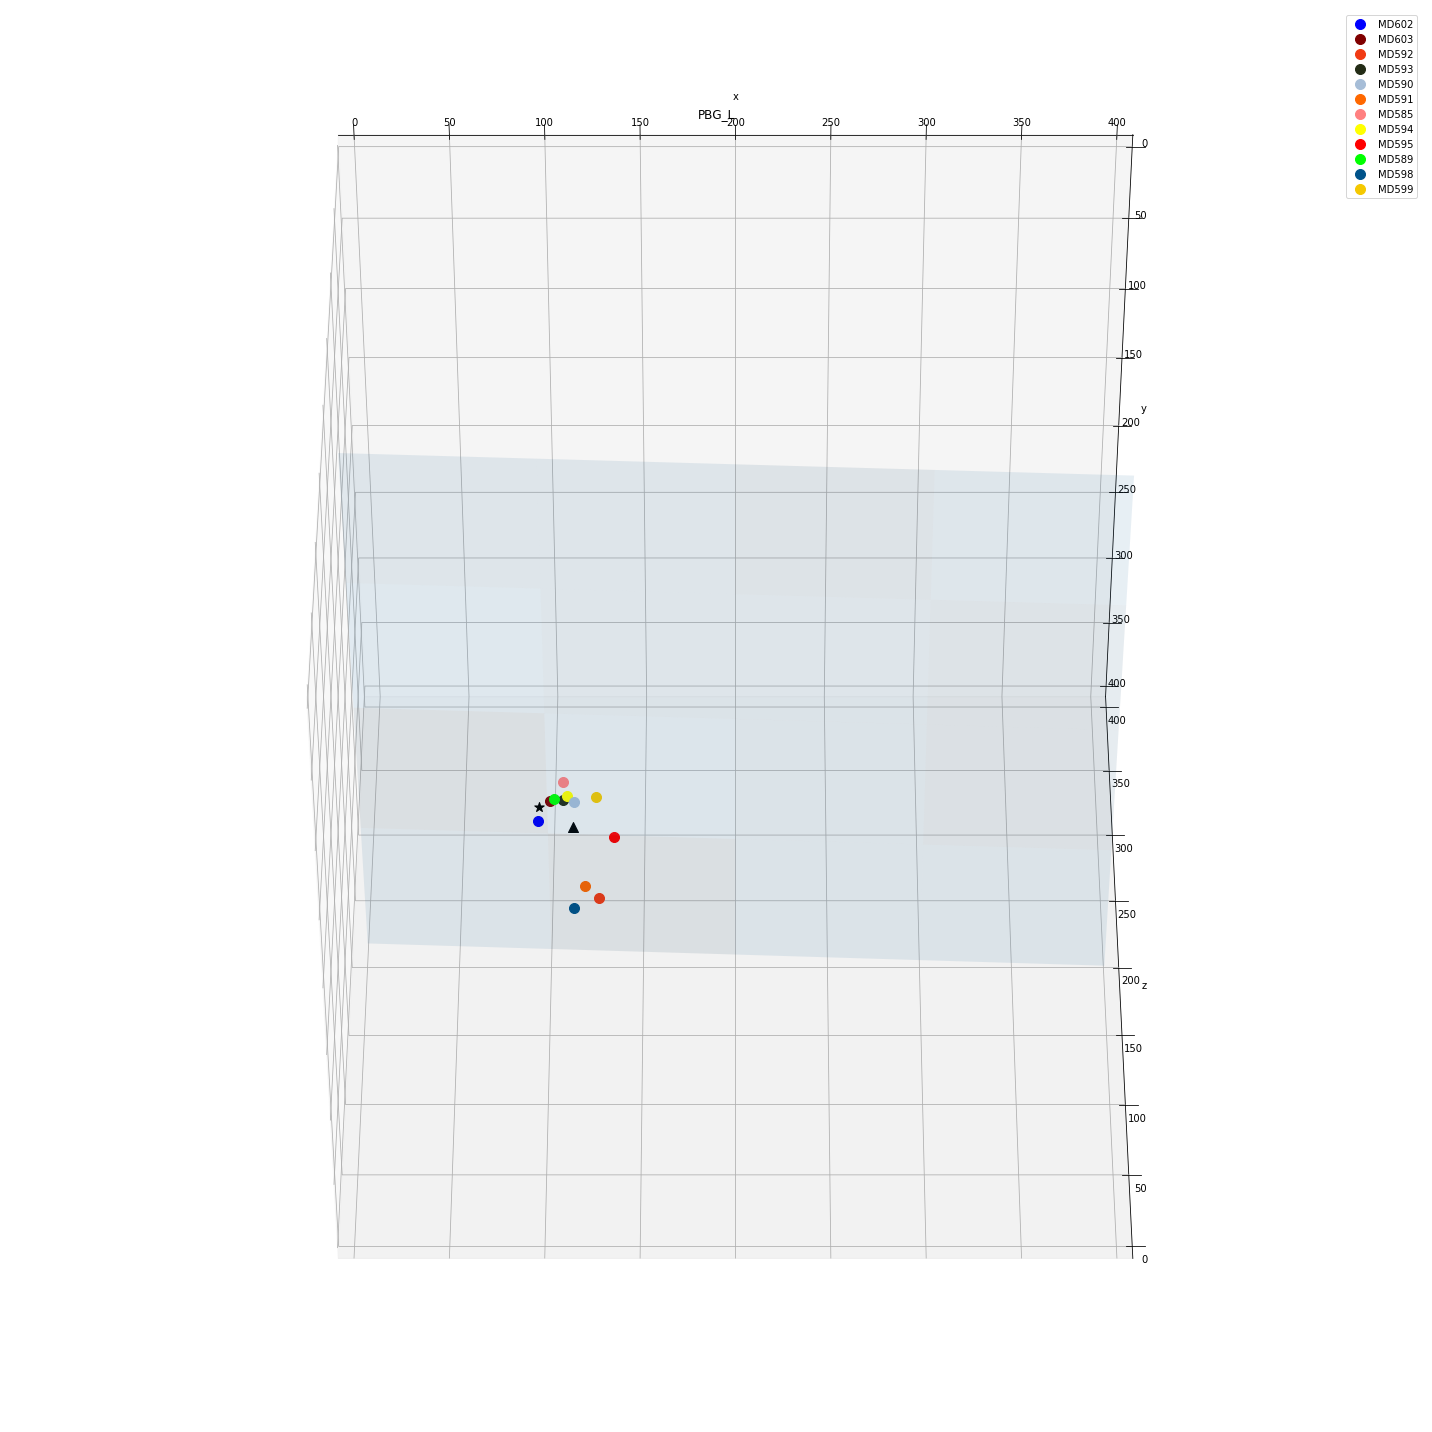

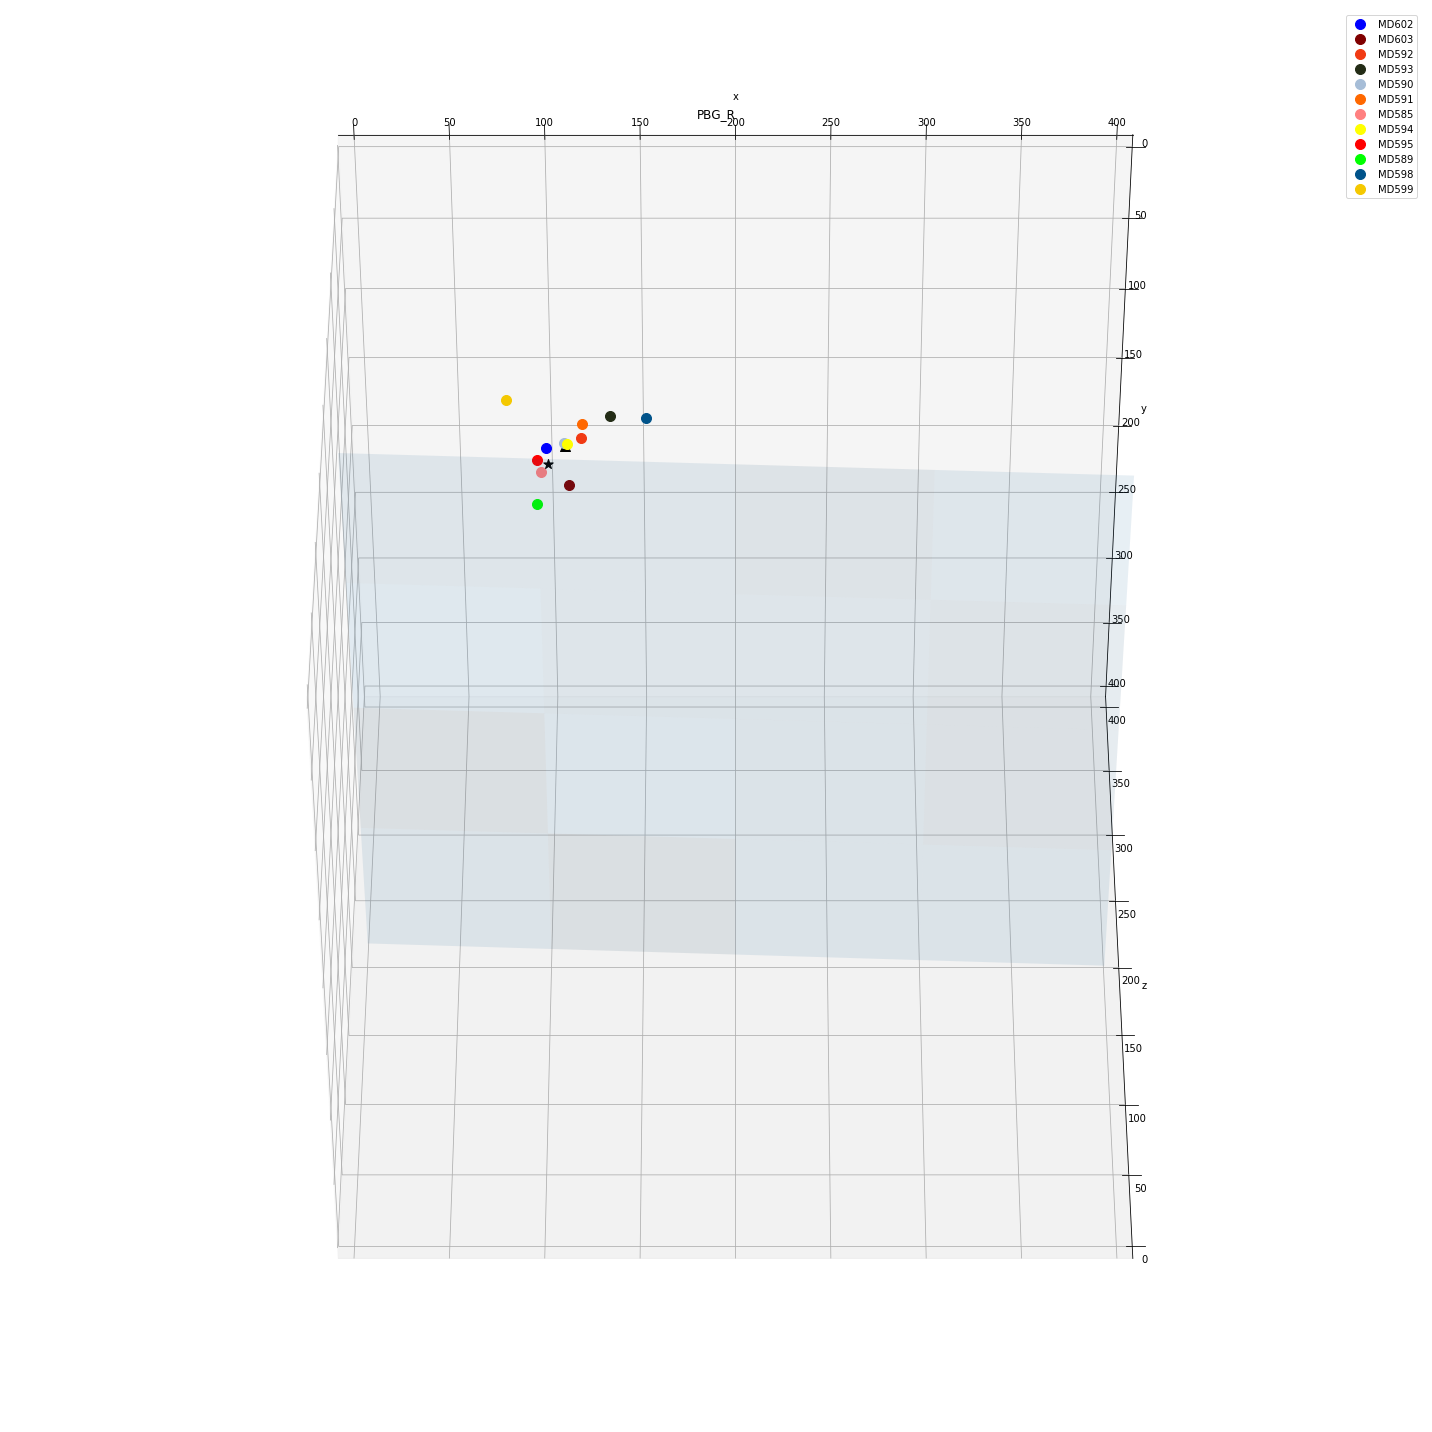

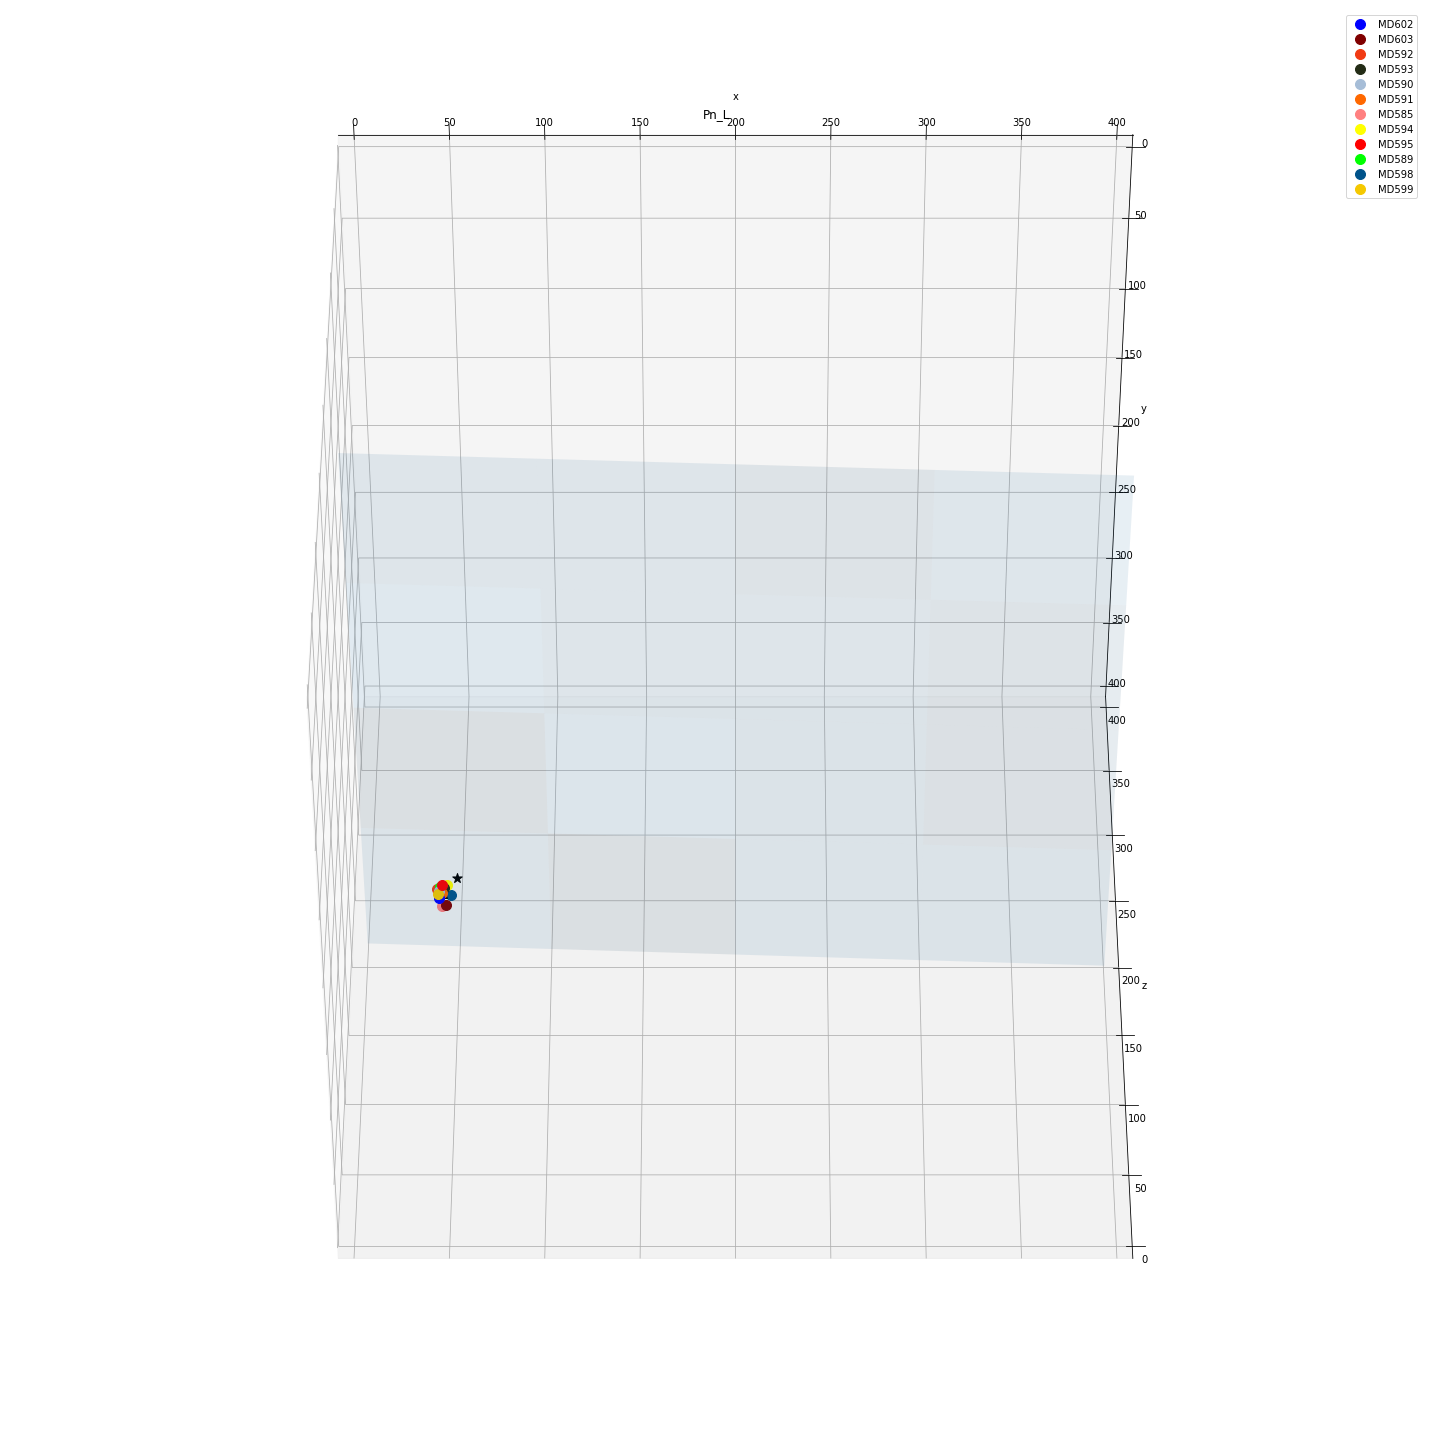

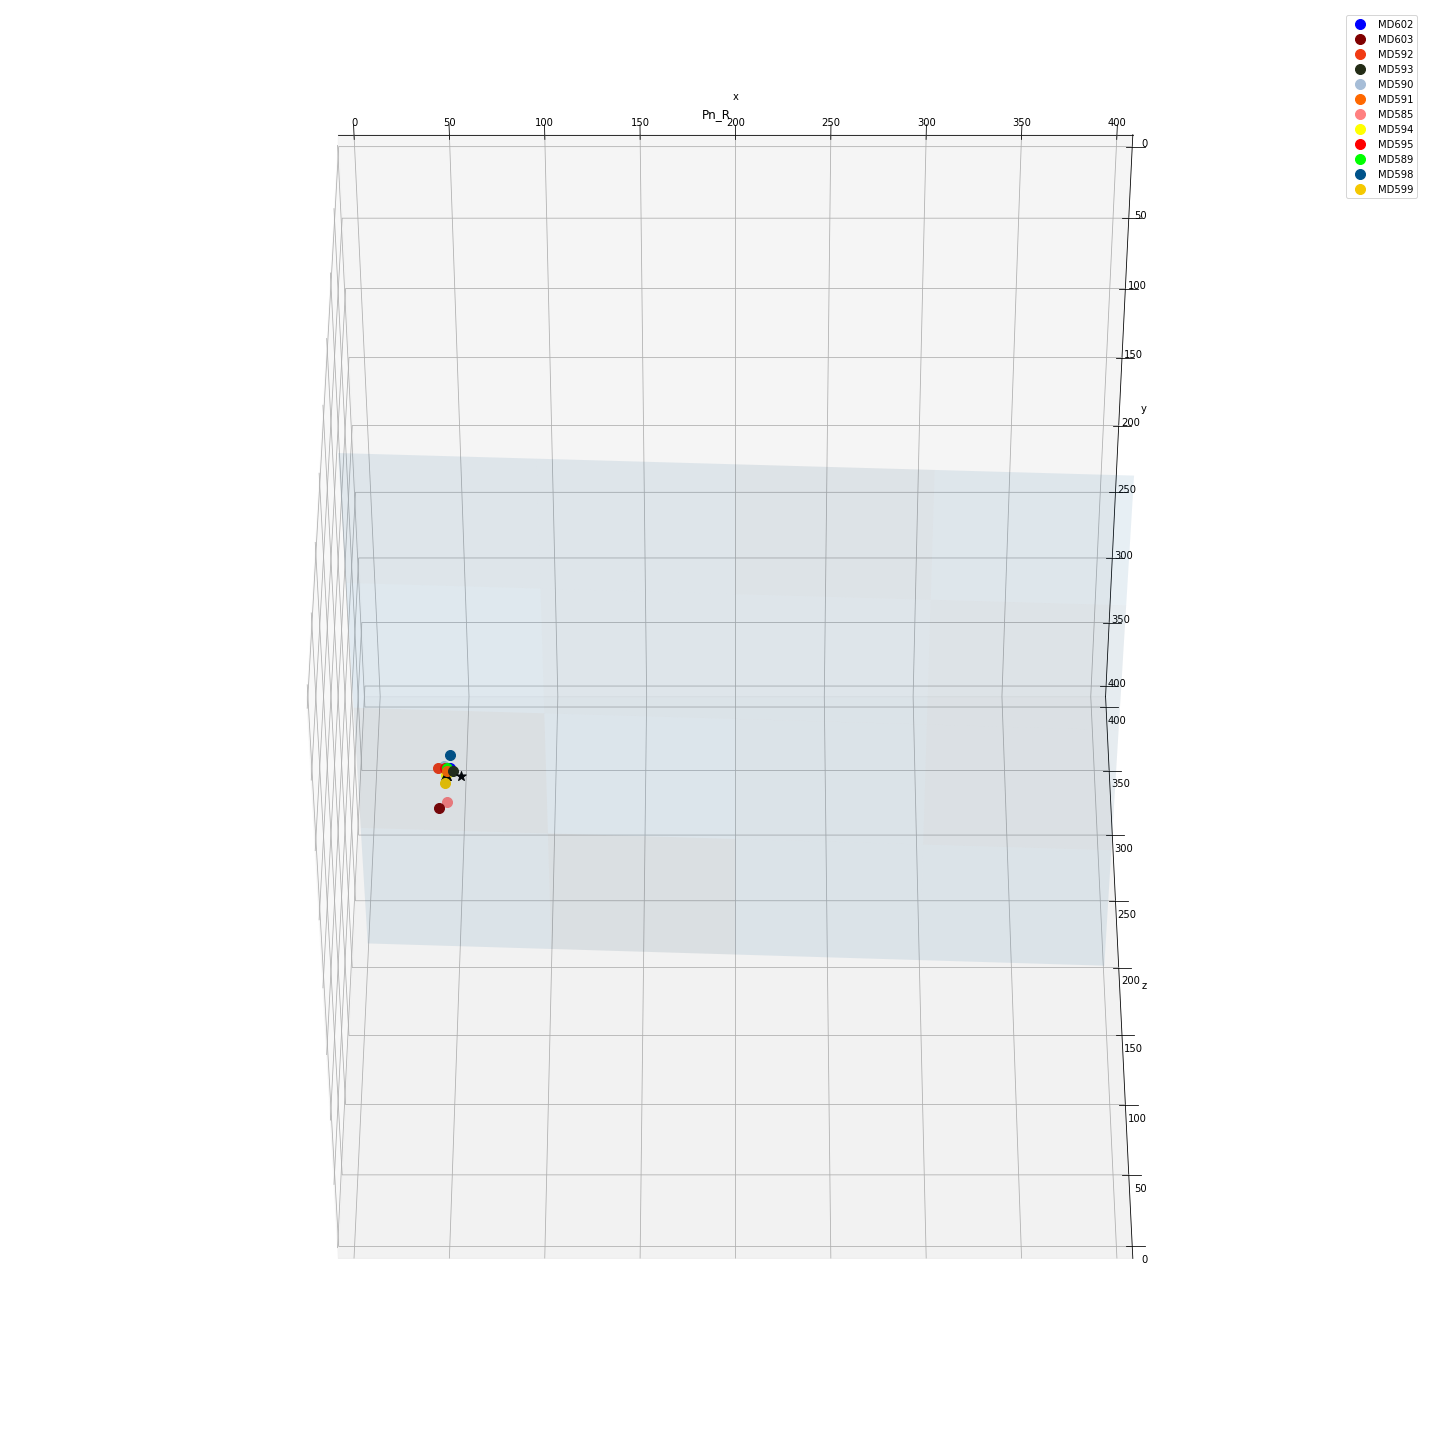

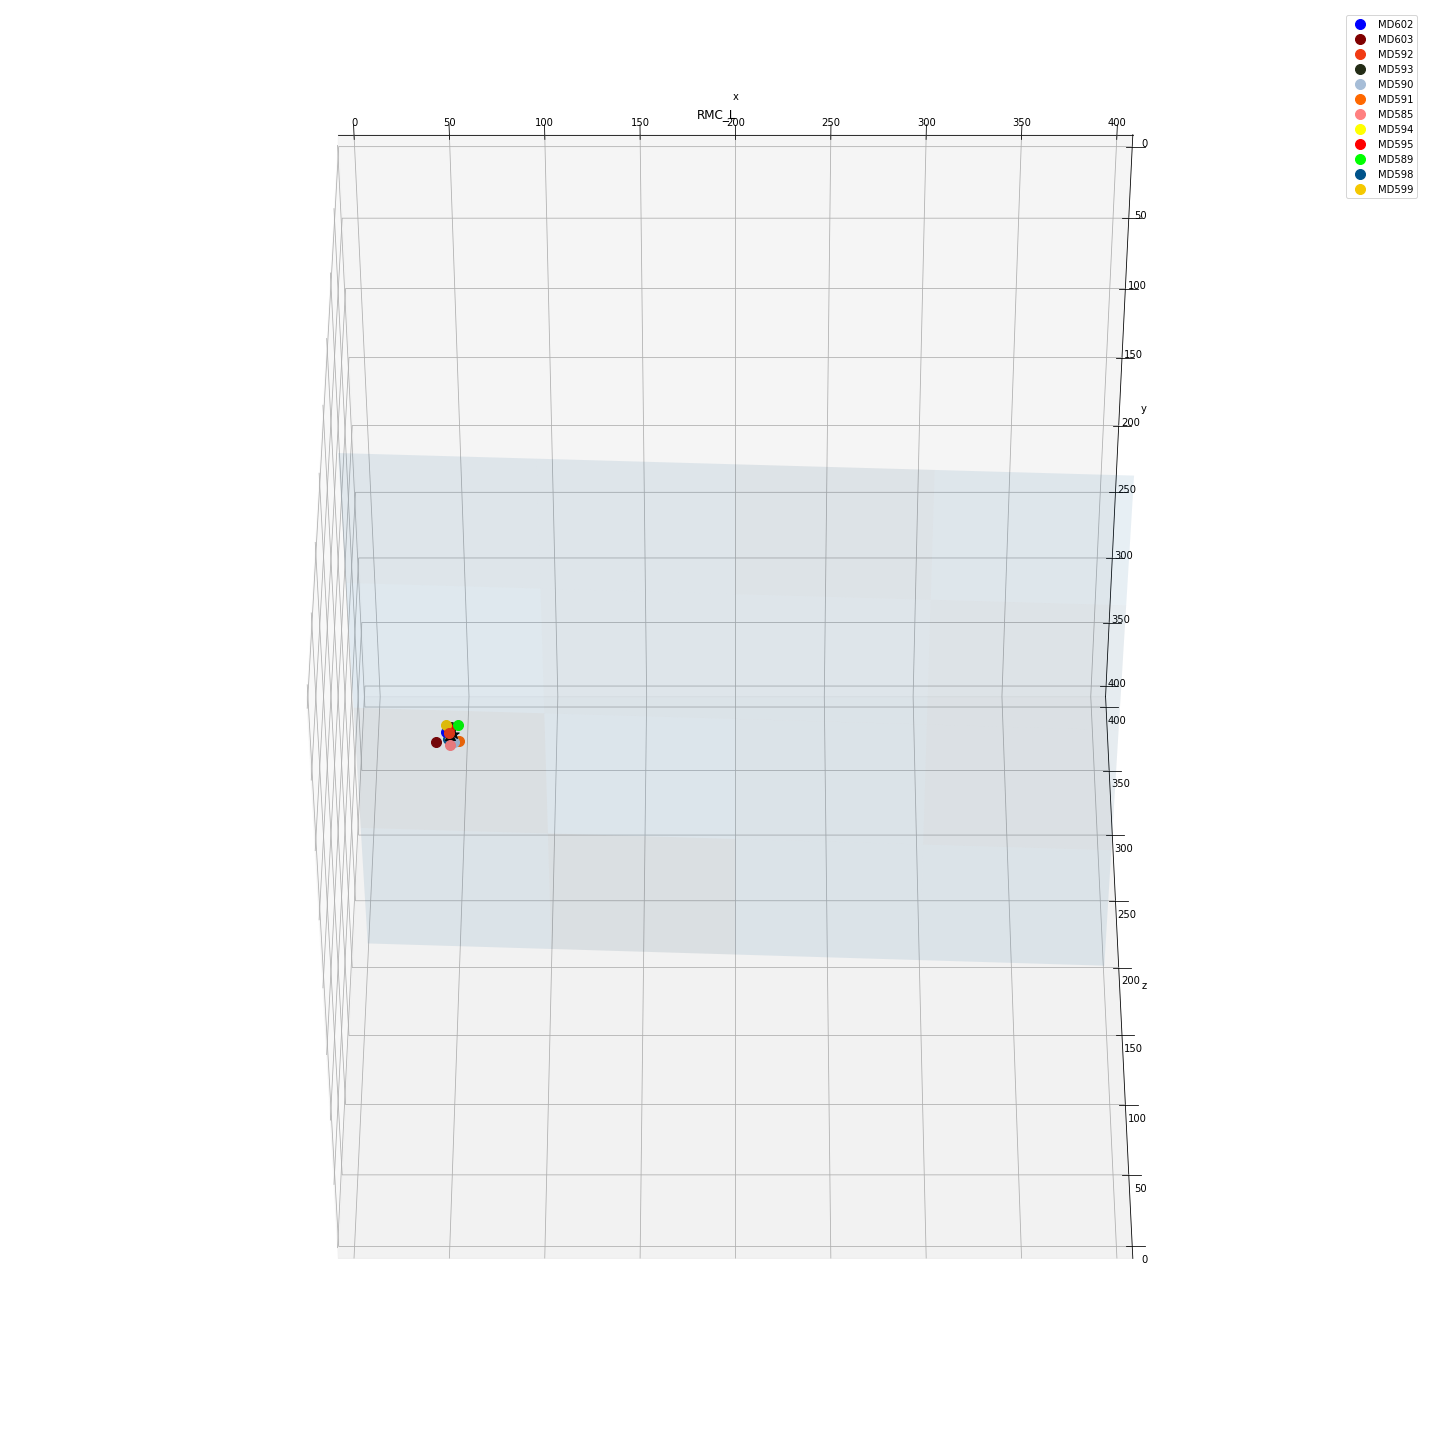

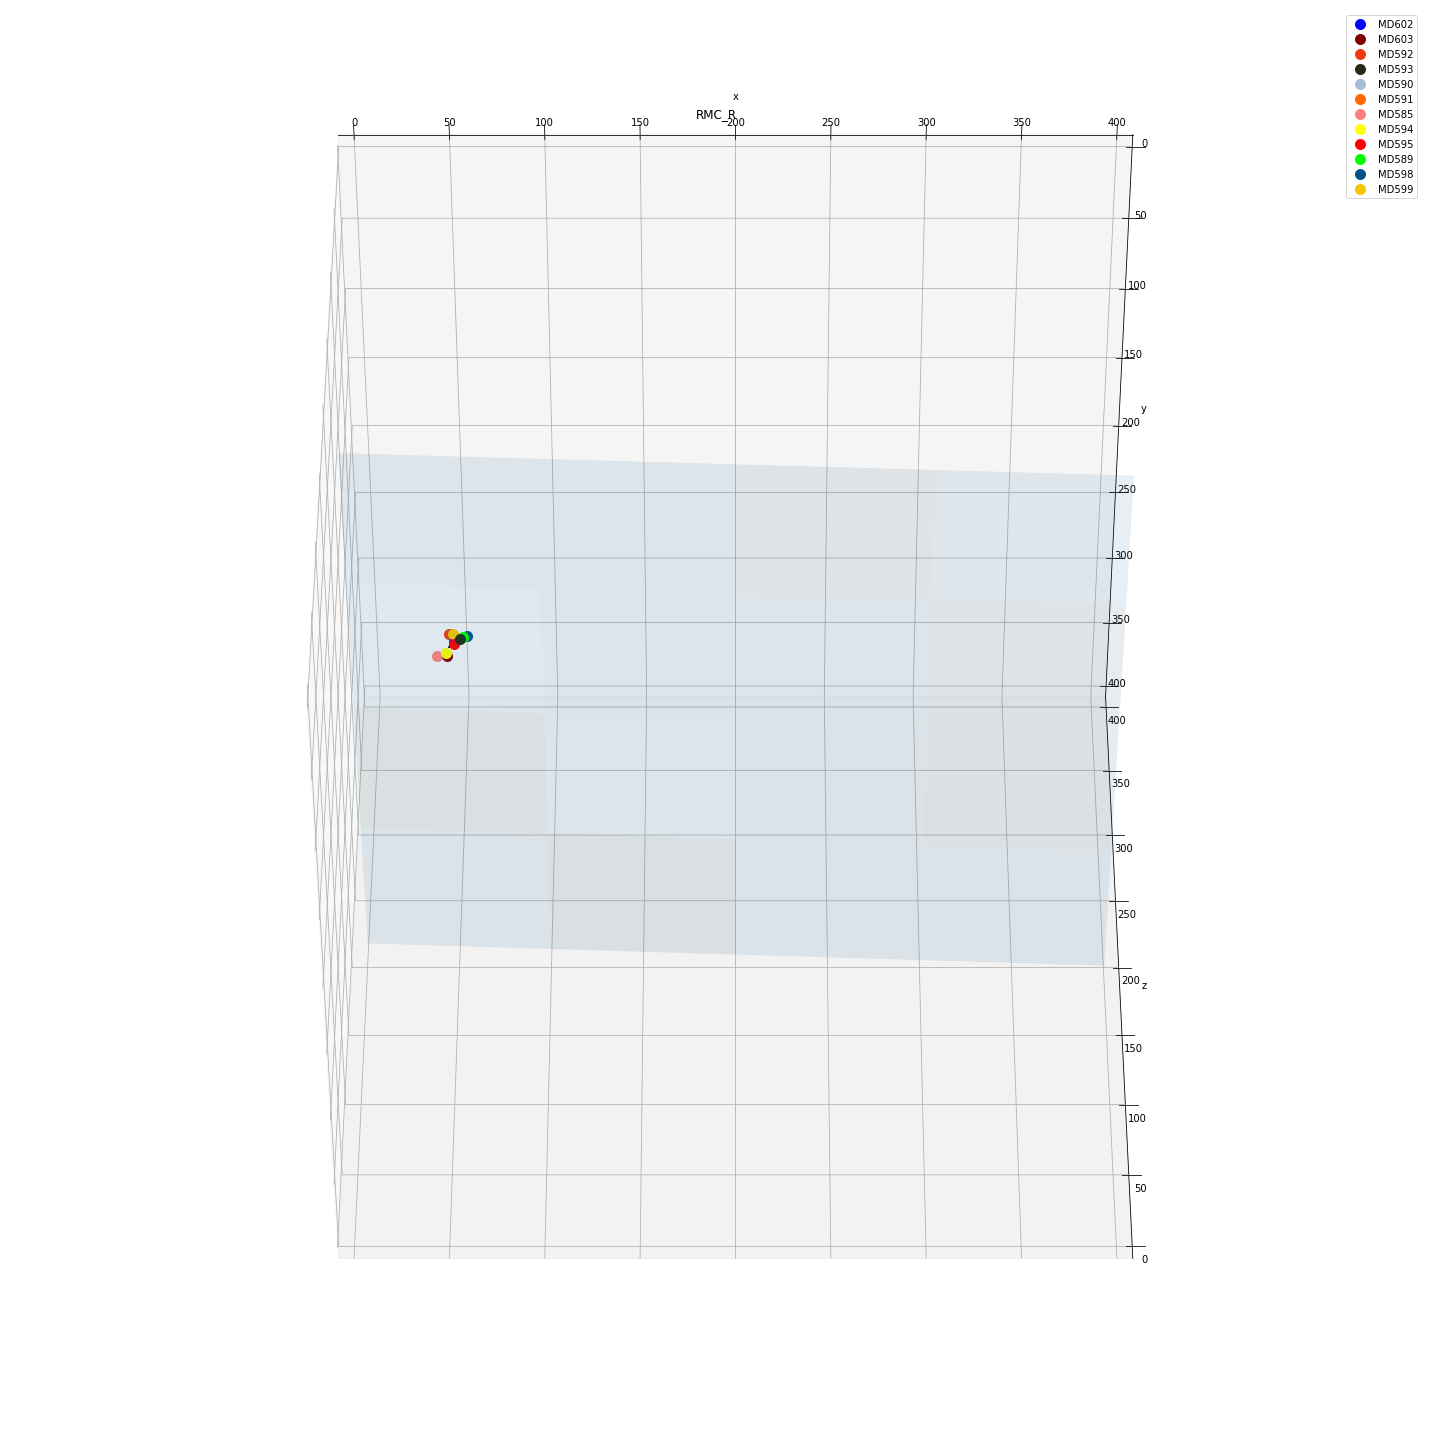

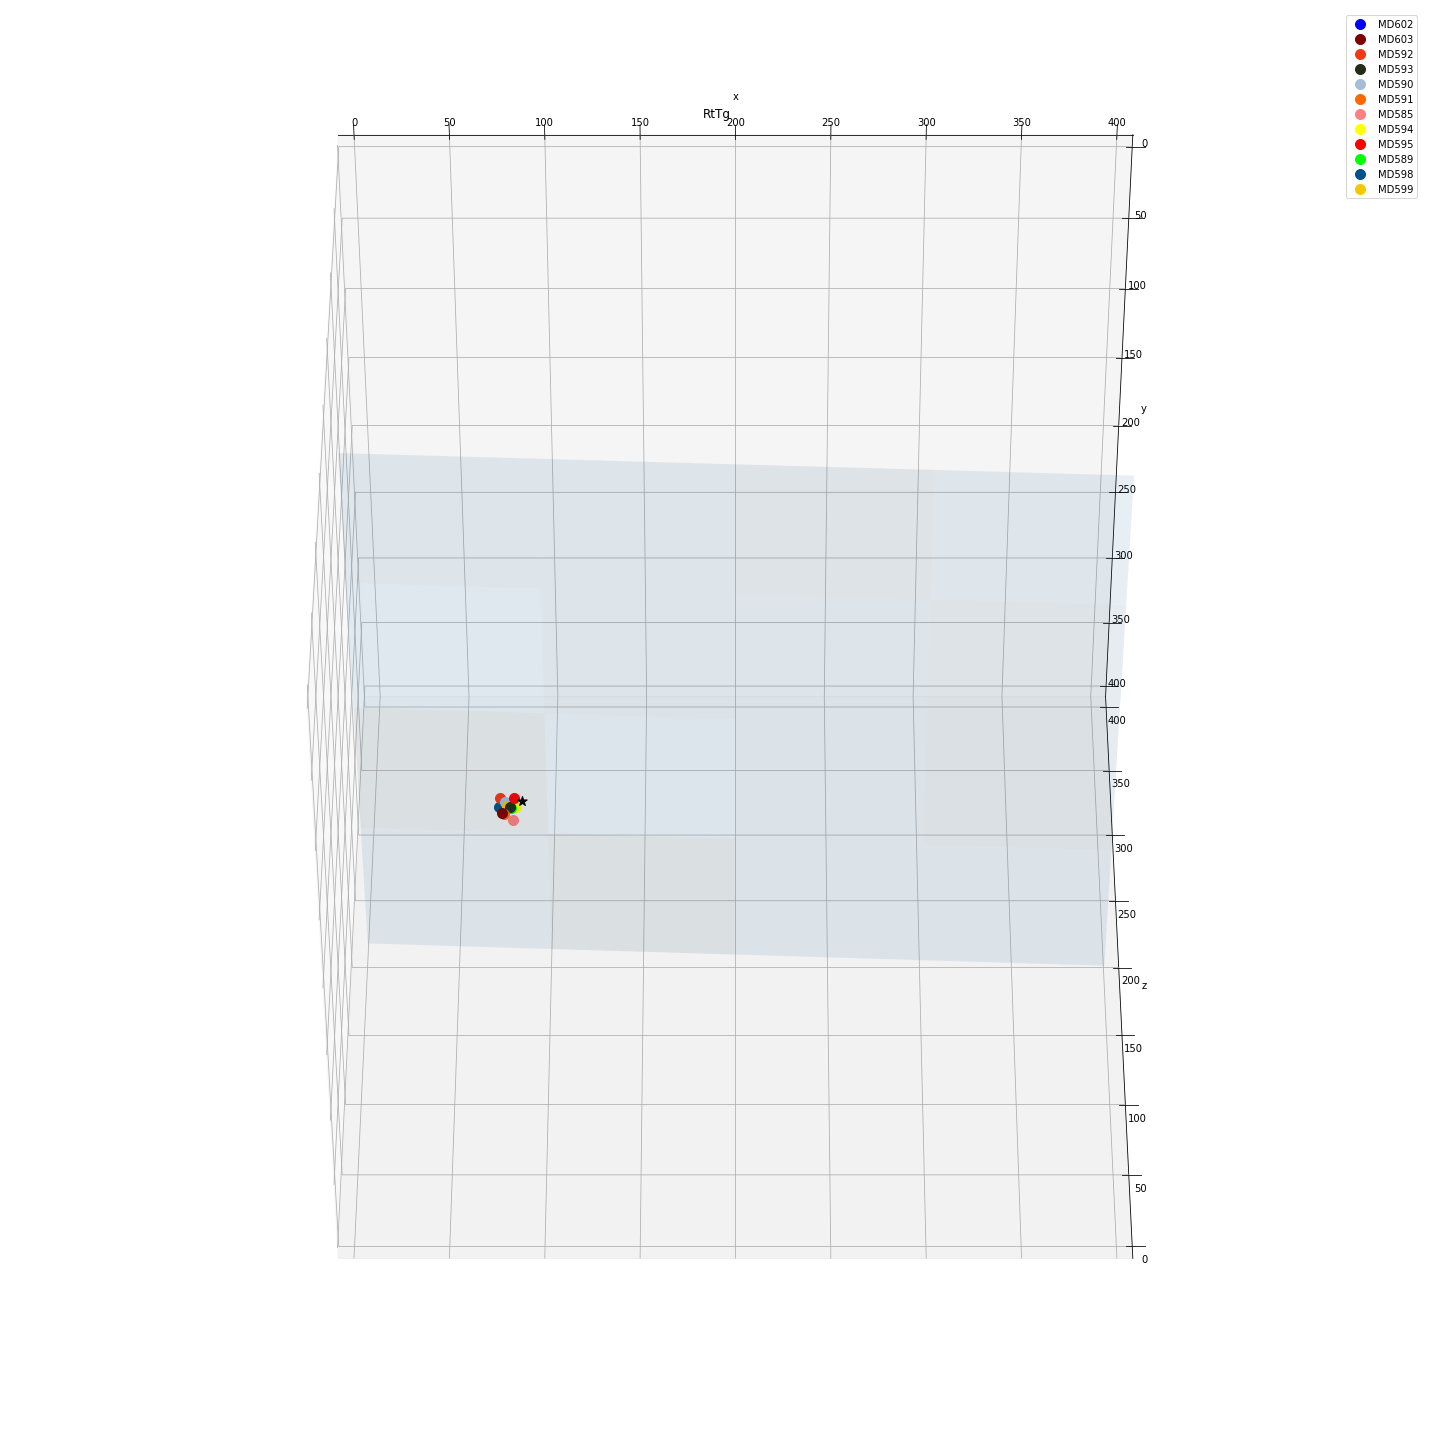

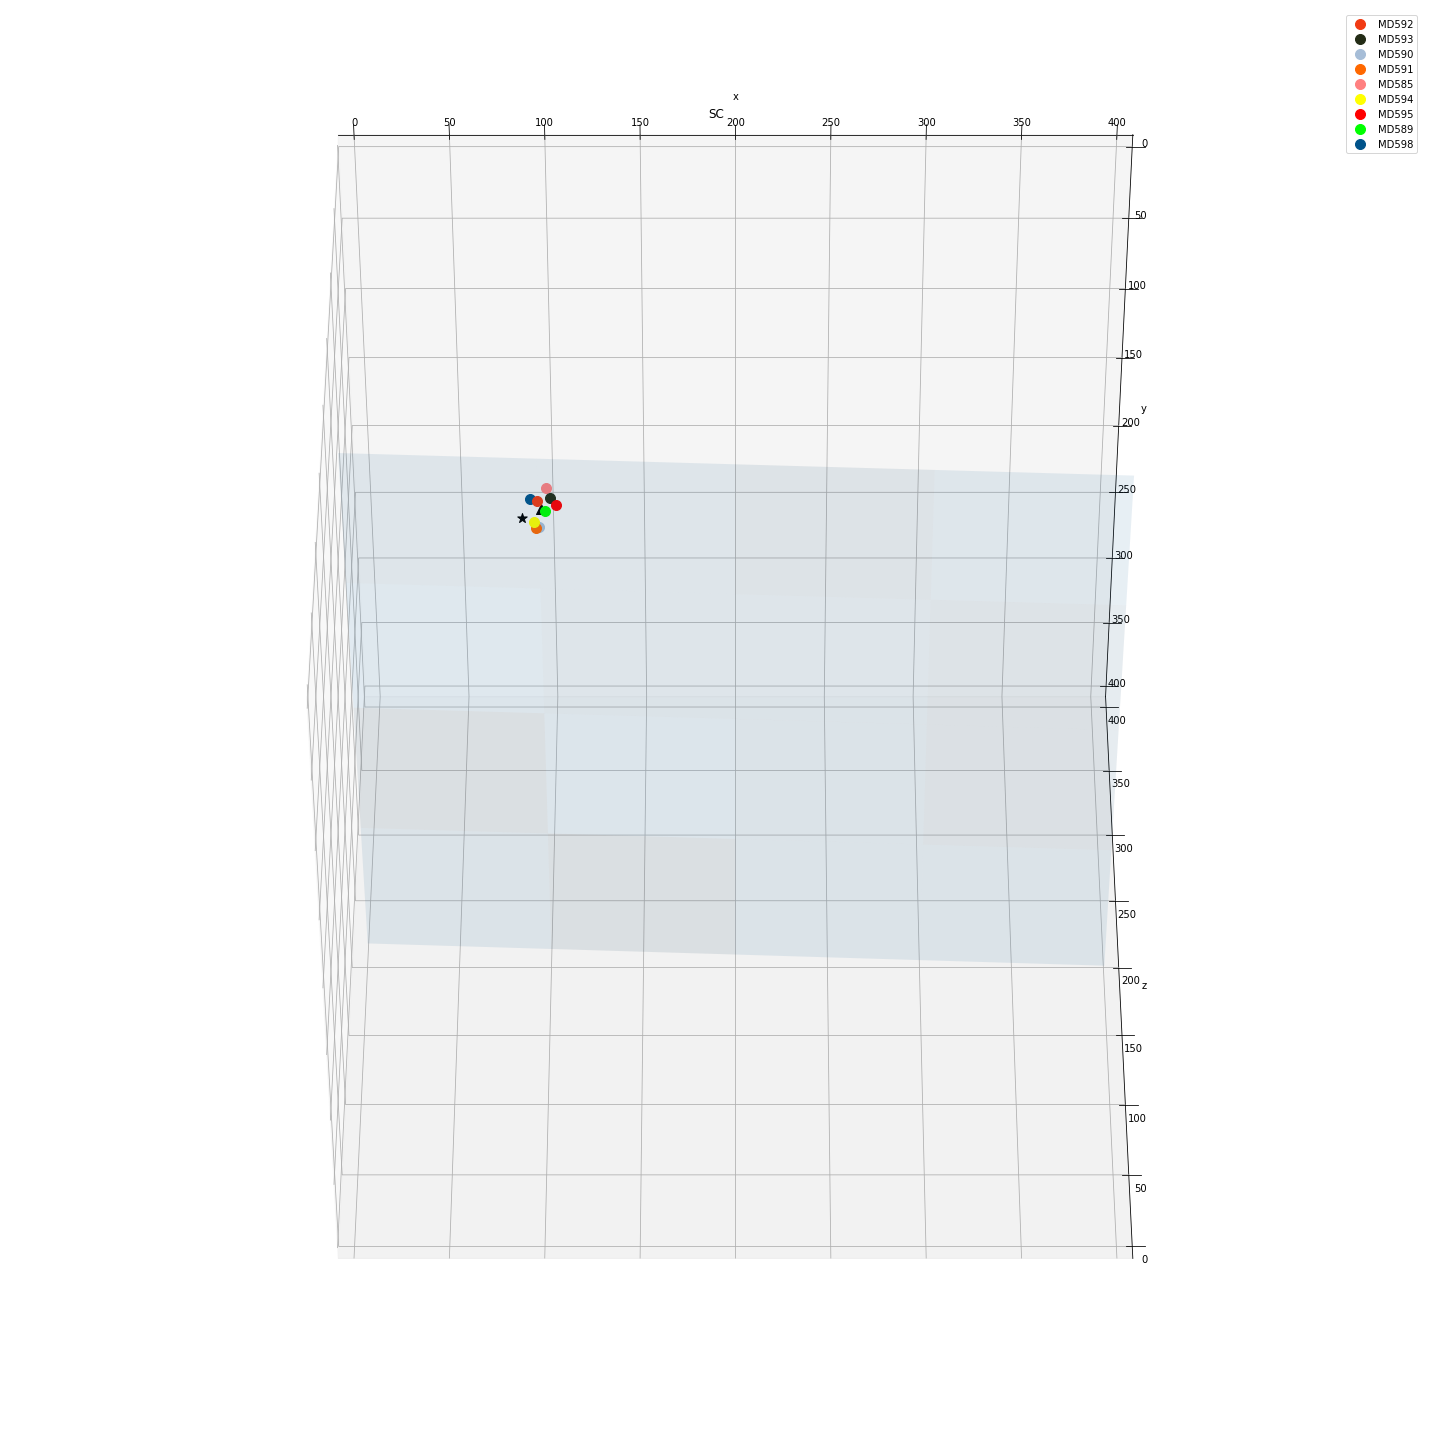

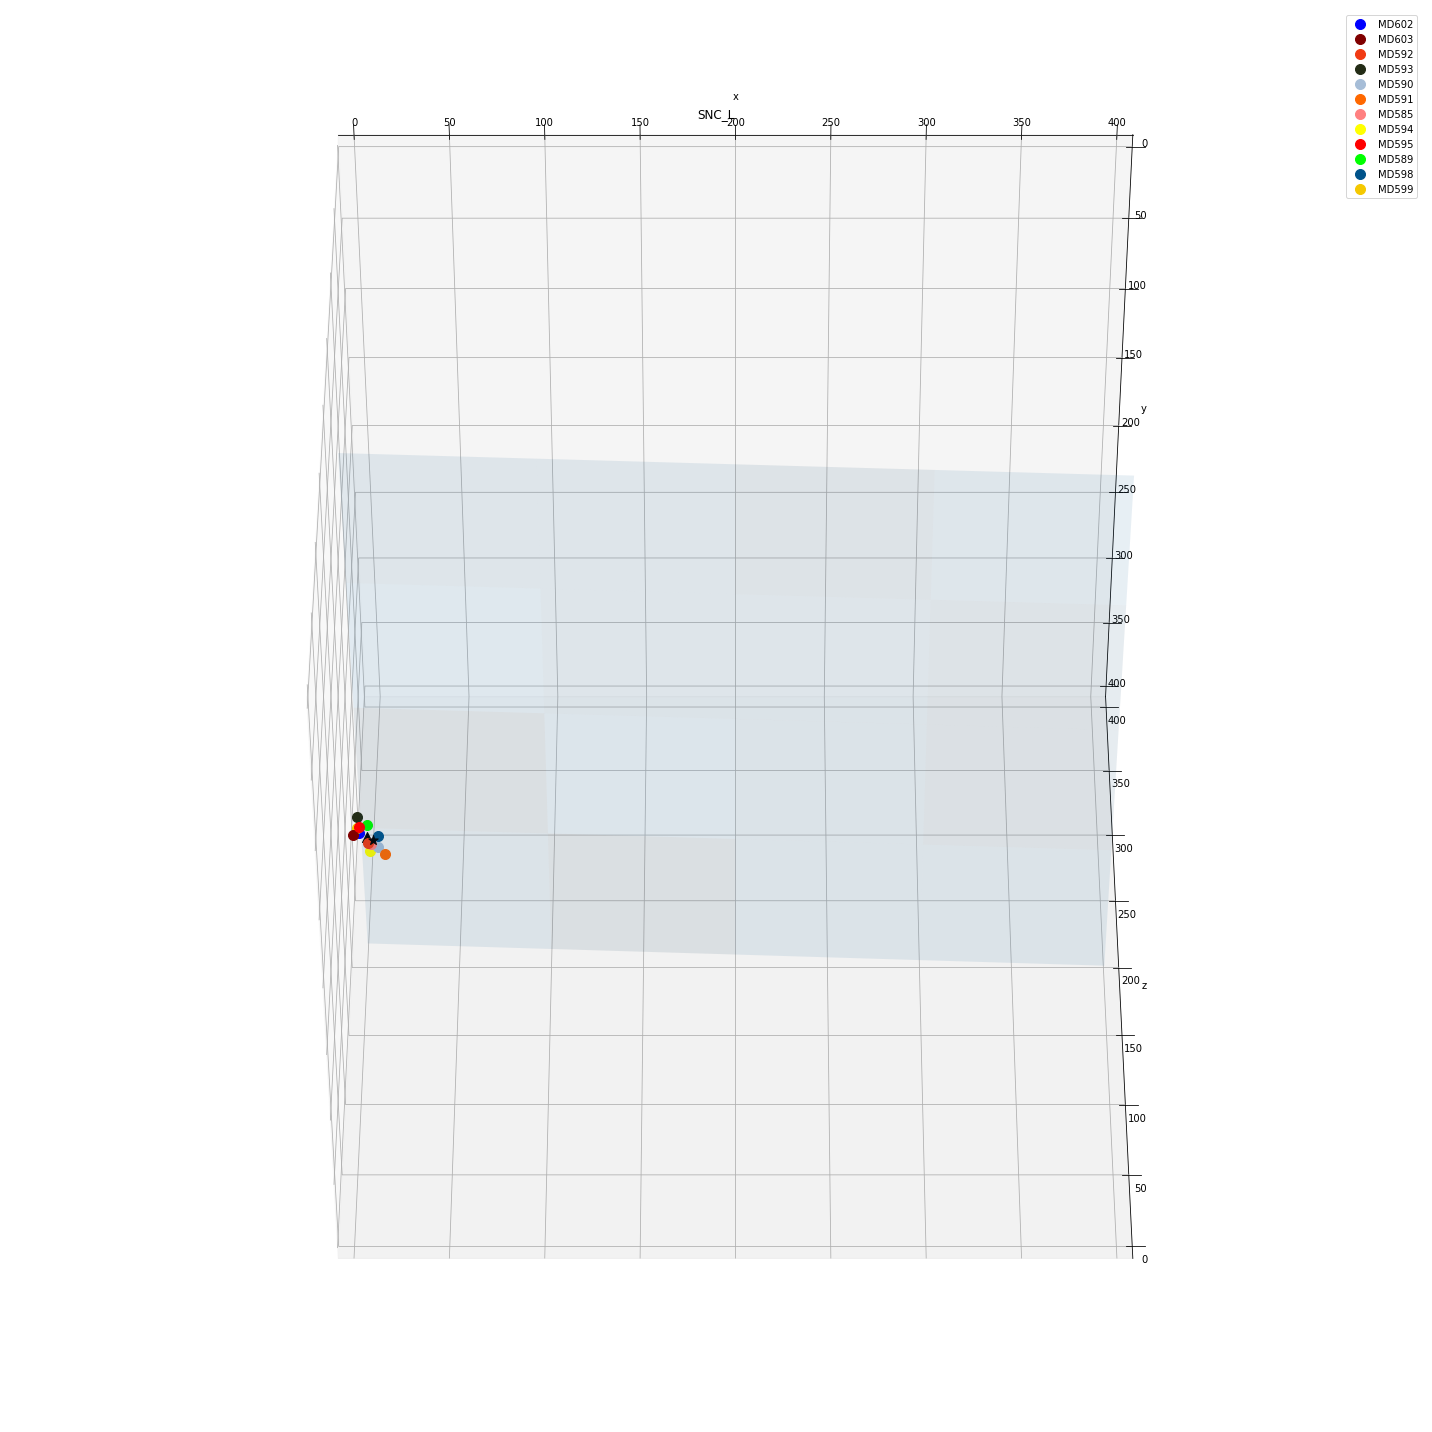

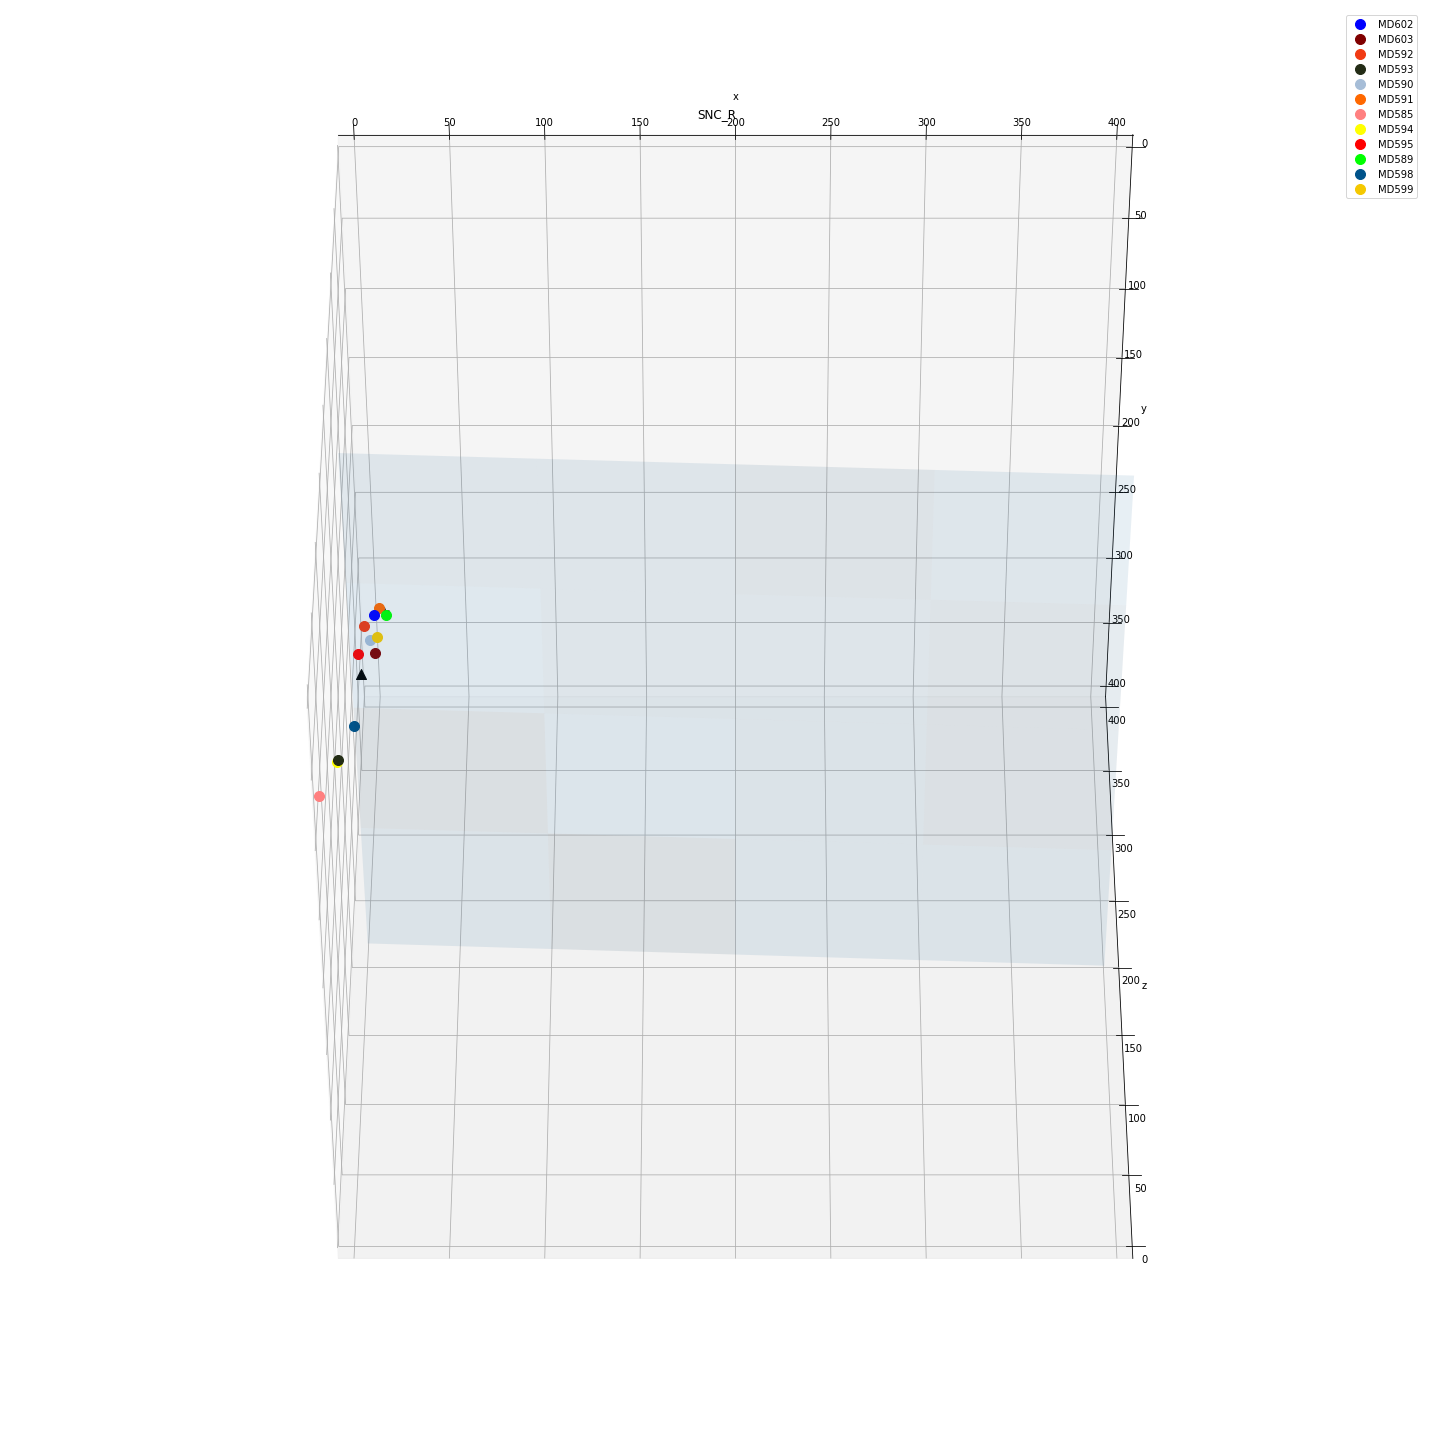

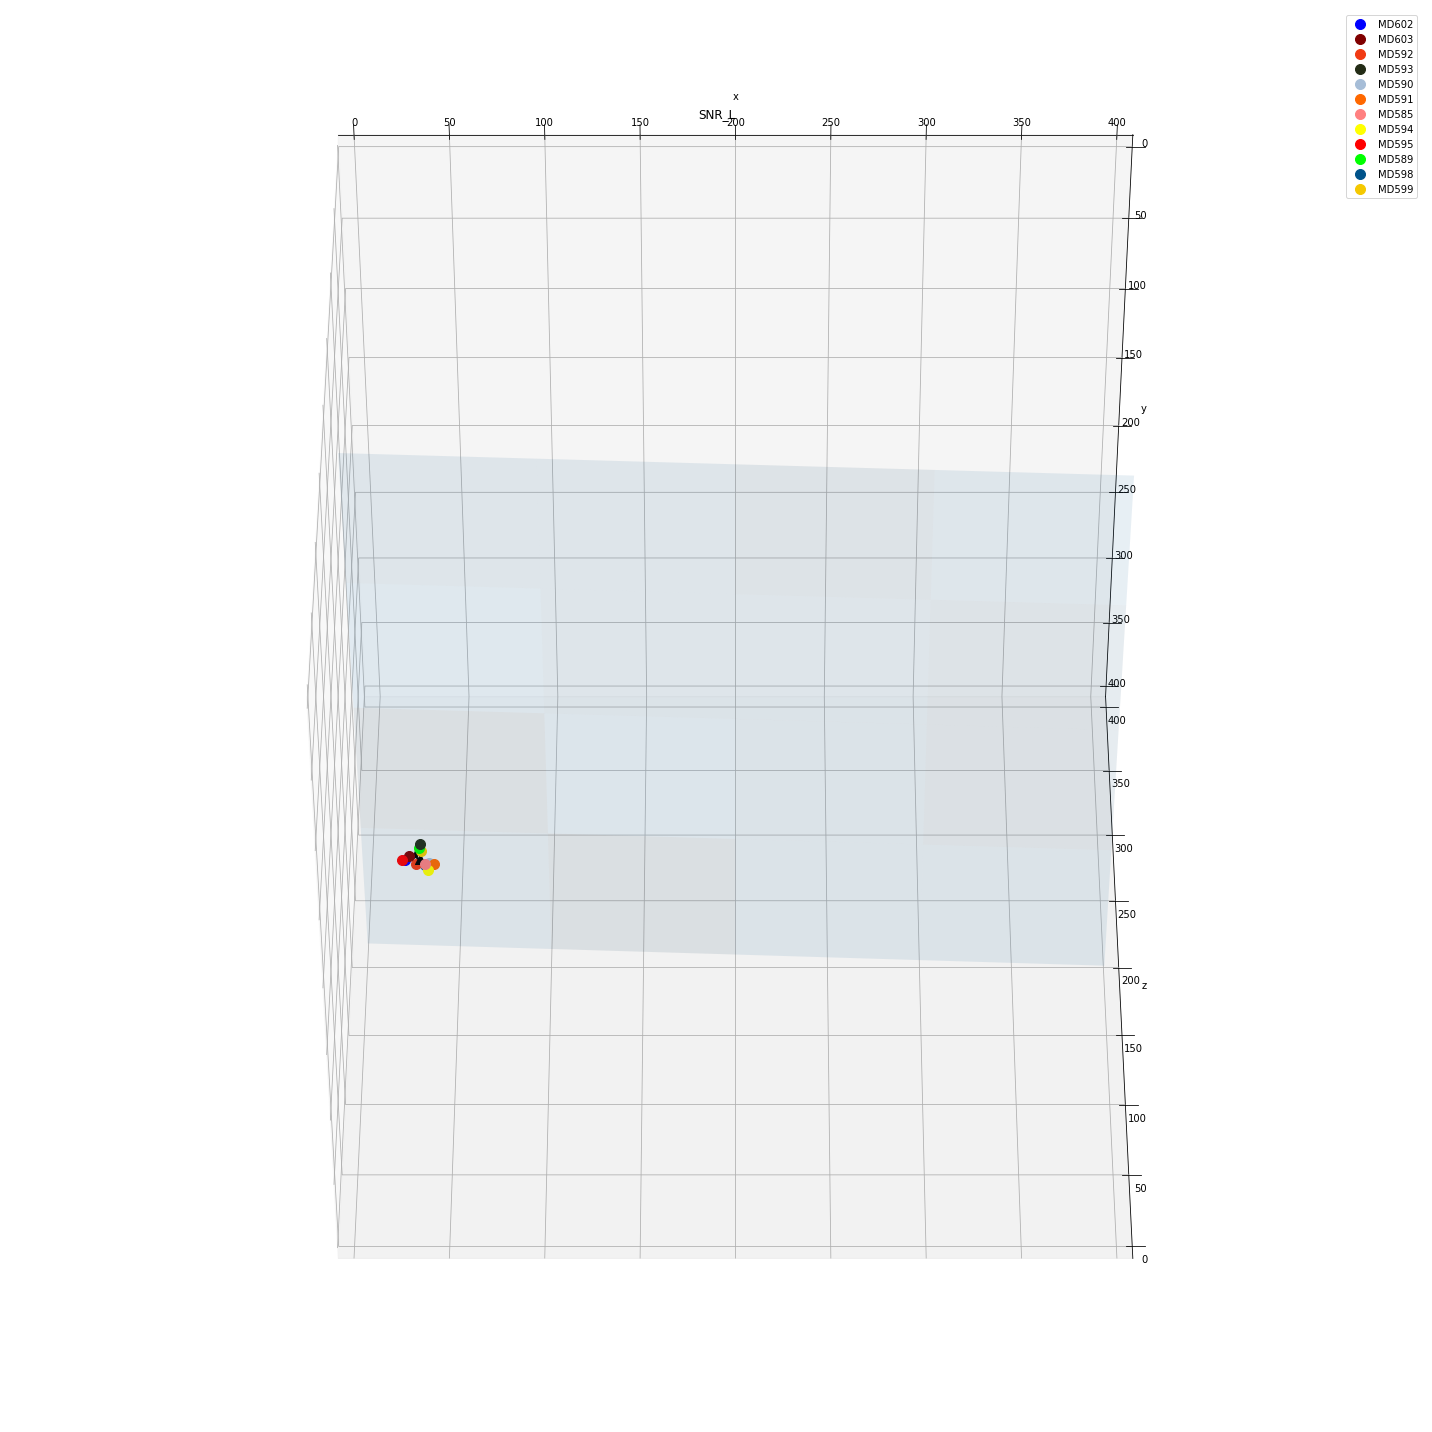

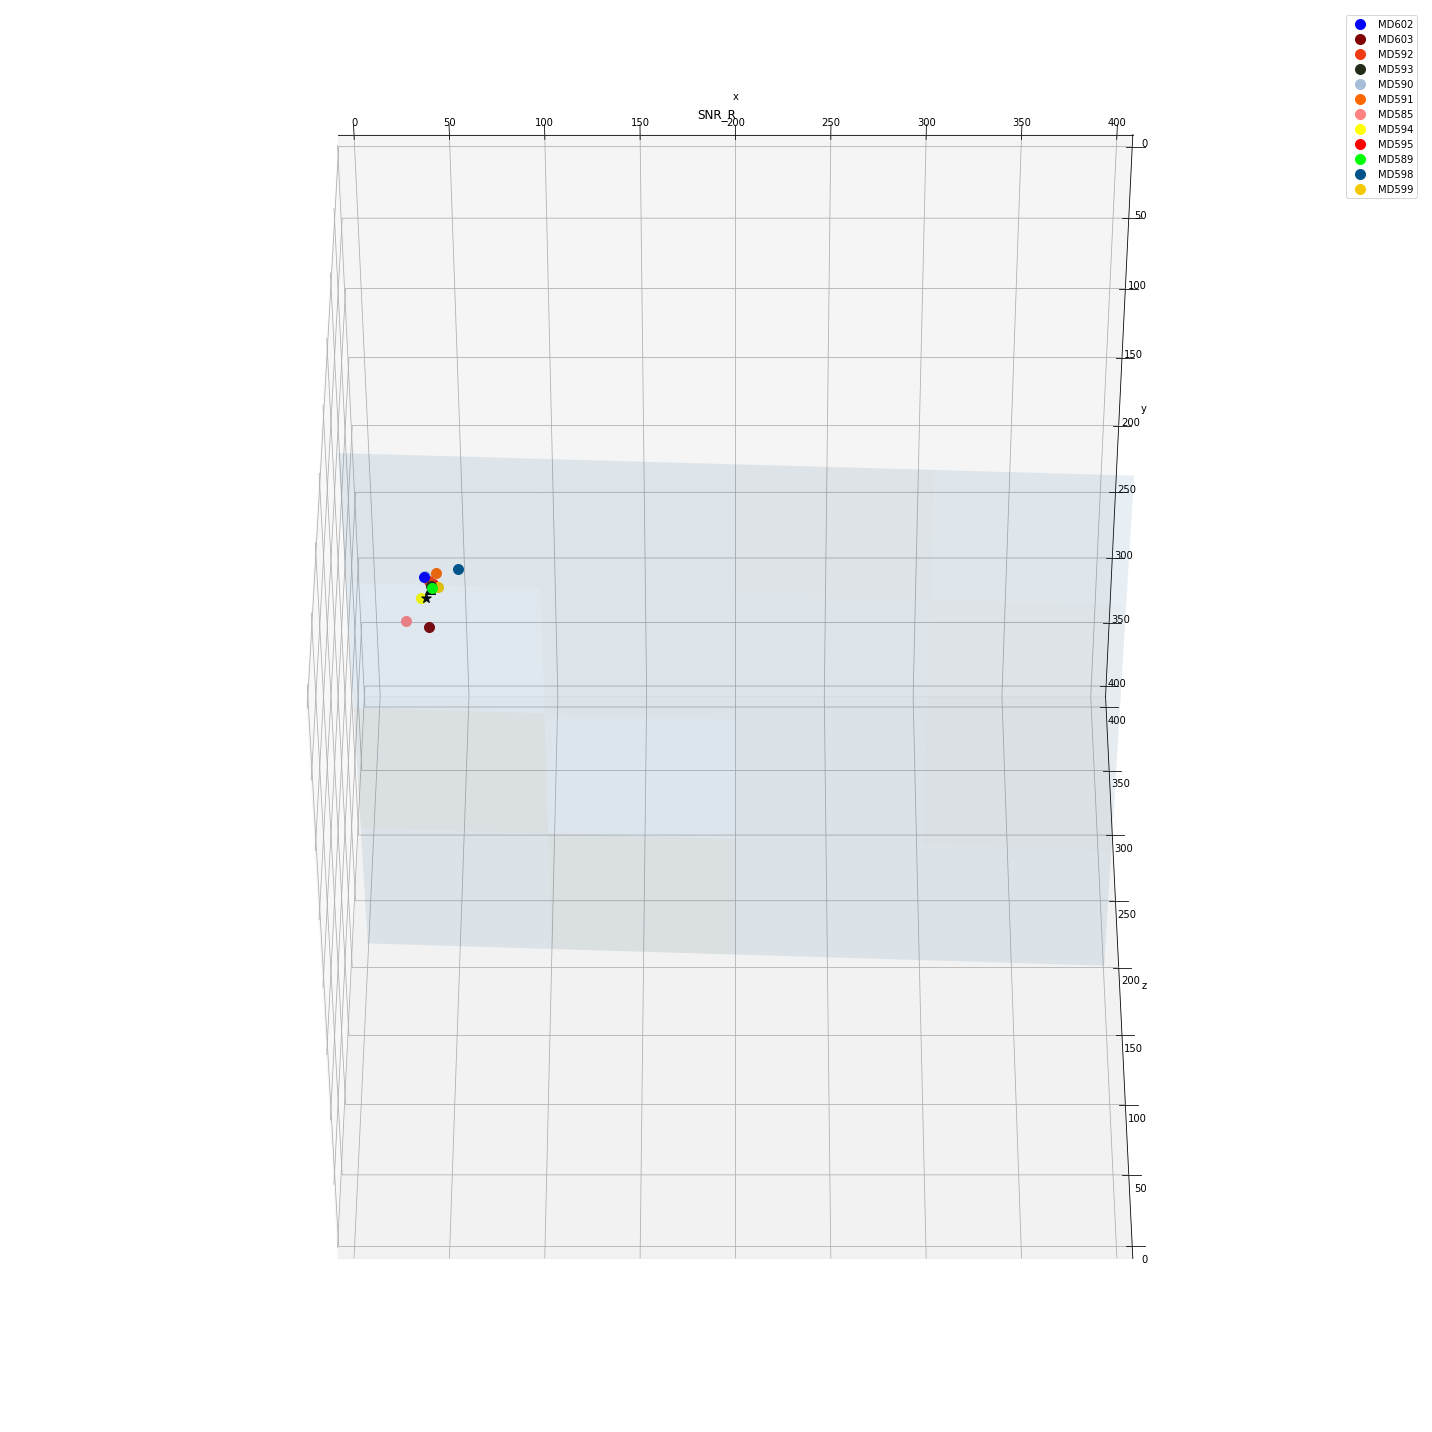

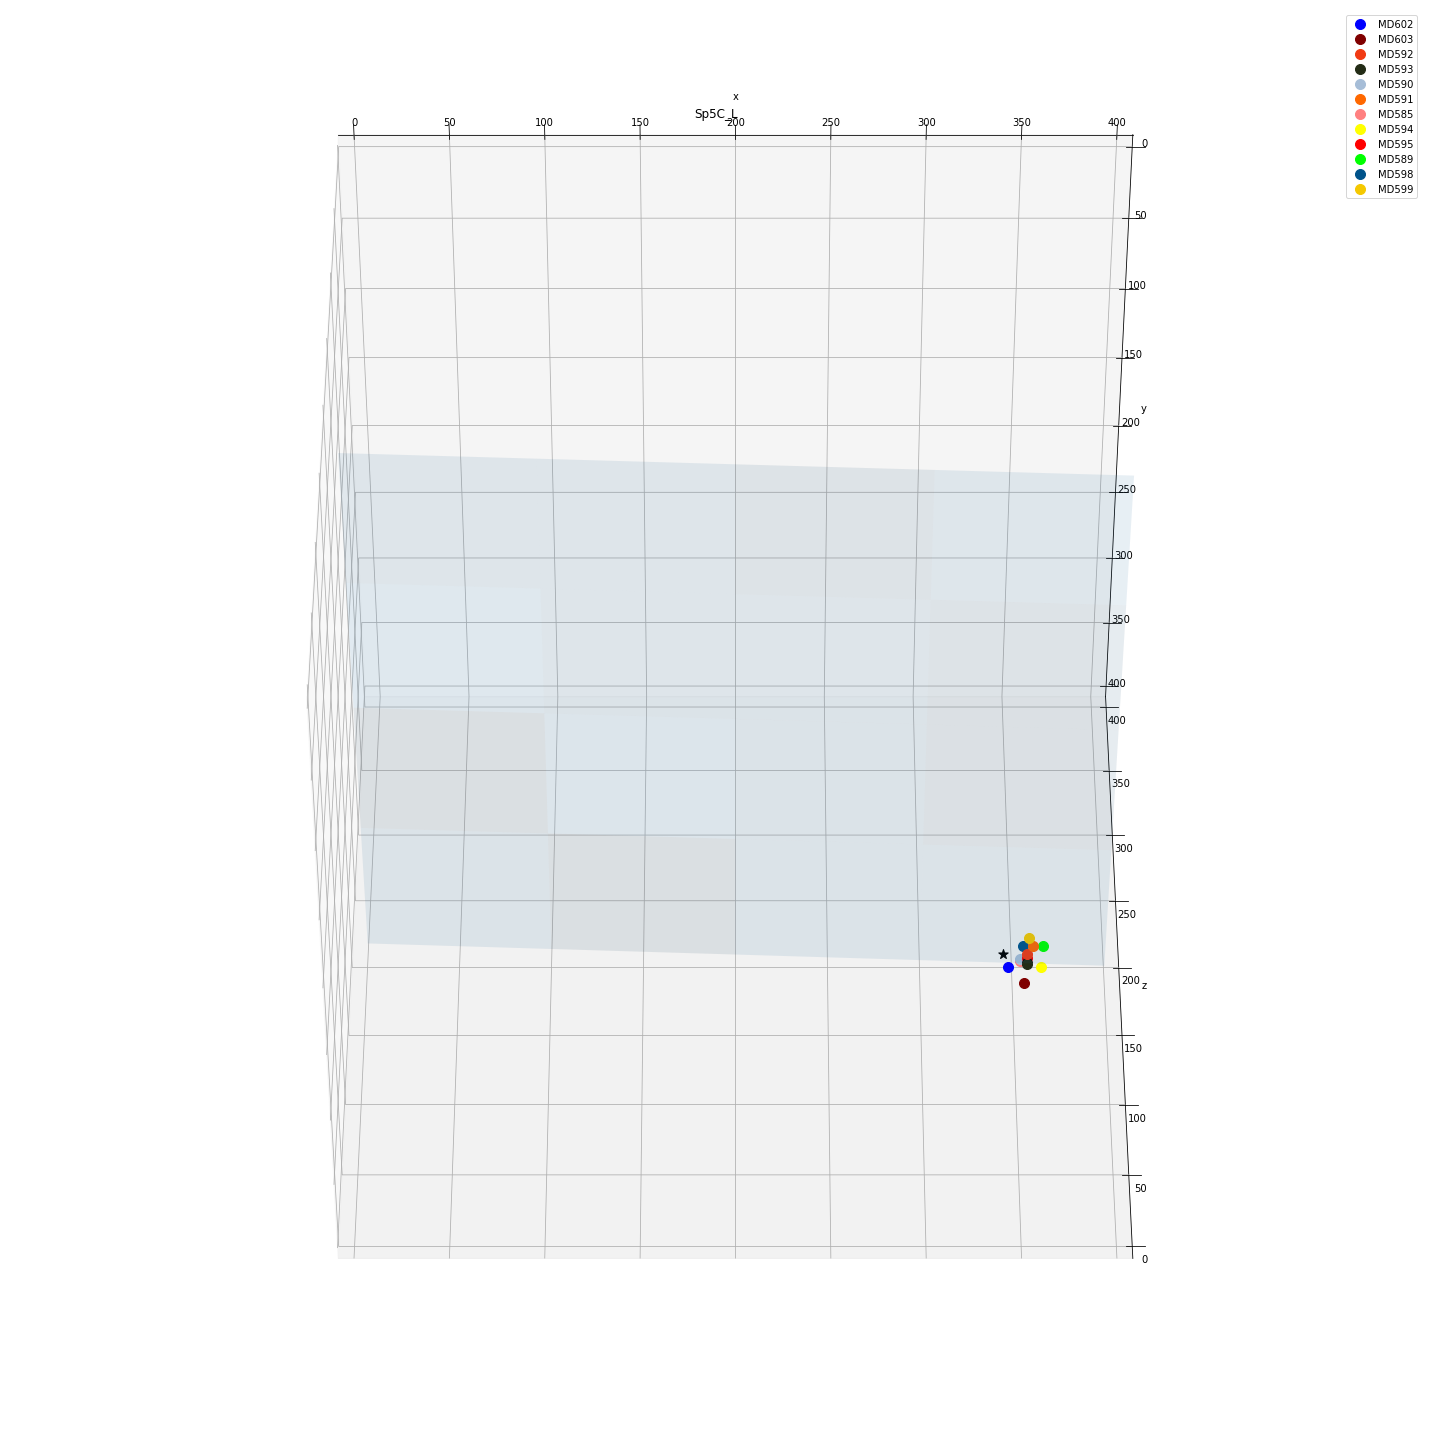

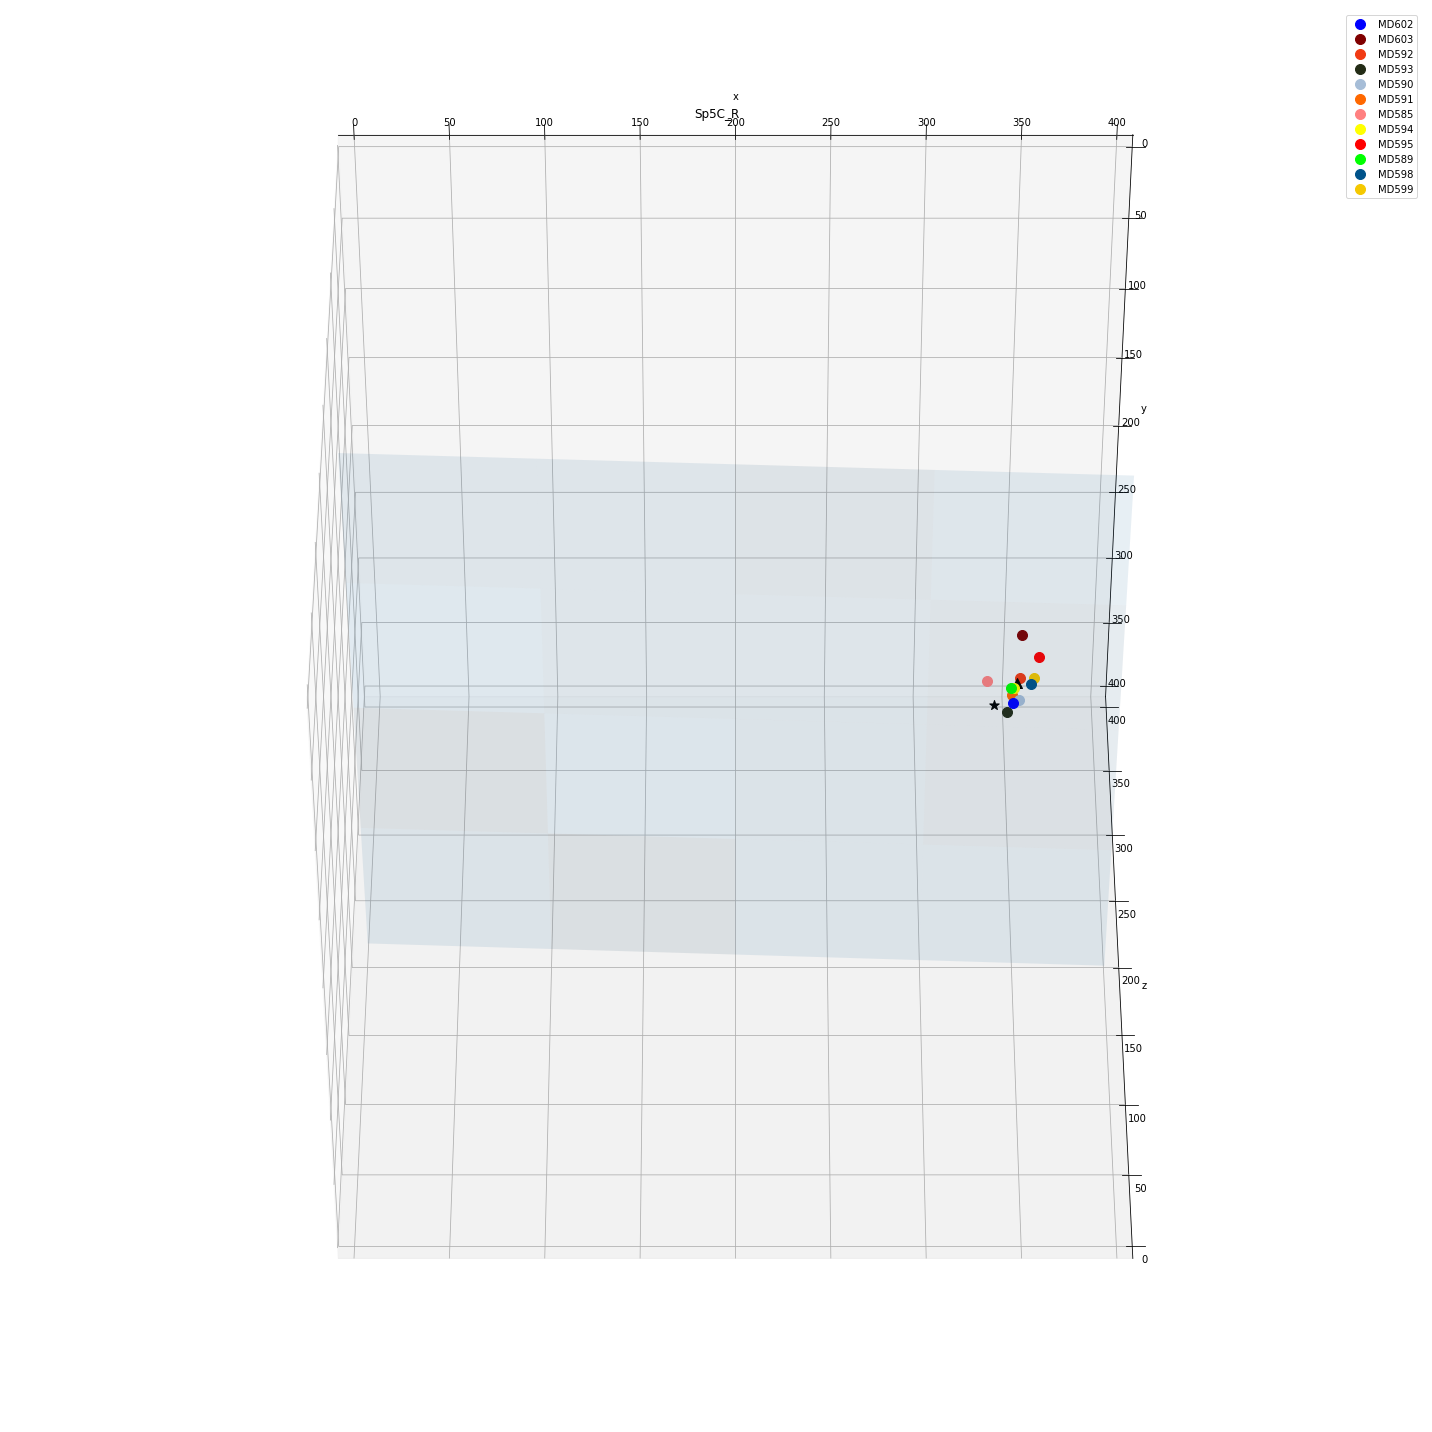

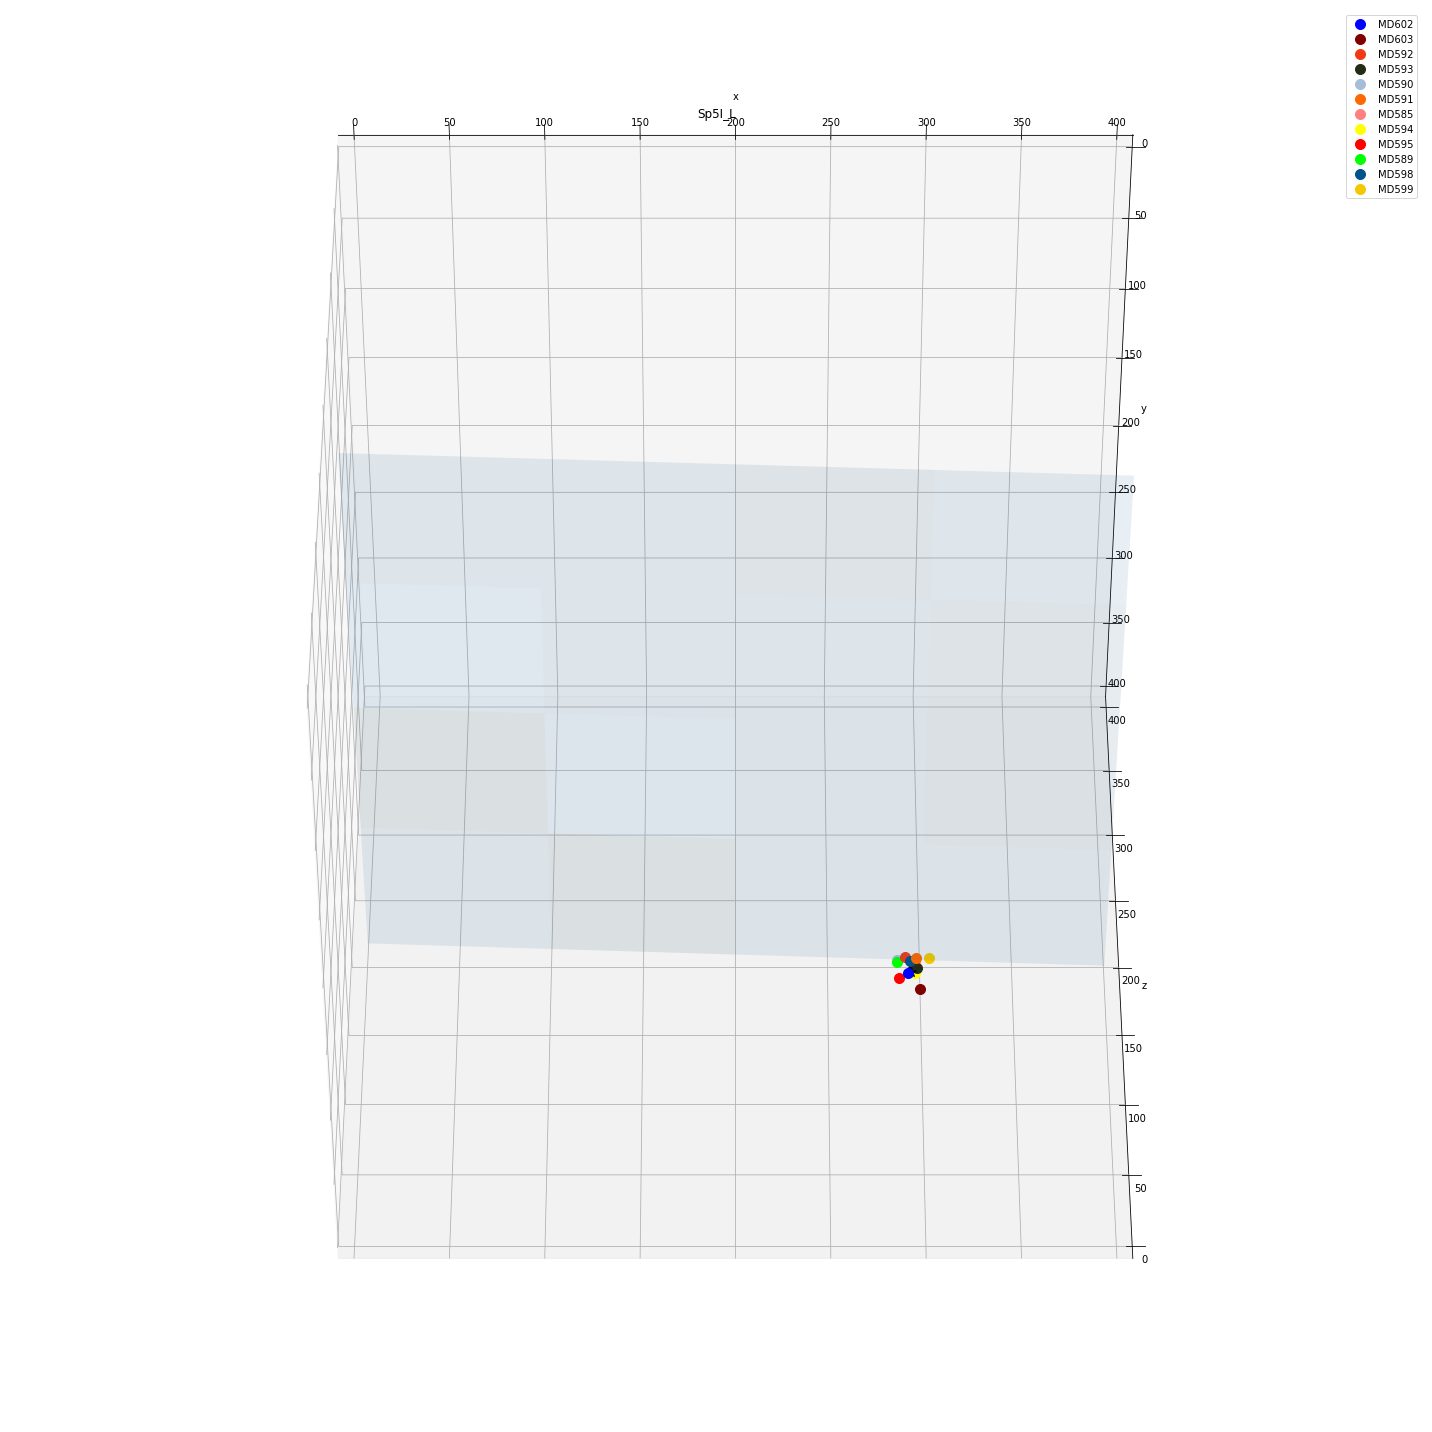

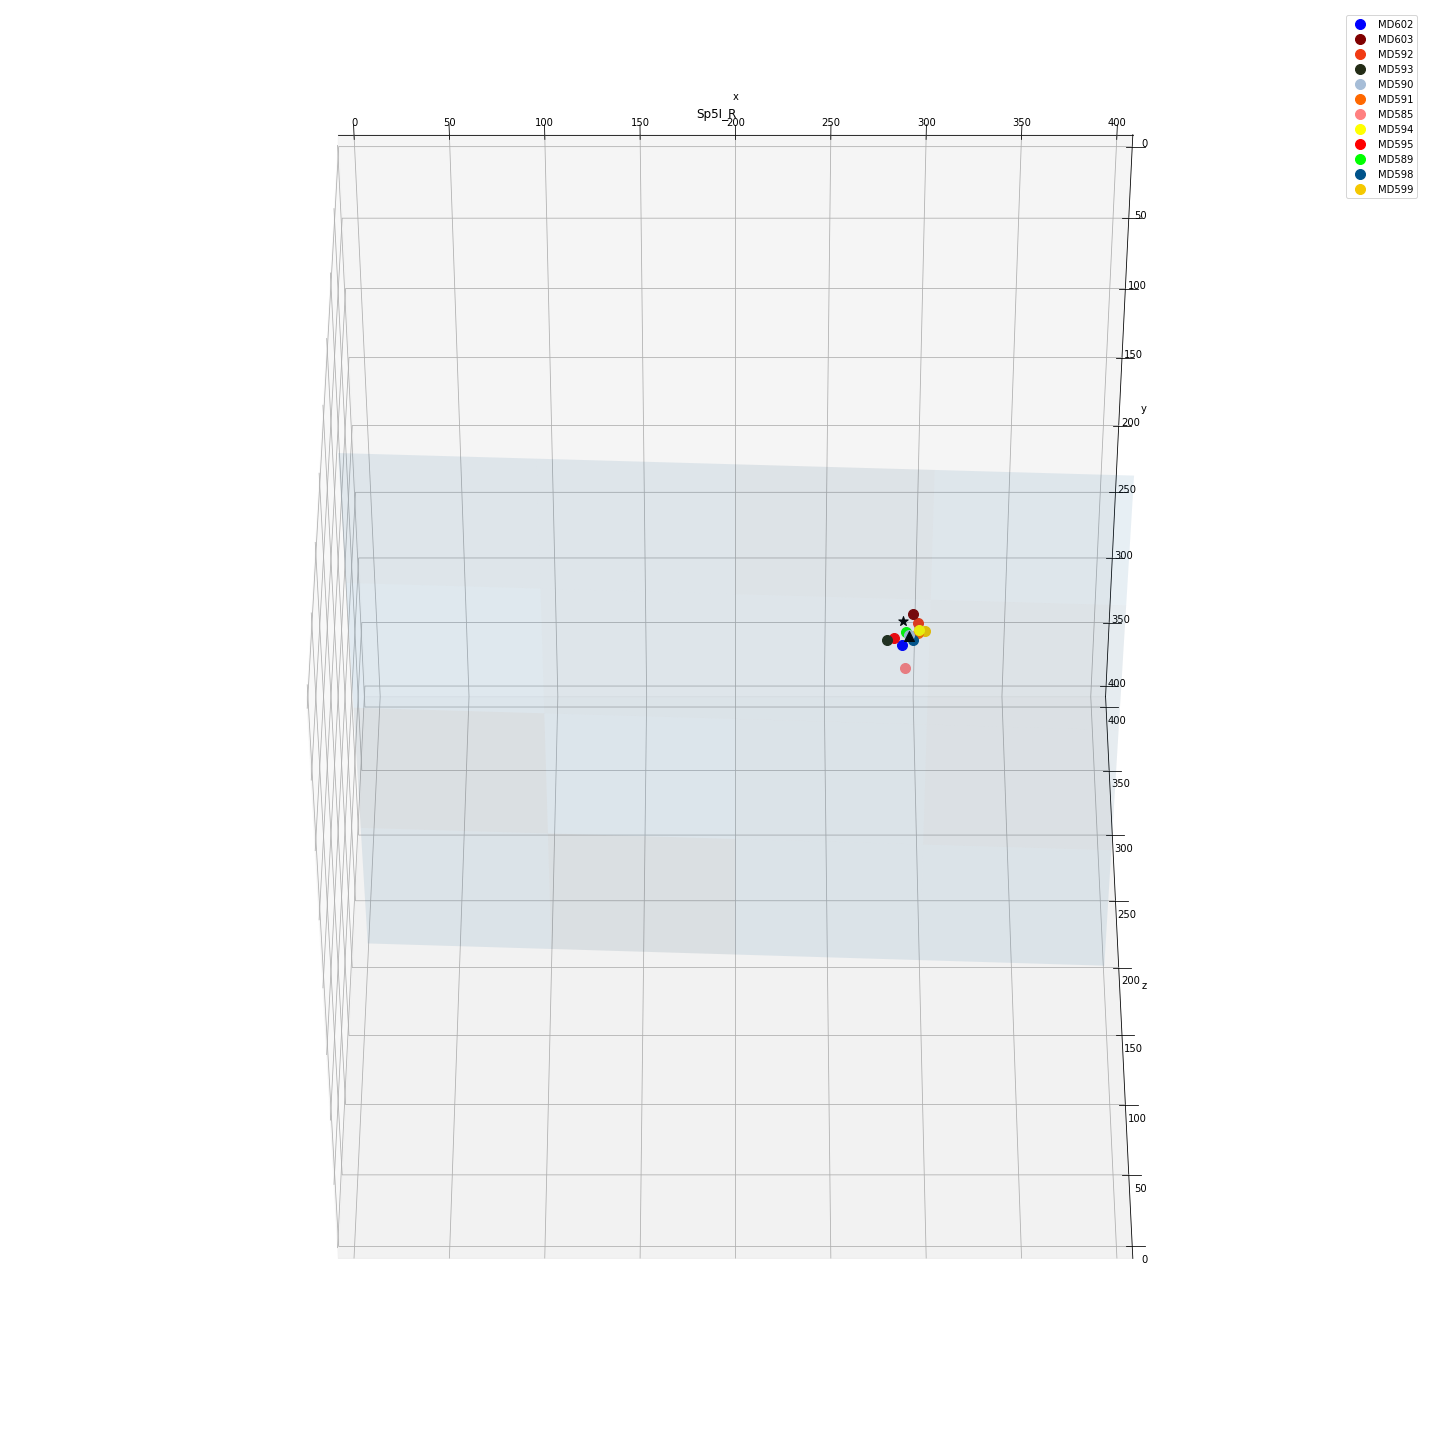

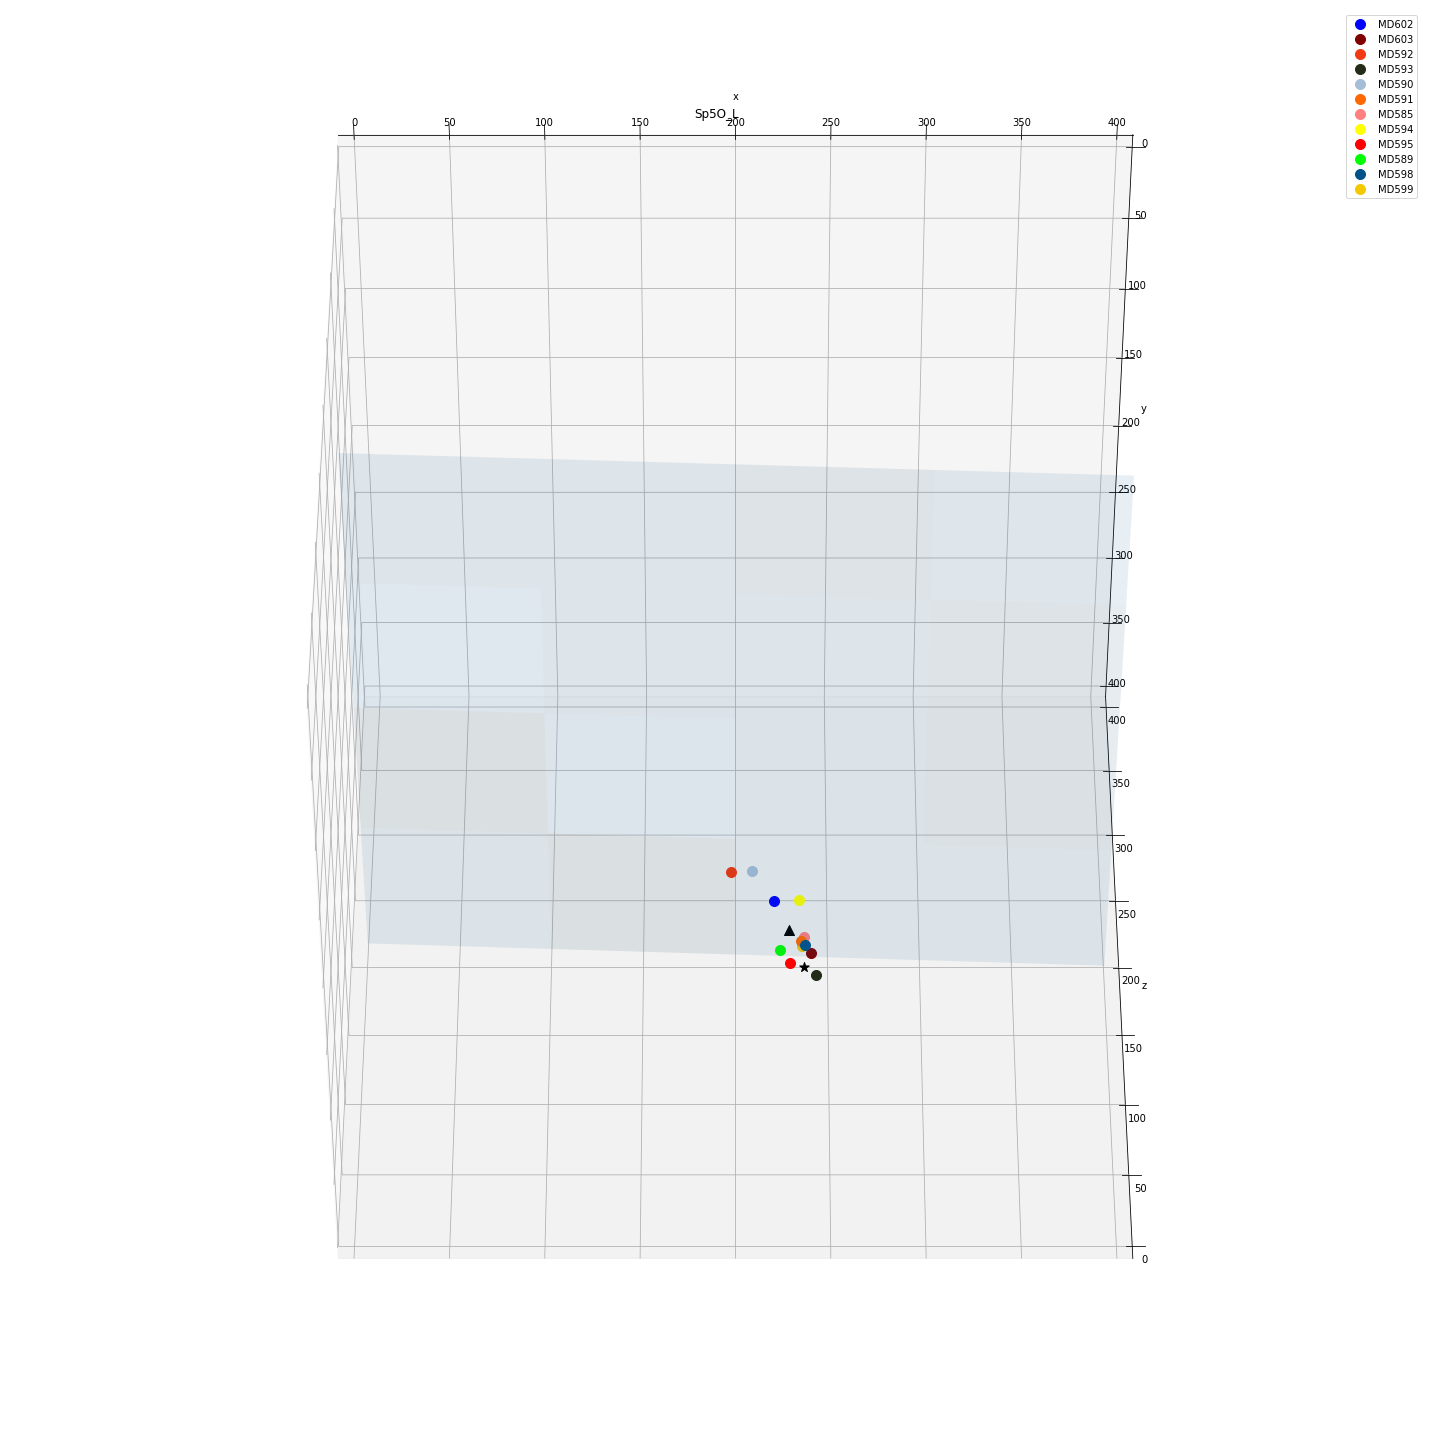

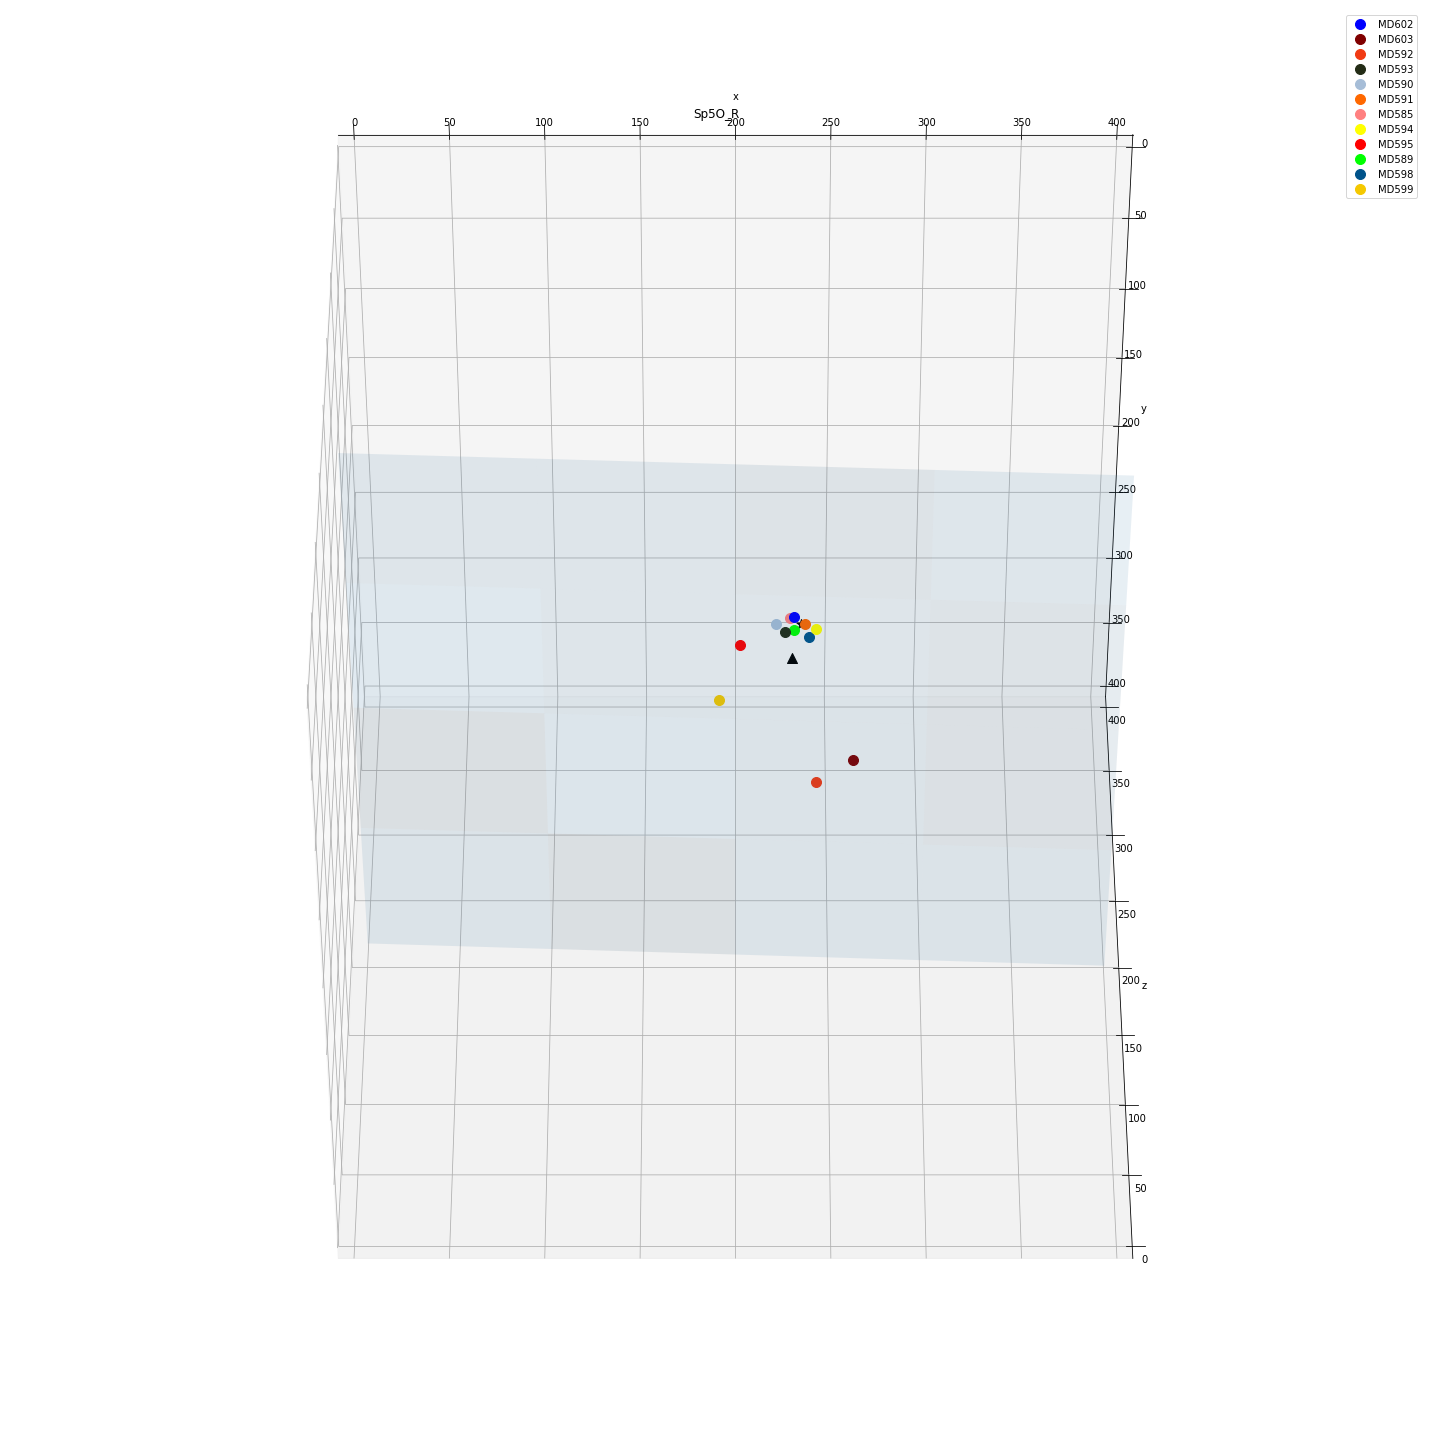

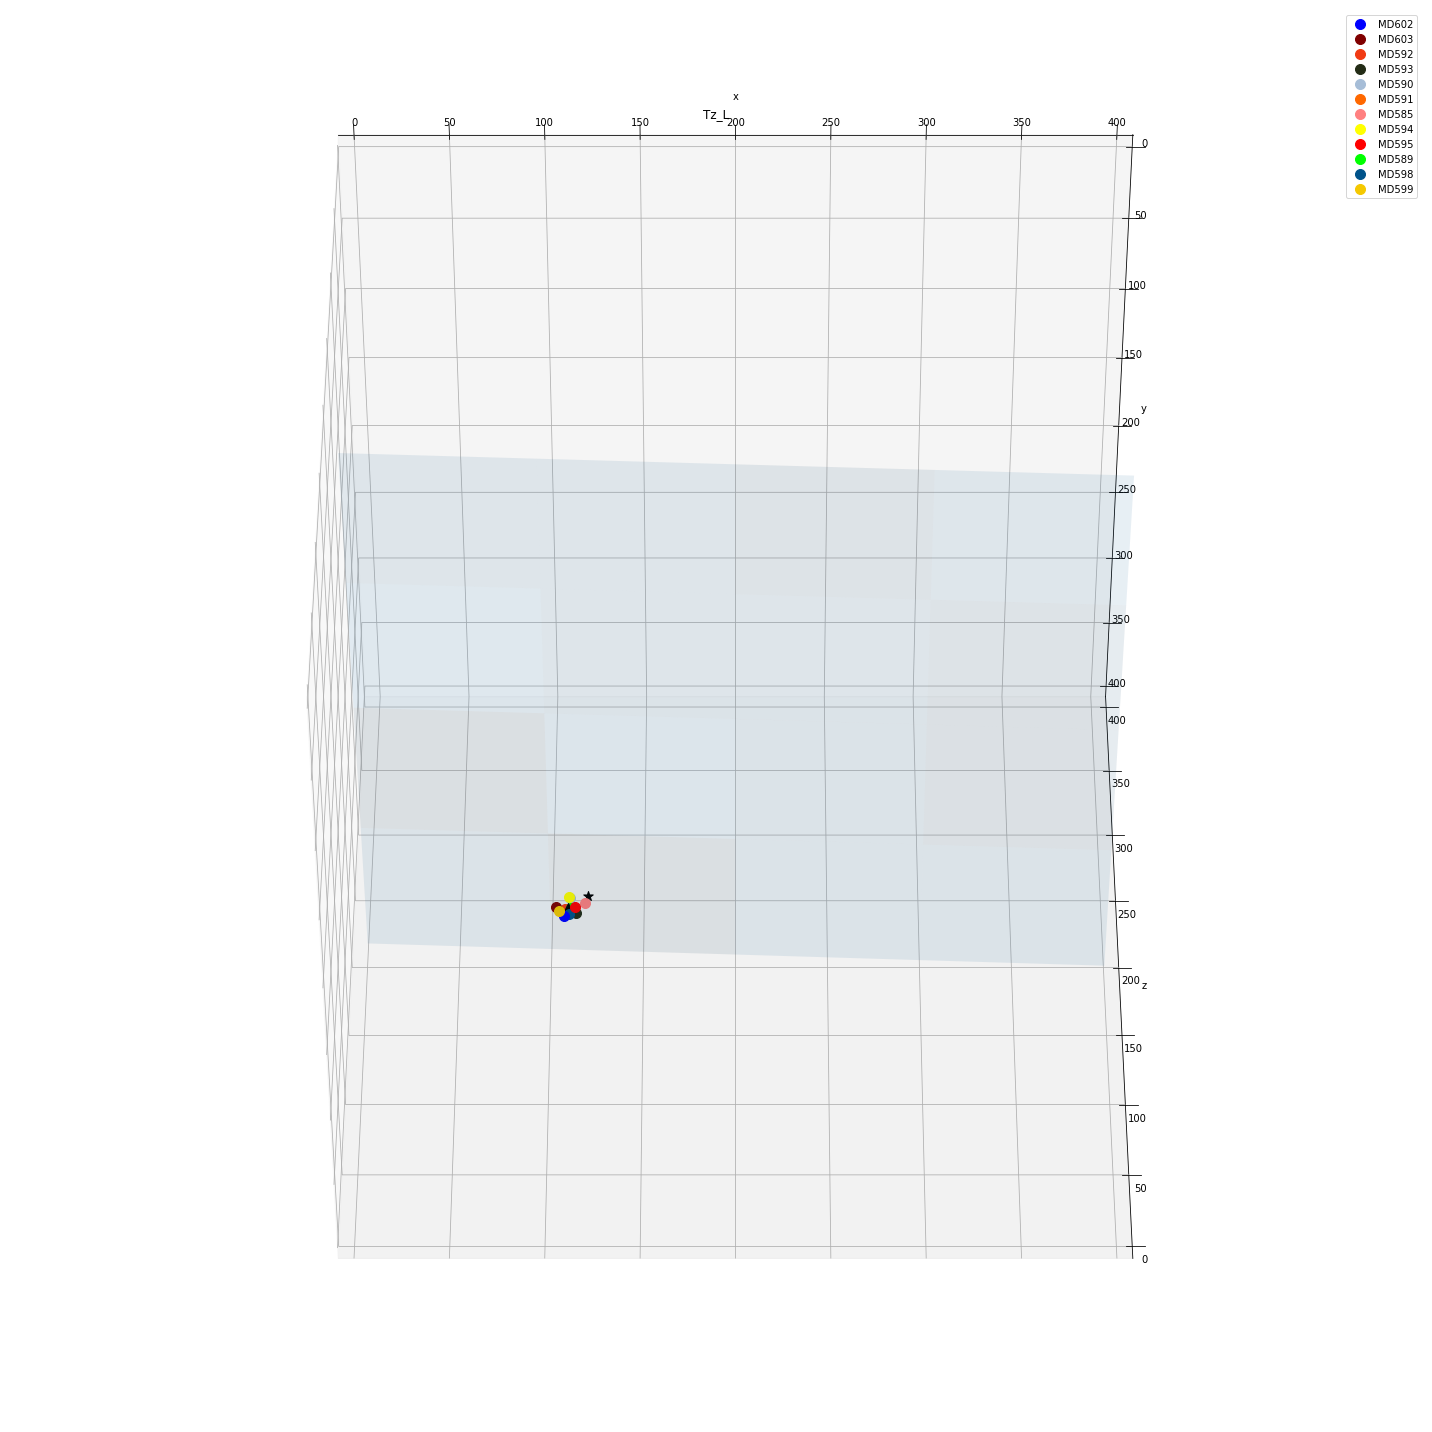

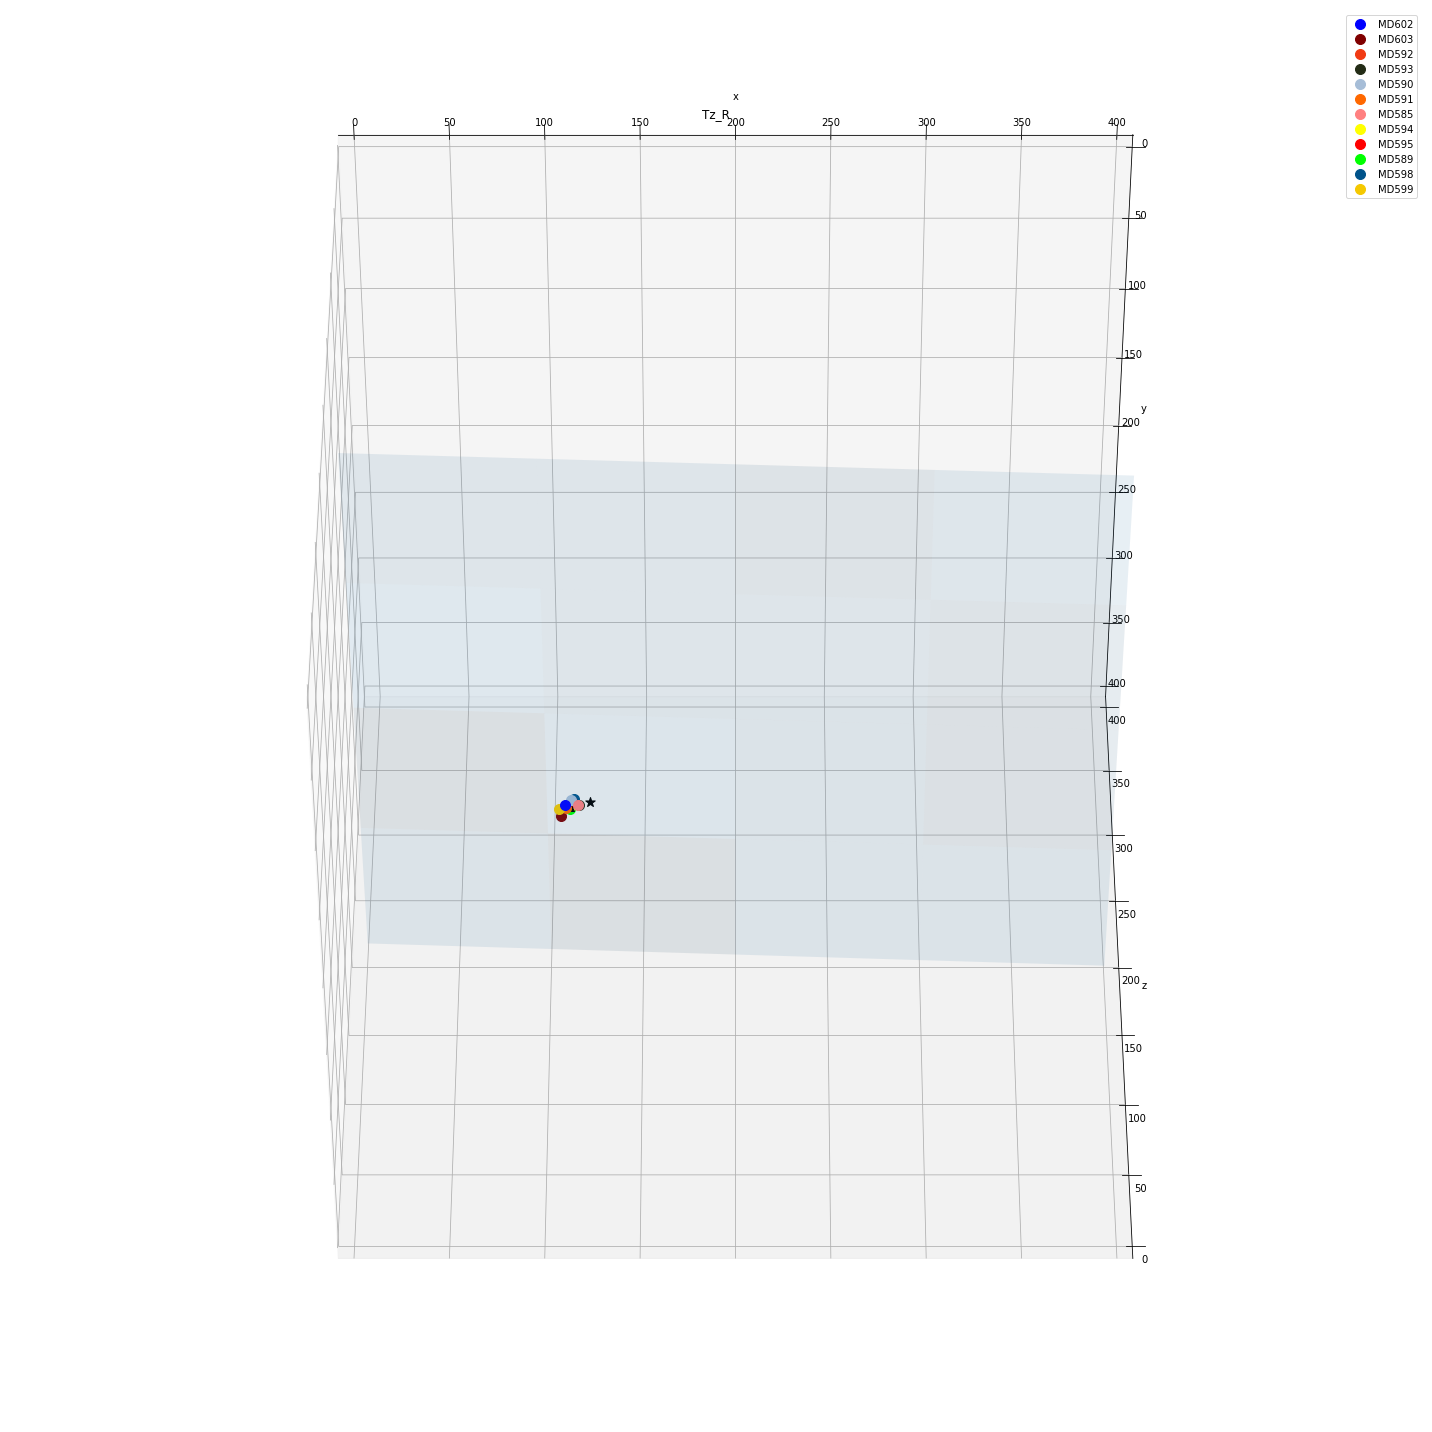

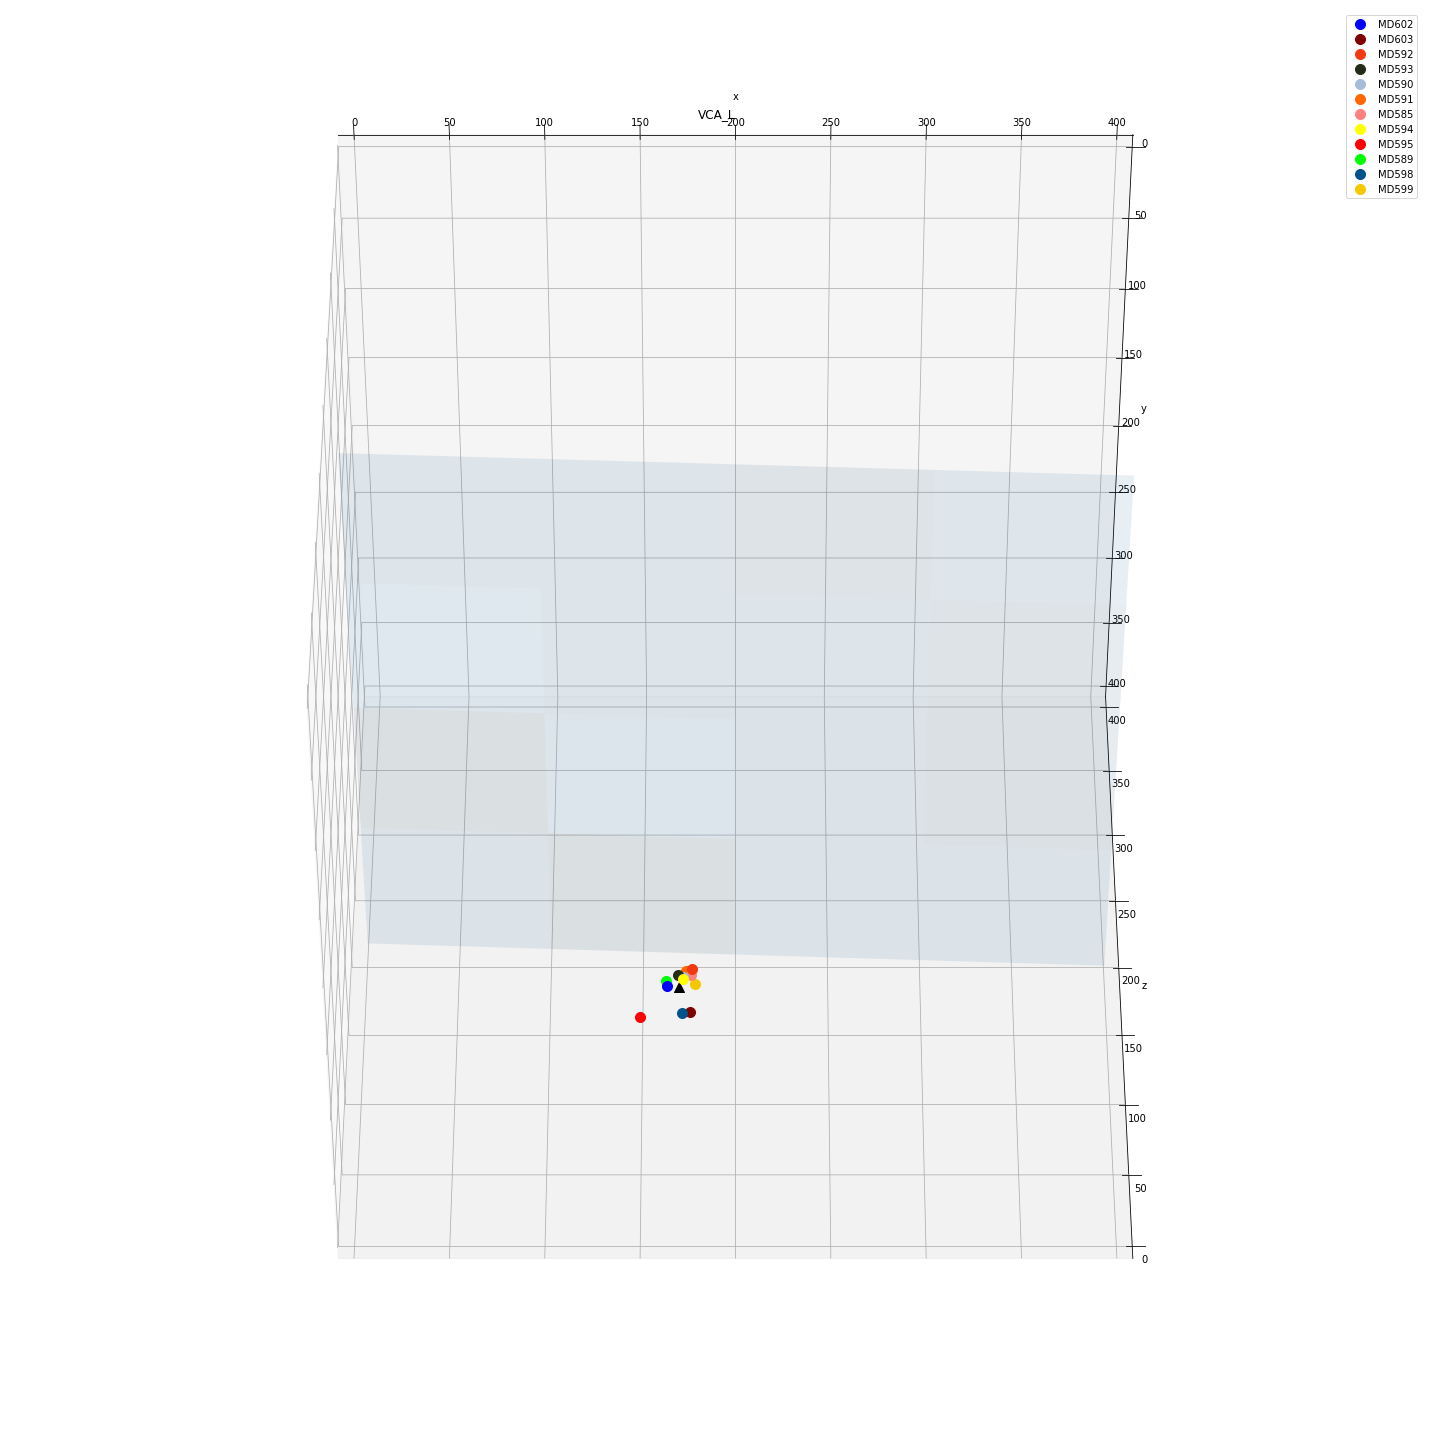

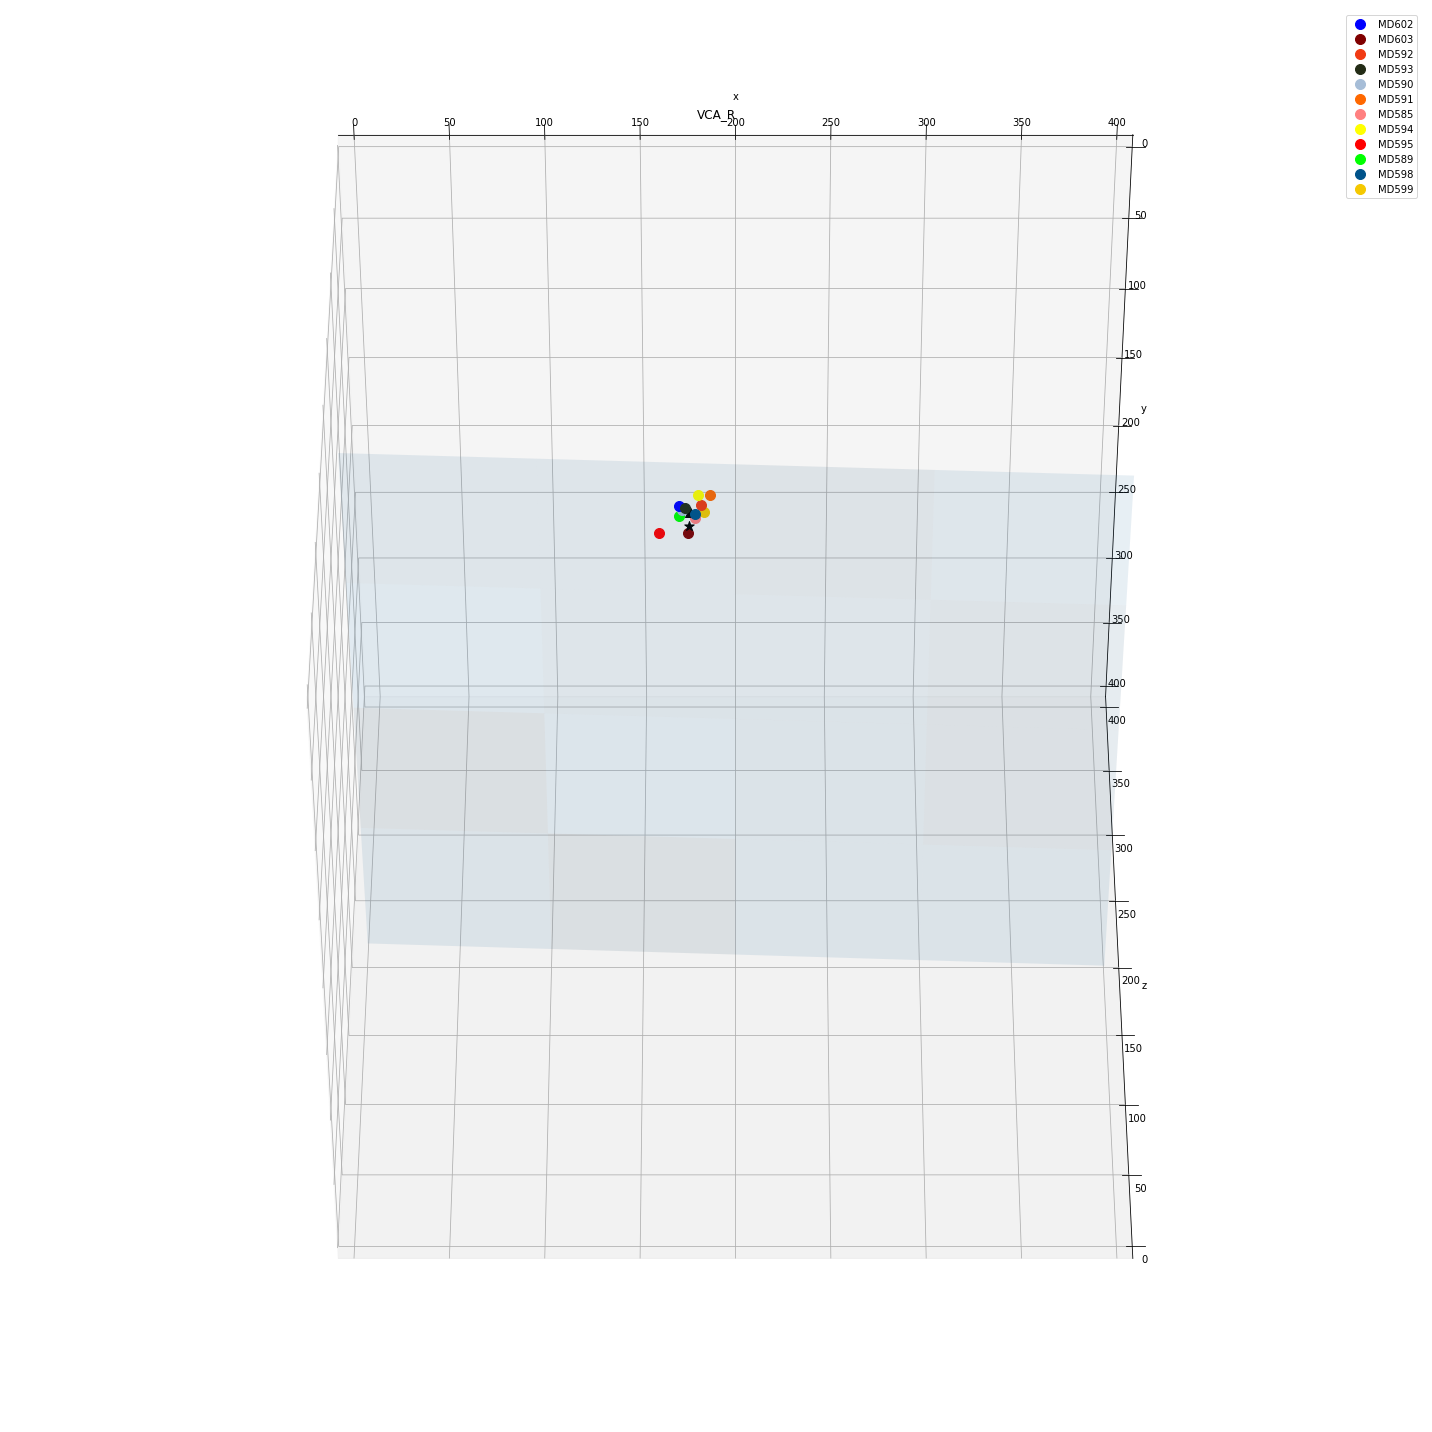

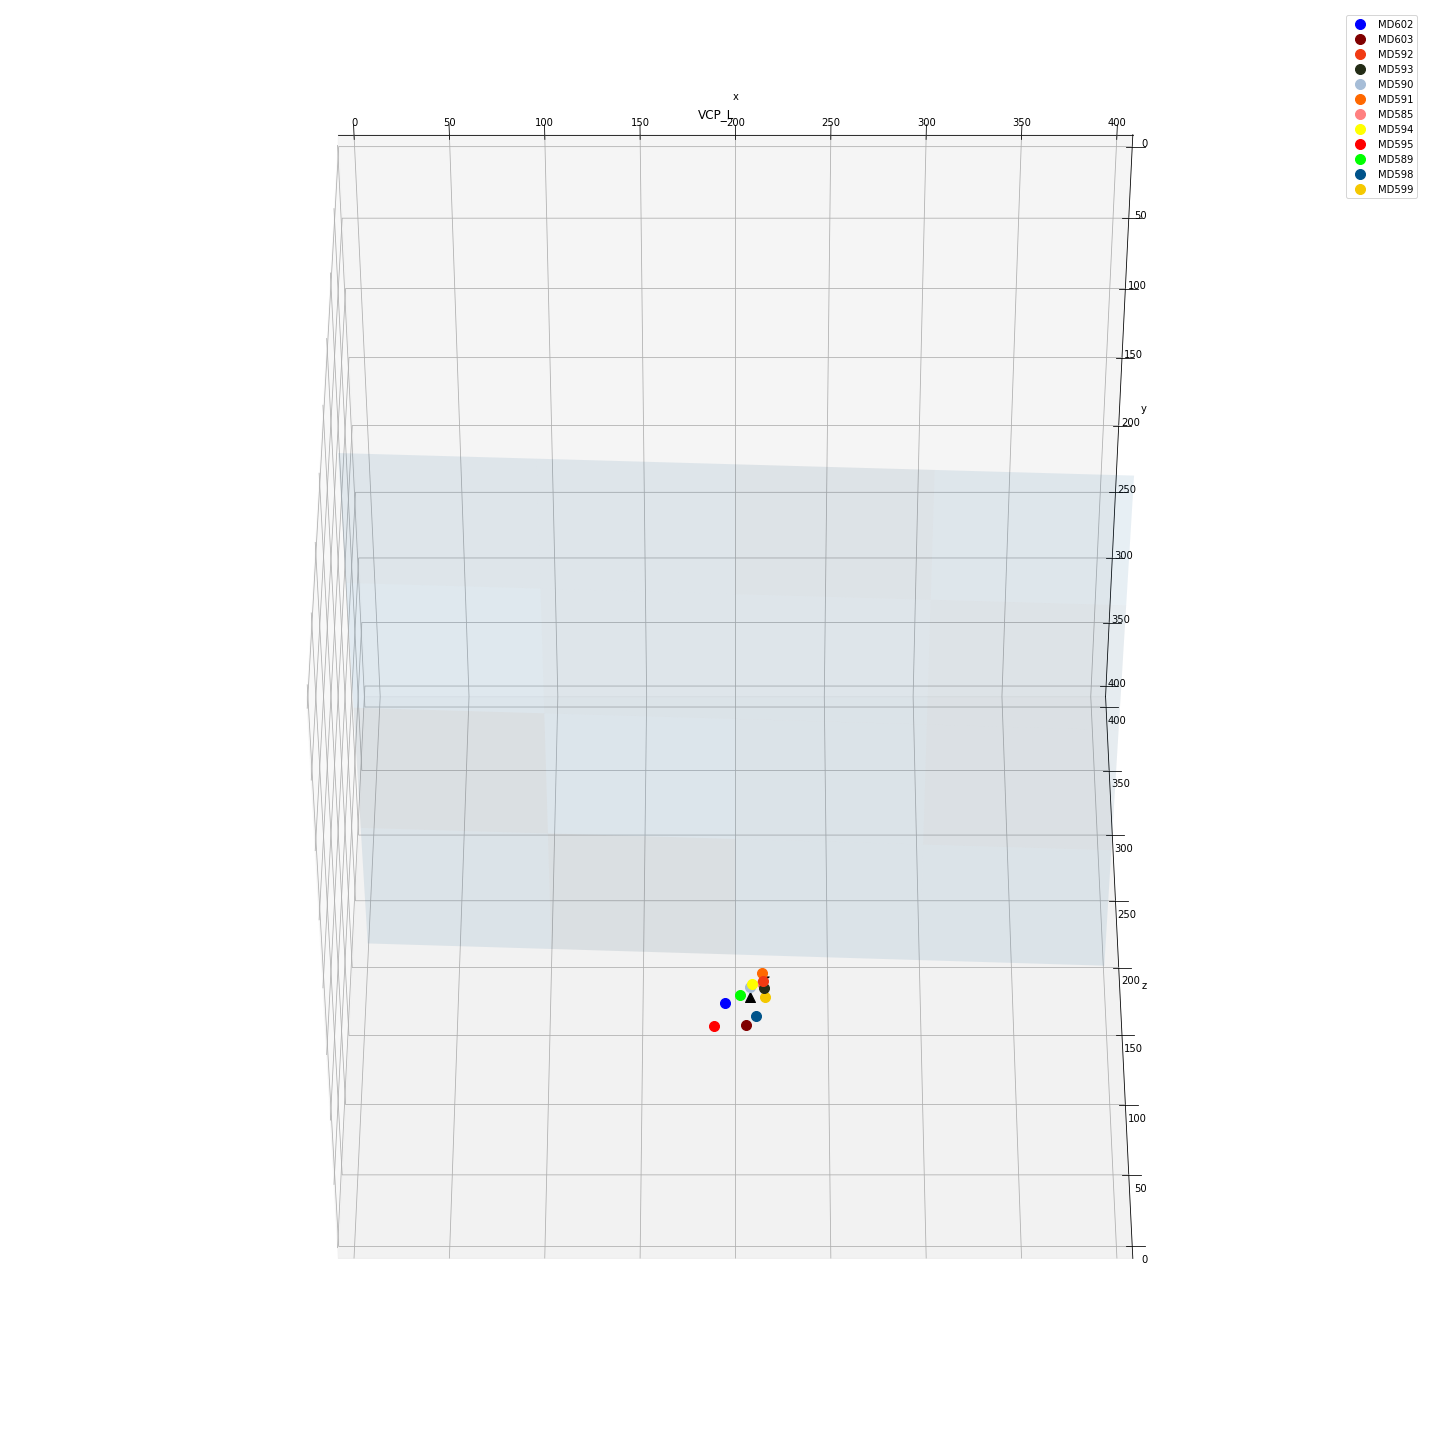

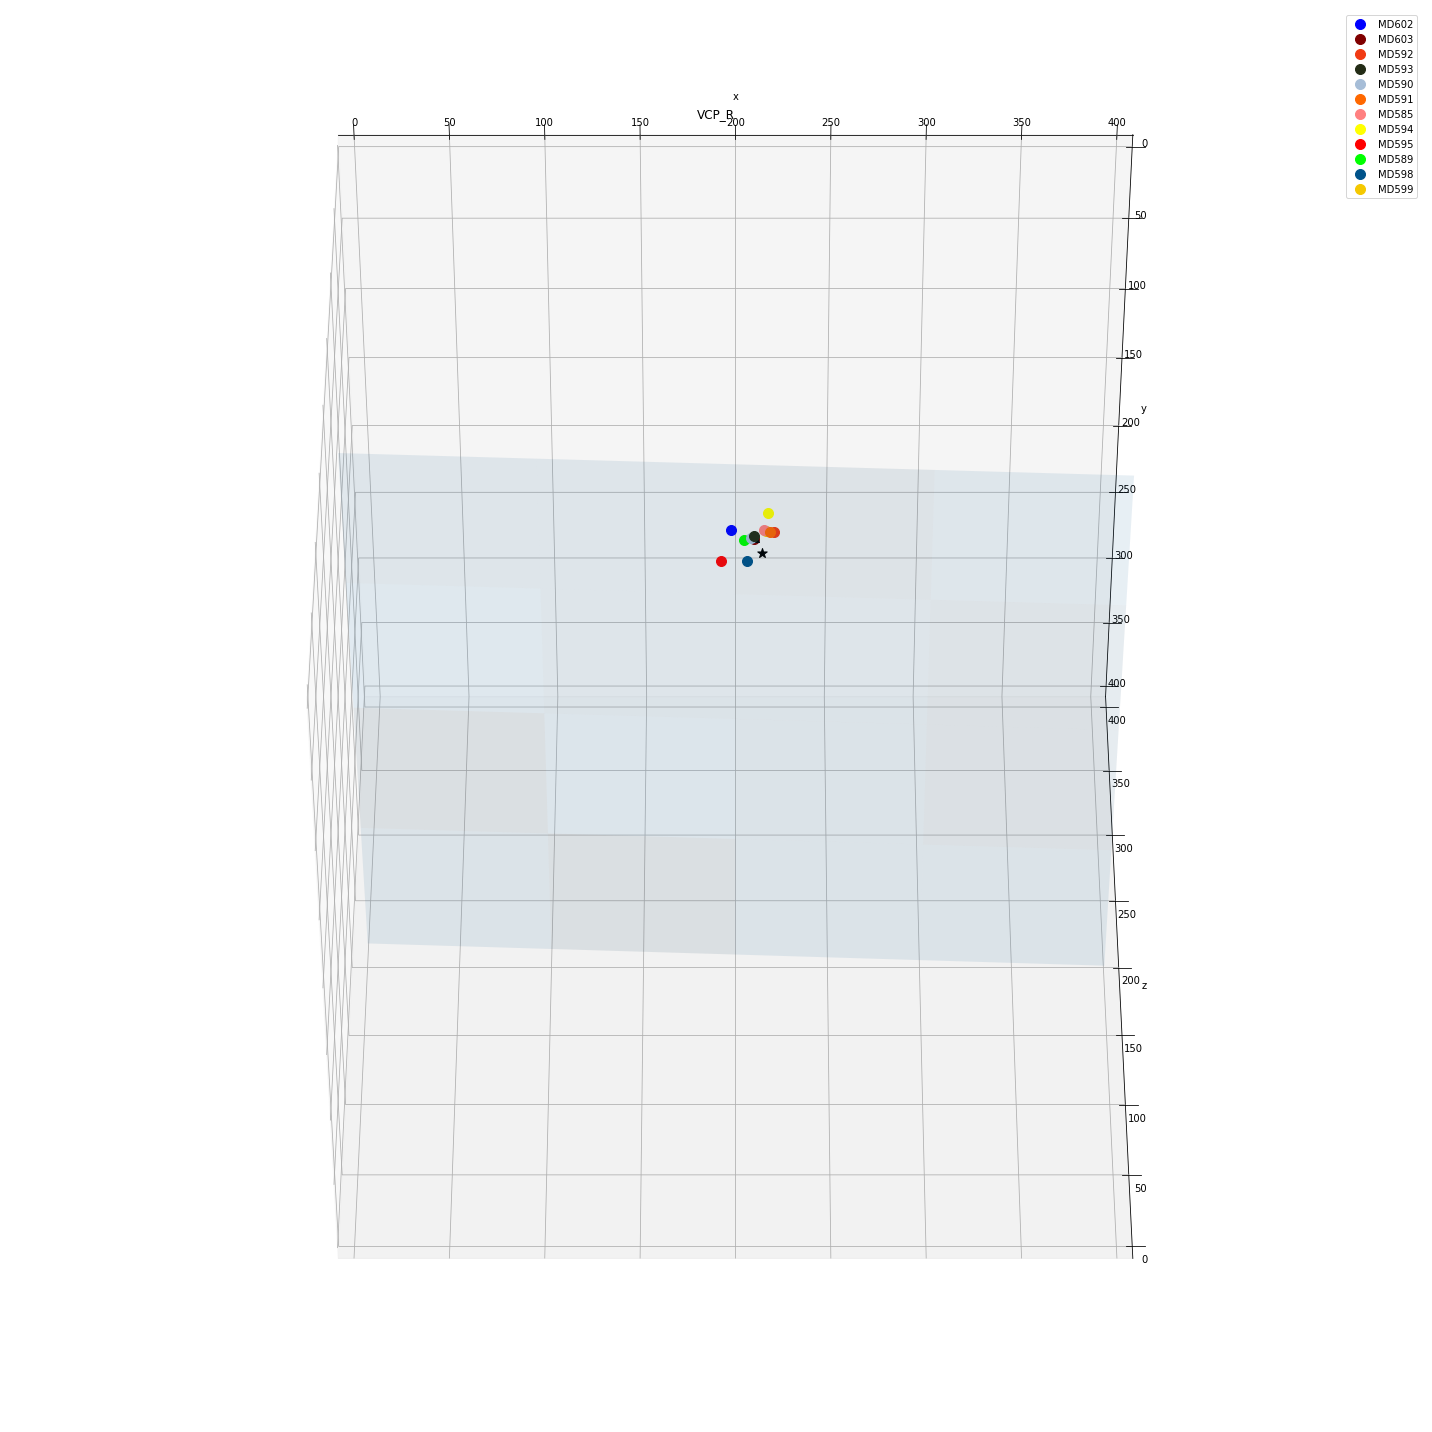

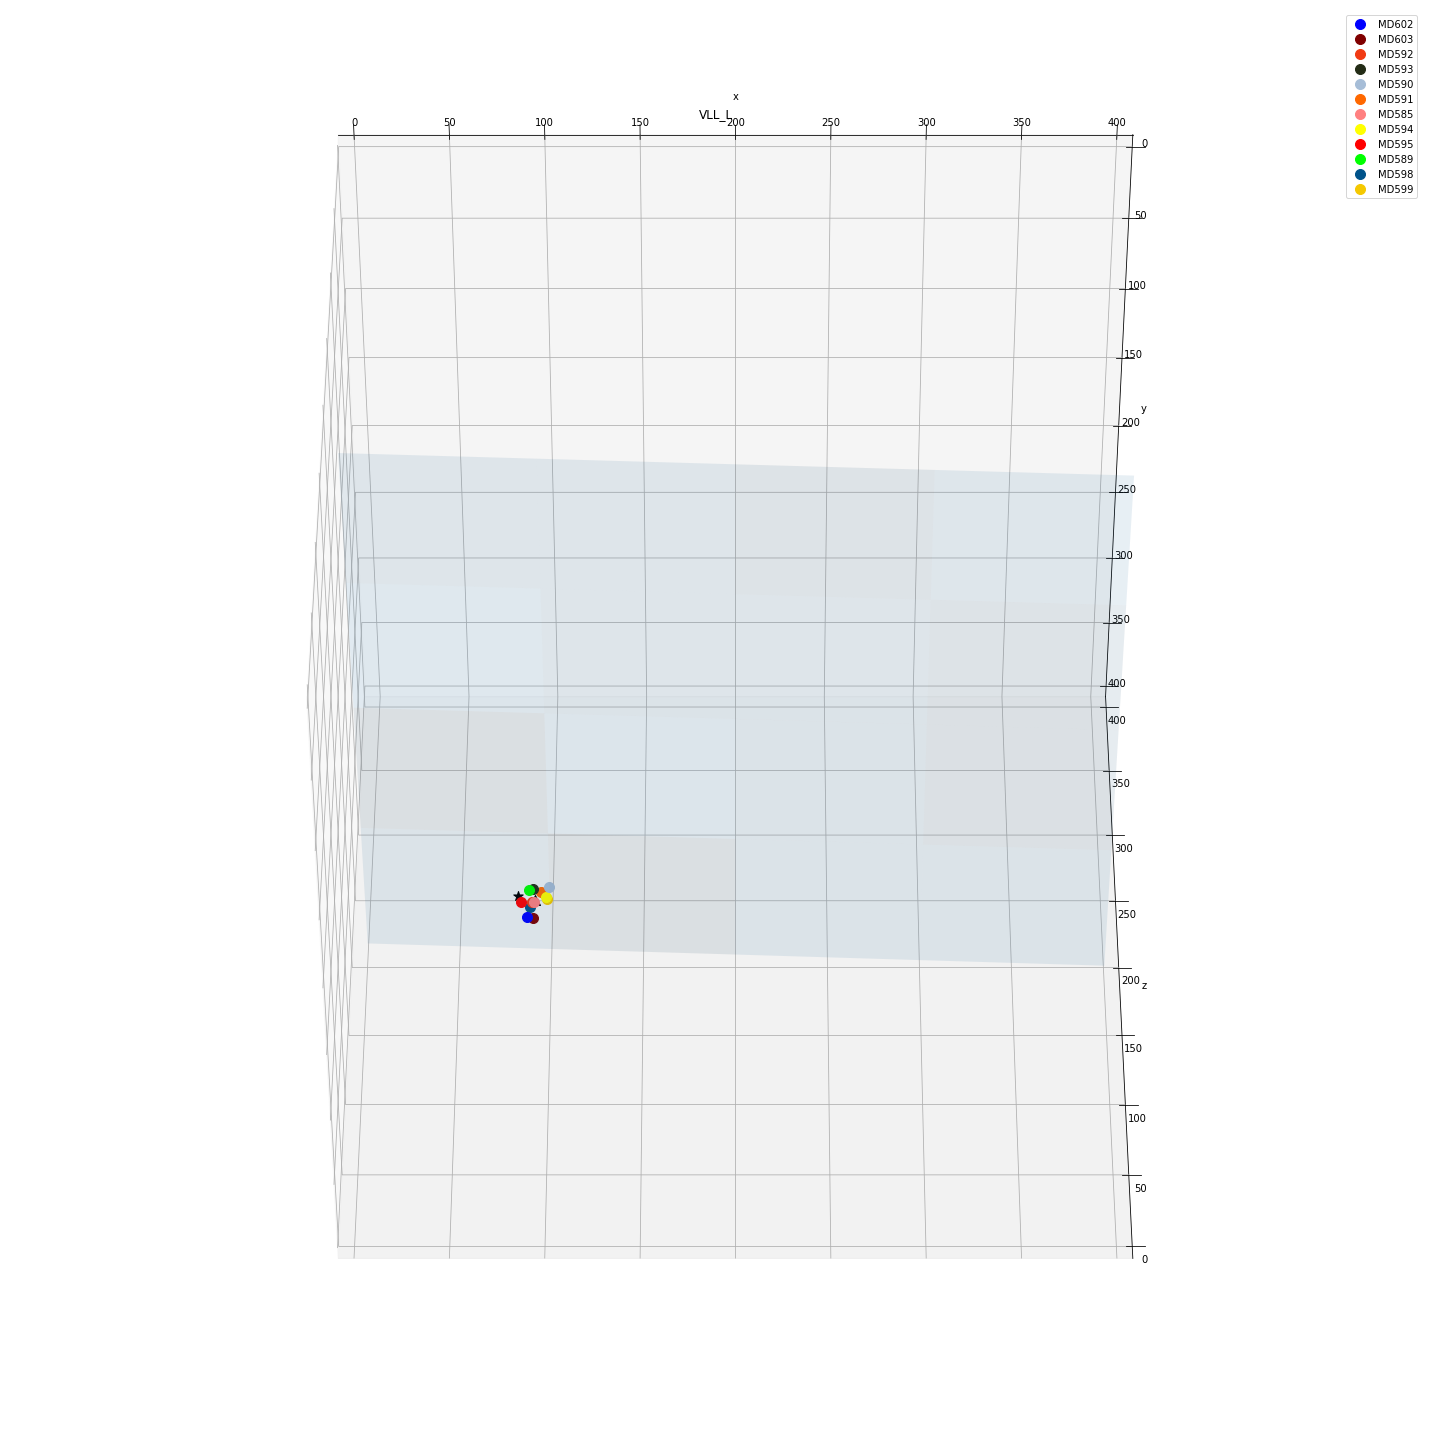

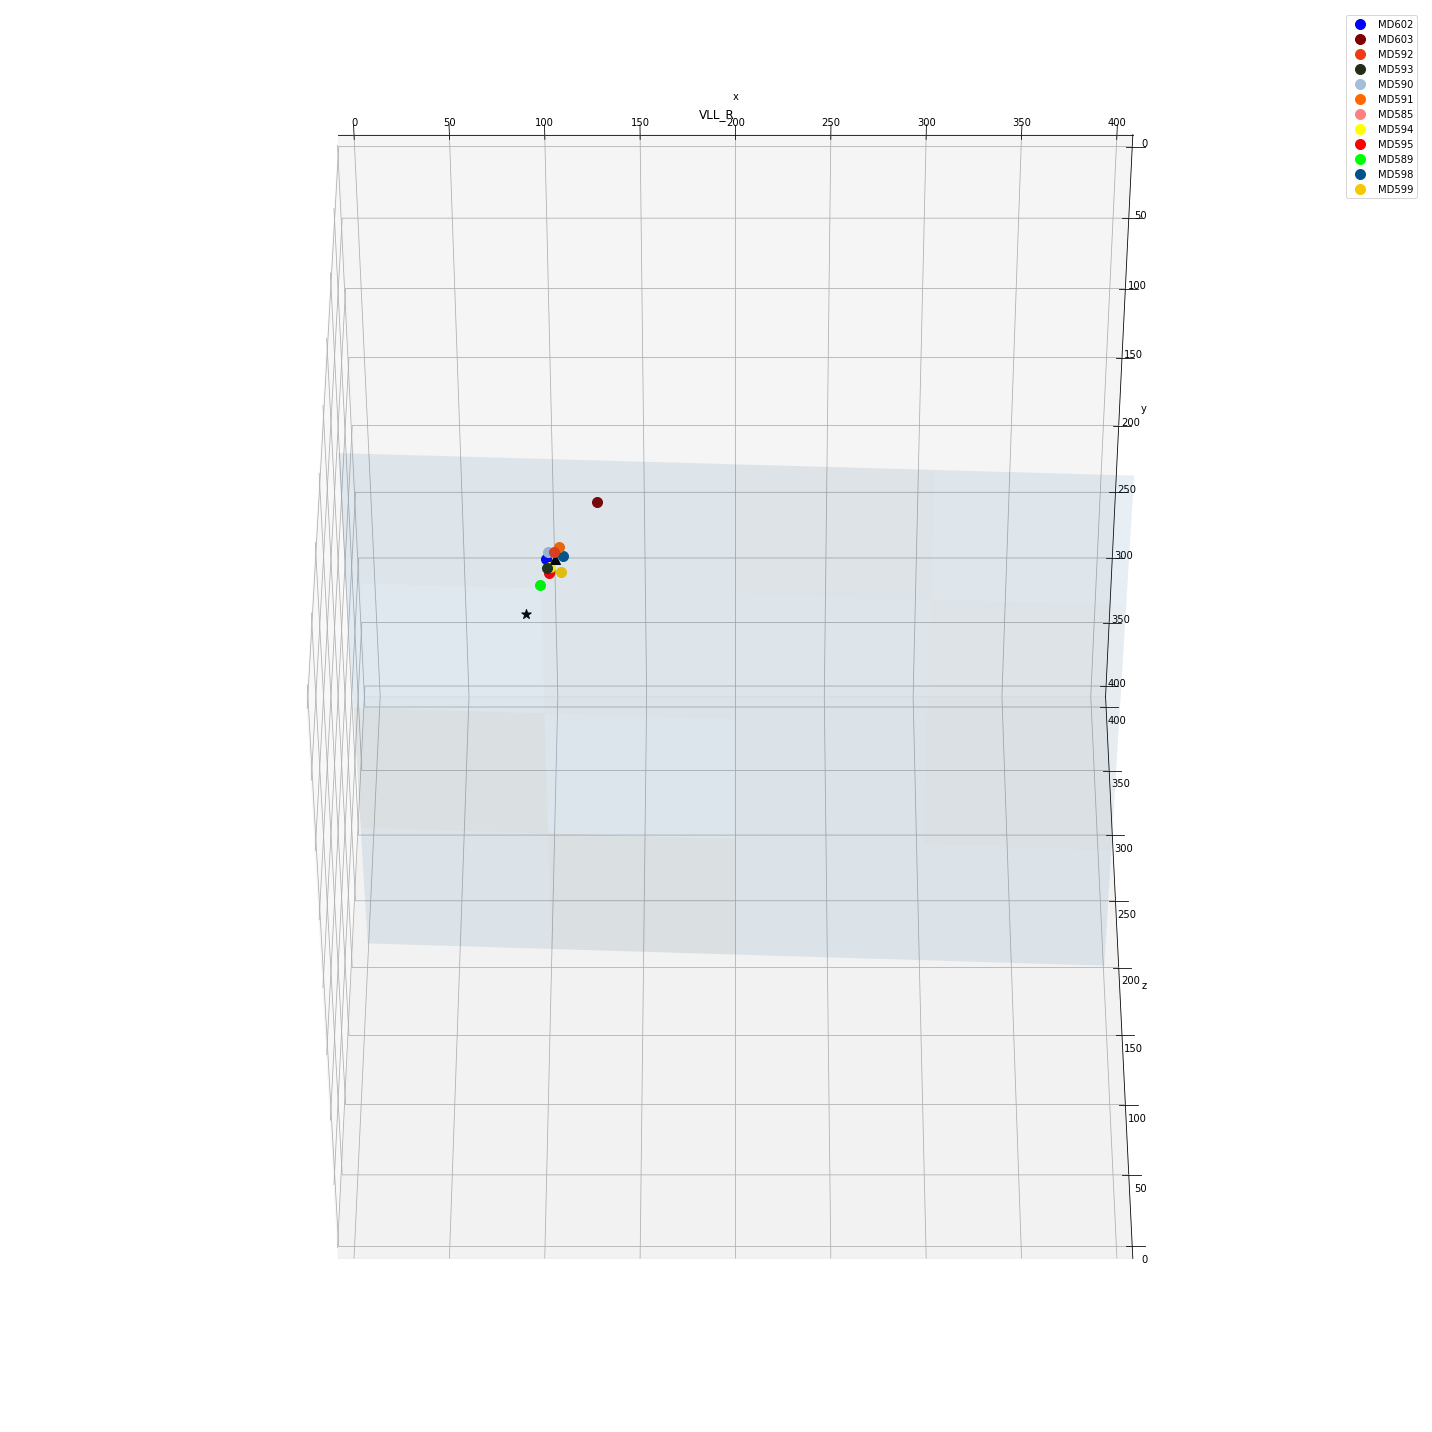

In [60]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

for ss in sorted(all_known_structures_sided):
# for ss in ['PBG_L', 'PBG_R']:

    fig = plt.figure(figsize=(20, 20));
#     fig = plt.figure();
    ax = fig.add_subplot(111, projection='3d')
    
#     for name_s, centroids_rel2fixed in instance_centroids_rel2fixed.iteritems():
#         if name_s == ss:
# #         if convert_to_original_name(name_s) == ss:
# #         if True:
#             centroids = np.array(centroids_rel2fixed)
#             ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
#                        color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
#                        marker='o', s=100, alpha=.1)

#             c = canonical_locations_rel2fixed[name_s]
#             ax.scatter(c[0], c[1], c[2], 
#                        color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., marker='*', s=100)

#     #     # Plot uncerntainty ellipsoids
#     #     u = np.linspace(0.0, 2.0 * np.pi, 100)
#     #     v = np.linspace(0.0, np.pi, 100)
#     #     x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
#     #     y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
#     #     z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
#     #     for i in range(len(u)):
#     #         for j in range(len(v)):
#     #             [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

#     #     ax.plot_surface(x, y, z, color='b')
#     #     ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)

#     ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
#                color=(0,0,0), marker='^', s=200, alpha=.3)

    # Plot mid-sagittal plane
    ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

    #######################################################

    for name_s, centroids_rel2atlas in adjusted_structure_centroids_rel2atlas.iteritems():   
        if name_s == ss:
#         if convert_to_original_name(name_s) == ss:
#         if True:
            for st, c in centroids_rel2atlas.iteritems():
                ax.scatter(c[0], c[1], c[2], 
                       color=np.array(stack_to_color[st])/255., 
                       marker='o', s=100, alpha=1, label=st)

    ##########################################################

    c = canonical_locations_rel2fixed[ss]
    ax.scatter(c[0], c[1], c[2], color=(0,0,0), marker='*', s=100, alpha=1.)
    
    ############################################################
    
    c = new_mean_centroids_rel2atlas_allstructures[ss]
    ax.scatter(c[0], c[1], c[2], color=(0,0,0), marker='^', s=100, alpha=1.)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # ax.set_axis_off()
    ax.set_xlim3d([0, 400]);
    ax.set_ylim3d([0, 400]);
    ax.set_zlim3d([0, 400]);
    ax.view_init(azim = -90,elev = -45)
    ax.set_aspect(1.0)
    plt.legend()
    plt.title(ss);
    plt.tight_layout();
    plt.show()

In [58]:
%matplotlib inline

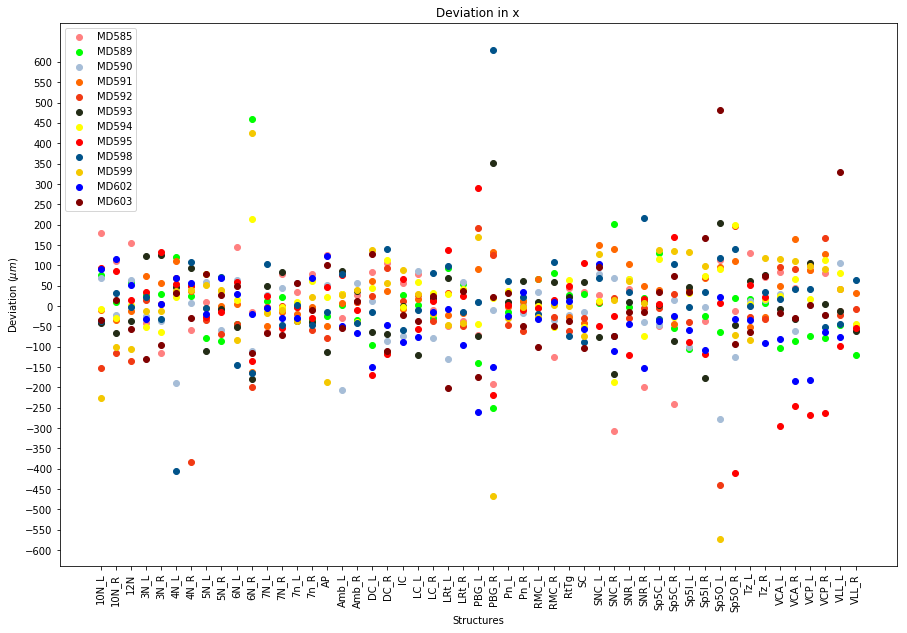

In [124]:
plt.figure(figsize=(15,10));

for st in all_nissl_stacks:
    vals = [instance_centroids_deviations_allstructures[s][st][0] * XY_PIXEL_DISTANCE_LOSSLESS * 32
            for s in sorted(all_known_structures_sided) 
            if st in instance_centroids_deviations_allstructures[s]]
    plt.scatter(range(len(vals)), vals,
                c=np.array(stack_to_color[st])/255., label=st)
#         else:
#             sys.stderr.write('No data for %s %s: \n' % (st, s))
plt.xticks(range(len(all_known_structures_sided)), sorted(all_known_structures_sided), rotation='90');
plt.xlabel('Structures')
plt.ylabel('Deviation ($\mu m$)')
plt.yticks(np.arange(-600, 650, 50))
plt.title('Deviation in x');
plt.legend()
plt.show()

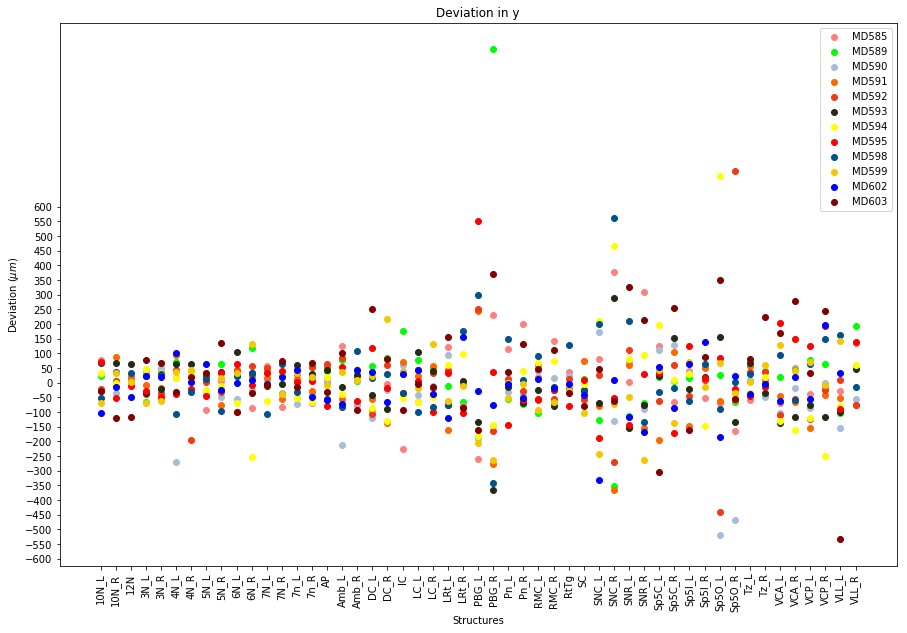

In [105]:
plt.figure(figsize=(15,10));

for st in all_nissl_stacks:
    vals = [instance_centroids_deviations_allstructures[s][st][1] * XY_PIXEL_DISTANCE_LOSSLESS * 32
            for s in sorted(all_known_structures_sided) 
            if st in instance_centroids_deviations_allstructures[s]]
    plt.scatter(range(len(vals)), vals,
                c=np.array(stack_to_color[st])/255., label=st)
plt.xticks(range(len(all_known_structures_sided)), sorted(all_known_structures_sided), rotation='90');
plt.xlabel('Structures')
plt.ylabel('Deviation ($\mu m$)')
plt.yticks(np.arange(-600, 650, 50))
plt.title('Deviation in y');
plt.legend()
plt.show()

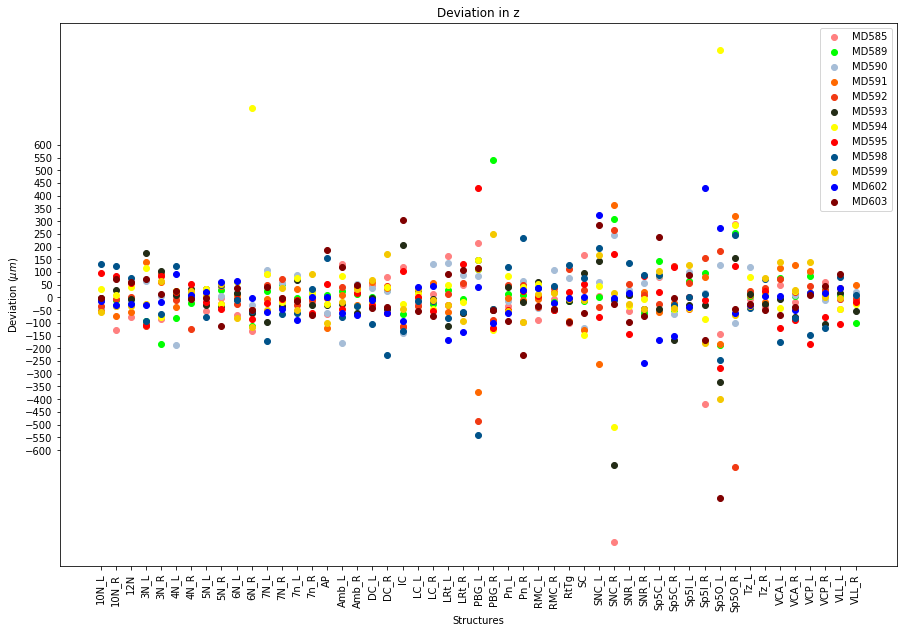

In [106]:
plt.figure(figsize=(15,10));

for st in all_nissl_stacks:
    vals = [instance_centroids_deviations_allstructures[s][st][2] * XY_PIXEL_DISTANCE_LOSSLESS * 32
            for s in sorted(all_known_structures_sided) 
            if st in instance_centroids_deviations_allstructures[s]]
    plt.scatter(range(len(vals)), vals,
                c=np.array(stack_to_color[st])/255., label=st)
plt.xticks(range(len(all_known_structures_sided)), sorted(all_known_structures_sided), rotation='90');
plt.xlabel('Structures')
plt.ylabel('Deviation ($\mu m$)')
plt.yticks(np.arange(-600, 650, 50))
plt.title('Deviation in z');
plt.legend()
plt.show()

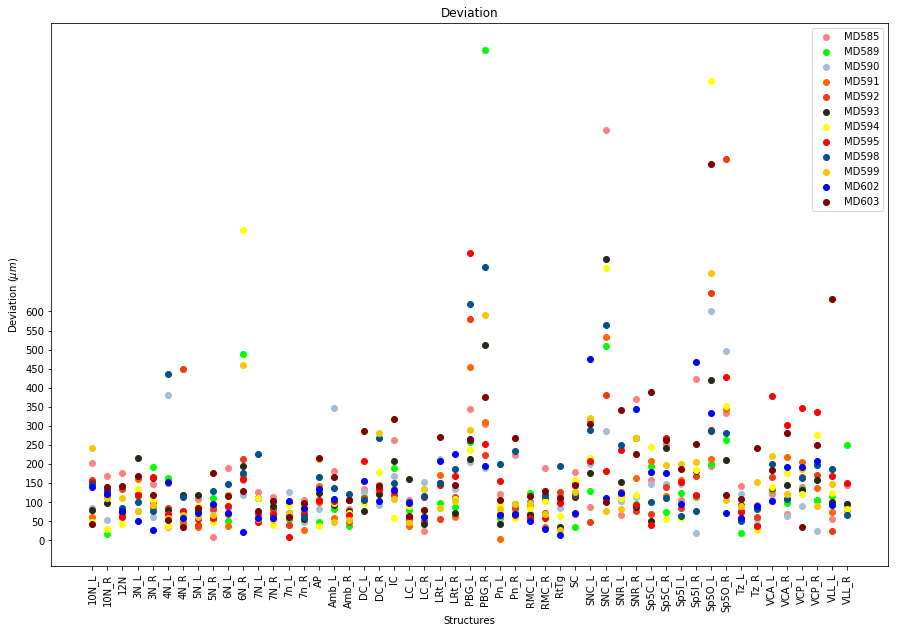

In [109]:
plt.figure(figsize=(15,10));

for st in all_nissl_stacks:
    vals = [np.linalg.norm(instance_centroids_deviations_allstructures[s][st]) * XY_PIXEL_DISTANCE_LOSSLESS * 32
            for s in sorted(all_known_structures_sided) 
            if st in instance_centroids_deviations_allstructures[s]]
    plt.scatter(range(len(vals)), vals,
                c=np.array(stack_to_color[st])/255., label=st)

plt.xticks(range(len(all_known_structures_sided)), sorted(all_known_structures_sided), rotation='90');
plt.xlabel('Structures')
plt.ylabel('Deviation ($\mu m$)')
plt.yticks(np.arange(0, 650, 50))
plt.title('Deviation');
plt.legend()
plt.show()